# <center> <font color = "#ef4155"> **Implémentation d'un modèle de scoring**

## <font color = "#ef4155"> **Description du projet :** <br>
<font color = "black"> L'entreprise **"Prêt à dépenser"** est une société financière spécialisée dans l'octroie des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt. Cette entreprise souhaite mettre en œuvre un outil de **“scoring crédit”** pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un **algorithme de classification** en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

Dans un soucis de transpence vis à vis de sa clientèle, "Prêt à dépenser" souhaite également développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

## <font color = "#ef4155"> **Ma mission** <br>
<font color = "black"> Accompagner "Prêt à dépenser" pour : 

1. Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique ; 

2. Construire un dashboard interactif.

3. Mettre en production le modèle de scoring de prédiction à l’aide d’une API, ainsi que le dashboard interactif qui appelle l’API pour les prédictions.

J'ai à ma disposition un jeu de données constitué de 10 fichiers. Ces fichiers et leur description sont disponibles **[ici](https://www.kaggle.com/c/home-credit-default-risk/data)**. D'après la description des fichiers, il y en a 2 dont il ne sera pas nécessaire de charger pour ce travail : "sample_submission et HomeCredit_columns_description". Je ne travaillerai par conséquent qu'avec 8 fichiers.

Afin de gagner en temps et me consacrer sur la modélisation, je vais m'inspirer des kernel kaggle proposé **[RISHABH RAO](https://www.kaggle.com/rishabhrao)** et **[Aguiar](https://www.kaggle.com/jsaguiar)** accessible depuis les liens ci-dessous : 
* [kernel de RISHABH RAO](https://www.kaggle.com/code/rishabhrao/home-credit-default-risk-extensive-eda/notebook) : pour l'analyse exploratoire ;
* [kernel de Aguiar](https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script) : pour le feature engeneering.

## <font color = "#ef4155"> **Protocole de travail :** <br>
<font color = "black"> Pour réaliser cette mission visant à étudier la faisabilité d'un moteur de classification d'articles basé sur une image et une description, je vais suivre les étapes suivantes :

<font color = "blue"> 1. **Préparations des données** : <font color = "black">
* Analyse exploratoire ;
* Prétraitement des données (feature engeneering) : nettoyage, gestion des valeurs manquantes, encodage des variables catégorielles, etc.

<font color = "blue">2. **Modélisation du scoring de crédit :**<font color = "black">
* Diviser les données en un ensemble d'entraînement (pour le modèle) et un ensemble de test (pour l'évaluation) ;
* Tester différents algorithmes de machine learning pour construire un modèle de classification pour prédire la probabilité de défaut de remboursement ;
* Sélectionner le meilleur modèle et appliquer la cross-validation (GridSearchCV) pour ajuster les hyperparamètres et évaluer ses performances.

<font color = "blue">3.  **Création du dashboard interactif :** <font color = "black">
* Développer le dashboard avec Dash ;
* Intégrer le modèle de scoring dans le dashboard pour permettre aux utilisateurs de visualiser les scores et leur interprétation ;
* Créer des filtres pour afficher les informations descriptives des clients et permettre des comparaisons.

<font color = "blue">4. **Mise en production :** <font color = "black">
* Héberger le modèle de scoring en utilisant l'API FastAPI ;
* Intégrer le dashboard interactif avec l'API pour récupérer les prédictions en temps réel ;
* Déployer l'application sur la plateforme Cloud Azure, Heroku.

<font color = "blue">5.  **Démarche MLOps et Data Drift :**<font color = "black">
* Mettre en place un pipeline MLOps pour automatiser le déploiement, la surveillance et la mise à jour du modèle ;
* Utiliser **Evidently** pour surveiller les données en production par rapport aux données d'entraînement, en identifiant tout Data Drift ;
* Planifier des mises à jour régulières du modèle en fonction des résultats de la surveillance.

<font color = "blue">6. **Documentation :** <font color = "black"> Documenter tout le processus, y compris le code, les modèles, et la démarche MLOps.

_**Ce notebook sera consacré à préparation des données**_

### <font color = "#ef4155"> **Préparation des données**

#### <font color = "#ef4155"> **1. Importation des librairies et définition des fonctions**

#### <font color = "blue"> **1.1. Importation des librairies**

Je commence par charger les bibliothèques, modules, fonctions et paramètres. 

In [1]:
# Import des bibliothèques de manipulation de données
import pandas as pd
import numpy as np
from skimpy import skim
from phik import phik_matrix

# Bibliothèques de visualisation de données
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Import des fonctions de gestion de l'affichage Jupyter Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import gc  # Garbage Collector pour gérer la mémoire

# Configuration des options d'affichage 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.precision = 2
palette = sns.diverging_palette(220, 10, n = 9)

# Désactivation des avertissements
import warnings
warnings.filterwarnings('ignore')

# Import de la bibliothèque de gestion de dates
from datetime import datetime

import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import plotly.subplots as sp
from sklearn.model_selection import train_test_split

import re

plotly.offline.init_notebook_mode(connected=True)
%load_ext autotime

pd.set_option("display.float_format", lambda x: "%.2f" % x)


time: 0 ns (started: 2023-09-19 03:25:02 +02:00)


#### <font color = "blue"> **1.2. Définition des fonctions**

Afin d'éviter la répétition du code, je vais définir un ensemble de fonction qui servira :
* Pour charger les fichiers ;
* Analyser les valeurs manquantes ;

_**Définition de la fonction pour charger les données**_

In [2]:
def charger_data():
    # Liste des chemins des fichiers CSV

    data_files = [
        'application_test.csv',
        'application_train.csv',
        'bureau.csv',
        'bureau_balance.csv',
        'credit_card_balance.csv',
        'HomeCredit_columns_description.csv',
        'installments_payments.csv',
        'POS_CASH_balance.csv',
        'previous_application.csv',
        'sample_submission.csv'
    ]
    start = datetime.now()
    data = {}  # Créez un dictionnaire pour stocker vos données
    
    for file in data_files:
        data_name = file.split('.')[0]  # Utilisez le nom du fichier sans extension comme clé
        data[data_name] = pd.read_csv(file, encoding='ISO-8859-1')
    print(f'Temps mis pour lire les 10 fichiers = {datetime.now() - start}')
    return data

time: 16 ms (started: 2023-09-19 03:25:02 +02:00)


_**Fonctions pour analyser les valeurs manquantes :**_
* _Une fonction pour afficher les valeurs manquantes sous forme de tableau ;_
* _Visualisation graphique des valeurs manquantes ;_

In [3]:
# Fonction pour créer un DataFrame répertoriant les pourcentages de valeurs manquantes par colonne
def nan_df_create(data):
    # Calcul des pourcentages de valeurs manquantes pour chaque colonne
    nan_percentages = data.isna().sum() * 100 / len(data)
    
    # Création d'un DataFrame avec deux colonnes : nom de la colonne et pourcentage de valeurs manquantes
    df = pd.DataFrame({'column': nan_percentages.index, 'percent': nan_percentages.values})

    # Tri du DataFrame en ordre décroissant des pourcentages de valeurs manquantes
    df.sort_values(by='percent', ascending=False, inplace=True)
    
    # Retourne le DataFrame contenant les informations sur les valeurs manquantes
    return df

time: 0 ns (started: 2023-09-19 03:25:02 +02:00)


In [4]:
def plot_nan_percent(df_nan, title_name, figsize=(1400, 600), rotation=90):
    """
    Trace un graphique des pourcentages de valeurs manquantes par colonne à l'aide de Plotly.

    Paramètres:
    df_nan (DataFrame): Le DataFrame contenant les pourcentages de valeurs manquantes.
    title_name (str): Le nom du DataFrame ou de la source des données à afficher dans le titre du graphique.
    figsize (tuple, optional): La taille de la figure du graphique en pixels. Par défaut, (800, 400).
    rotation (int, optional): L'angle de rotation des étiquettes de l'axe x. Par défaut, 90 degrés.

    Returns:
    None
    """

    # Filtrer les colonnes avec des pourcentages de valeurs manquantes supérieurs à 0
    df_filtered = df_nan[df_nan['percent'] > 0]

    if not df_filtered.empty:
        # Créer une figure avec Plotly
        fig = go.Figure(data=[go.Bar(x=df_filtered['column'], y=df_filtered['percent'])])
        
        # Personnaliser l'apparence du graphique
        fig.update_xaxes(tickangle=rotation)
        fig.update_layout(width=figsize[0], height=figsize[1])
        fig.update_layout(title=f'Pourcentage de valeurs NaN dans {title_name}')
        
        # Afficher le graphique
        fig.show()

    else:
        # Afficher un message si le DataFrame ne contient pas de valeurs NaN
        print(f"Le DataFrame {title_name} ne contient pas de valeurs manquantes.")


time: 0 ns (started: 2023-09-19 03:25:02 +02:00)


_**Fonctions pour l'analyse des corrélations pour l'ensemble des données :**_<br> _Je vais créer une classe permettant de visualiser la matrice de corrélation des variables numériques d'un DataFrame, ainsi que de calculer les colonnes les plus corrélées avec une variable cible en utilisant la corrélation Phik, qui est mieux adaptée à la stucture de ces données que le coefficient de corrélation de Pearson._

In [5]:
class CorrelationMatrix:
    """
    Classe pour créer et analyser une matrice de corrélation pour des données catégorielles.
    """

    def __init__(self, data, columns_to_drop, figsize=(25, 23), mask_upper=True,
                 tight_layout=True, linewidth=0.1, fontsize=10, cmap = palette):
        
        """
        Arguments :
        data (DataFrame): Le DataFrame contenant les données.
        columns_to_drop (list): Liste des colonnes à exclure de l'analyse de corrélation.
        figsize (tuple): La taille de la figure du graphique de la matrice de corrélation. Par défaut, (25, 23).
        mask_upper (bool): Indique s'il faut masquer la moitié supérieure de la matrice. Par défaut, True.
        tight_layout (bool): Indique si l'ajustement automatique de la disposition du graphique doit être appliqué. Par défaut, True.
        linewidth (float): L'épaisseur des lignes entre les cellules du graphique. Par défaut, 0.1.
        fontsize (int): La taille de la police pour les étiquettes des axes. Par défaut, 10.
        cmap (str): La colormap à utiliser pour la représentation visuelle de la corrélation. Par défaut, 'Blues'.
        
        """
        self.data = data
        self.columns_to_drop = columns_to_drop
        self.figsize = figsize
        self.mask_upper = mask_upper
        self.tight_layout = tight_layout
        self.linewidth = linewidth
        self.fontsize = fontsize
        self.cmap = cmap 
        
        # Initialisez self.corr_data ici en calculant la matrice de corrélation
        self.initialize_corr_data()

    def initialize_corr_data(self):
        # Supprime les colonnes spécifiées à exclure
        columns_to_exclude = self.columns_to_drop + ['TARGET']
        
        # Sélectionnez uniquement les colonnes numériques
        numeric_columns = self.data.drop(columns=columns_to_exclude, axis=1).select_dtypes(include='number')
        
        # Calculez la matrice de corrélation uniquement pour les colonnes numériques
        self.corr_data = numeric_columns.corr()
        
    # Le reste de votre classe et de ses méthodes reste inchangé


    def plot_correlation_matrix(self):
        """
        Crée et affiche la matrice de corrélation en excluant les colonnes catégorielles.
        """
        # Supprime les colonnes spécifiées à exclure
        columns_to_exclude = self.columns_to_drop + ['TARGET']
    
        # Sélectionnez uniquement les colonnes numériques
        numeric_columns = self.data.drop(columns=columns_to_exclude, axis=1).select_dtypes(include='number')
    
        # Calculez la matrice de corrélation uniquement pour les colonnes numériques
        corr_data = numeric_columns.corr()

        # Crée un masque pour masquer la moitié supérieure ou inférieure de la matrice
        if self.mask_upper:
            mask_array = np.triu(np.ones(corr_data.shape))
        else:
            mask_array = np.zeros(corr_data.shape)

        # Crée la figure pour le graphique
        plt.figure(figsize=self.figsize, tight_layout=self.tight_layout)
    
        # Trace la heatmap de la matrice de corrélation
        sns.heatmap(corr_data, annot=False, mask=mask_array,
                linewidths=self.linewidth, cmap=self.cmap)
    
        # Personnalise les étiquettes des axes et le titre
        plt.xticks(rotation=90, fontsize=self.fontsize)
        plt.yticks(fontsize=self.fontsize)
        plt.title("Matrice de corrélation pour les caractéristiques numériques")
    
        # Affiche le graphique
        plt.show()


    def target_top_corr(self, target_top_columns=10):
        """
        Calcule les colonnes les plus corrélées avec la variable cible.

        Arguments :
            target_top_columns (int): Le nombre de colonnes les plus corrélées à renvoyer. Par défaut, 10.

        Returns:
            DataFrame: Un DataFrame contenant les colonnes les plus corrélées avec la variable cible.
        """
        phik_target_arr = np.zeros(self.corr_data.shape[1])

        # Calcule la corrélation Phik entre la variable cible et chaque colonne
        for index, column in enumerate(self.corr_data.columns):
            phik_target_arr[index] = self.data[['TARGET', column]].phik_matrix().iloc[0, 1]

        # Crée un DataFrame avec les résultats de corrélation Phik
        top_corr_target_df = pd.DataFrame({'Column Name': self.corr_data.columns,
                                           'Phik-Correlation': phik_target_arr})
        
        # Trie les colonnes par ordre décroissant de corrélation Phik
        top_corr_target_df = top_corr_target_df.sort_values(by='Phik-Correlation', ascending=False)

        # Renvoie les colonnes les plus corrélées
        return top_corr_target_df.iloc[:target_top_columns]

time: 0 ns (started: 2023-09-19 03:25:02 +02:00)


In [6]:
def plot_phik_matrix(data, categorical_columns, figsize=(20, 20), mask_upper=True, tight_layout=True,
                     linewidth=0.1, fontsize=10, cmap = palette, show_target_top_corr=True, target_top_columns=10):
    """
    Crée et affiche la matrice de corrélation Phi-K (Phik) pour les caractéristiques catégorielles.

    Arguments:
        data (DataFrame): Le DataFrame contenant les données.
        categorical_columns (list): Liste des colonnes catégorielles à inclure dans l'analyse.
        figsize (tuple): La taille de la figure du graphique de la matrice de corrélation. Par défaut, (20, 20).
        mask_upper (bool): Indique s'il faut masquer la moitié supérieure de la matrice. Par défaut, True.
        tight_layout (bool): Indique si l'ajustement automatique de la disposition du graphique doit être appliqué. Par défaut, True.
        linewidth (float): L'épaisseur des lignes entre les cellules du graphique. Par défaut, 0.1.
        fontsize (int): La taille de la police pour les étiquettes des axes. Par défaut, 10.
        cmap (str): La colormap à utiliser pour la représentation visuelle de la corrélation. Par défaut, 'Blues'.
        show_target_top_corr (bool): Indique s'il faut afficher les catégories avec les plus hautes valeurs de corrélation Phik avec la variable cible. Par défaut, True.
        target_top_columns (int): Le nombre de catégories à afficher en cas de show_target_top_corr=True. Par défaut, 10.
    """
    
    # Sélectionne les colonnes catégorielles et les convertit en objets pour le calcul de Phik
    data_for_phik = data[categorical_columns].astype('object')
    
    # Calcule la matrice de corrélation Phik
    phik_matrix_result = phik_matrix(data_for_phik)
    
    print('-'*100)
    
    # Crée un masque pour na pas afficher la moitié supérieure ou inférieure de la matrice
    if mask_upper:
        mask_array = np.ones(phik_matrix_result.shape)
        mask_array = np.triu(mask_array)
    else:
        mask_array = np.zeros(phik_matrix_result.shape)
    
    # Crée la figure pour le graphique
    plt.figure(figsize=figsize, tight_layout=tight_layout)
    
    # Trace la heatmap de la matrice de corrélation Phik
    sns.heatmap(phik_matrix_result, annot=False, mask=mask_array,
                linewidths=linewidth, cmap=cmap)
    
    # Personnalise les étiquettes des axes et le titre
    plt.xticks(rotation=90, fontsize=fontsize)
    plt.yticks(rotation=0, fontsize=fontsize)
    plt.title("Matrice de corrélation Phi-K (Phik) pour les caractéristiques catégorielles")
    
    # Affiche le graphique
    plt.show()
    print("-"*100)

    if show_target_top_corr:
        # Affiche les catégories avec les plus hautes valeurs de corrélation Phik avec la variable cible
        print("Catégories avec les valeurs les plus élevées de corrélation Phi-K (Phik) avec la variable cible :")
        phik_df = pd.DataFrame({'Column Name': phik_matrix_result.TARGET.index[1:],
                                'Phik-Correlation': phik_matrix_result.TARGET.values[1:]})
        phik_df = phik_df.sort_values(by='Phik-Correlation', ascending=False)
        display(phik_df.head(target_top_columns))
        print("-"*100)

time: 0 ns (started: 2023-09-19 03:25:02 +02:00)


_**Analyse de la distribution des variables :** le but est d'analyser la distribution des données catégorielles et leur impact sur la variable cible._

In [30]:
def plot_categorical_variables_bar(data, column_name, figsize=(18, 6), percentage_display=True,
                                   plot_defaulter=True, rotation=0, horizontal_adjust=0, fontsize_percent='xx-small'):
    """
    Crée un graphique à barres pour visualiser la distribution des valeurs d'une variable catégorielle.

    Arguments:
        data (DataFrame): Le DataFrame contenant les données.
        column_name (str): Le nom de la colonne contenant les variables catégorielles à visualiser.
        figsize (tuple): La taille de la figure du graphique. Par défaut, (18, 6).
        percentage_display (bool): Indique si les pourcentages de chaque catégorie doivent être affichés. Par défaut, True.
        plot_defaulter (bool): Indique si le graphique des pourcentages de défaillants doit être affiché. Par défaut, True.
        rotation (int): L'angle de rotation des étiquettes des catégories sur l'axe des abscisses. Par défaut, 0.
        horizontal_adjust (float): Ajustement horizontal pour les étiquettes des pourcentages. Par défaut, 0.
        fontsize_percent (str): La taille de la police pour les pourcentages affichés. Par défaut, 'xx-small'.
    """
    
    # Affiche le nombre total de catégories uniques dans la colonne spécifiée
    print(f"Nombre total de catégories uniques de {column_name} = {len(data[column_name].unique())}")
    
    # Crée une figure pour le graphique
    plt.figure(figsize=figsize, tight_layout=False)
    sns.set(style='whitegrid', font_scale=1.2)
    
    # Crée le premier sous-graphique pour la distribution des valeurs
    plt.subplot(1, 2, 1)
    
    # Compte les occurrences de chaque catégorie et les trie par ordre décroissant
    data_to_plot = data[column_name].value_counts().sort_values(ascending=False)
    
    # Trace le graphique à barres
    ax = sns.barplot(x=data_to_plot.index, y=data_to_plot, palette='Set1')
    
    # Si percentage_display est activé, affiche les pourcentages au-dessus des barres
    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            ax.text(p.get_x() + horizontal_adjust, p.get_height() + 0.005 * total_datapoints,
                    '{:.1f}%'.format(p.get_height() * 100 / total_datapoints), fontsize=fontsize_percent)
    
    plt.xlabel(column_name, labelpad=10)
    plt.title(f'Distribution de {column_name}', pad=20)
    plt.xticks(rotation=rotation)
    plt.ylabel('Counts')
    
    # Si plot_defaulter est activé, crée le deuxième sous-graphique pour les pourcentages de défaillants
    if plot_defaulter:
        percentage_defaulter_per_category = (data[column_name][data.TARGET == 1].value_counts() * 100 /
                                             data[column_name].value_counts()).dropna().sort_values(ascending=False)

        plt.subplot(1, 2, 2)
        sns.barplot(x=percentage_defaulter_per_category.index, y=percentage_defaulter_per_category, palette='Set2')
        plt.ylabel('Pourcentage de défaillants par catégorie')
        plt.xlabel(column_name, labelpad=10)
        plt.xticks(rotation=rotation)
        plt.title(f'Pourcentage de défaillants pour chaque catégorie de {column_name}', pad=20)
    
    # Affiche les graphiques
    plt.show()

time: 0 ns (started: 2023-09-19 03:34:37 +02:00)


In [8]:
def plot_categorical_variables_pie(data, column_name, plot_defaulter=True, hole=0):
    """
    Crée un graphique en secteurs (pie chart) pour visualiser la distribution des valeurs d'une variable catégorielle.

    Args:
        data (DataFrame): Le DataFrame contenant les données.
        column_name (str): Le nom de la colonne contenant les variables catégorielles à visualiser.
        plot_defaulter (bool): Indique si le graphique des pourcentages de défaillants doit être affiché. Par défaut, True.
        hole (float): Le diamètre du trou central du graphique en secteurs (0 pour un secteur plein). Par défaut, 0.
    """
    
    # Définit le nombre de colonnes et les spécifications de la disposition des sous-graphiques
    if plot_defaulter:
        cols = 2
        specs = [[{'type': 'domain'}, {'type': 'domain'}]]
        titles = [f'Distribution de {column_name} pour toutes les cibles',
                  f'Pourcentage de défaillants pour chaque catégorie de {column_name}']
    else:
        cols = 1
        specs = [[{'type': 'domain'}]]
        titles = [f'Distribution de {column_name} pour toutes les cibles']

    # Compte les occurrences de chaque catégorie et récupère les étiquettes
    values_categorical = data[column_name].value_counts()
    labels_categorical = values_categorical.index

    # Crée une figure avec un ou deux sous-graphiques en secteurs (pie charts)
    fig = make_subplots(rows=1, cols=cols, specs=specs, subplot_titles=titles)

    # Ajoute le premier secteur pour la distribution de toutes les valeurs
    fig.add_trace(go.Pie(values=values_categorical, labels=labels_categorical, hole=hole,
                         textinfo='label+percent', textposition='inside'), row=1, col=1)

    # Si plot_defaulter est activé, ajoute le deuxième secteur pour les pourcentages de défaillants
    if plot_defaulter:
        percentage_defaulter_per_category = (data[column_name][data.TARGET == 1].value_counts() * 100 /
                                             data[column_name].value_counts())
        percentage_defaulter_per_category.dropna(inplace=True)
        percentage_defaulter_per_category = percentage_defaulter_per_category.round(2)

        fig.add_trace(go.Pie(values=percentage_defaulter_per_category,
                             labels=percentage_defaulter_per_category.index,
                             hole=hole, textinfo='label+value', hoverinfo='label+value'), row=1, col=2)

    # Met à jour la mise en page de la figure et affiche le graphique
    fig.update_layout(title=f'Distribution de {column_name}')
    fig.show()

time: 0 ns (started: 2023-09-19 03:25:02 +02:00)


In [9]:
def print_unique_categories(data, column_name, show_counts=False):
    """
    Affiche les catégories uniques d'une colonne spécifiée d'un DataFrame.

    Args:
        data (DataFrame): Le DataFrame contenant les données.
        column_name (str): Le nom de la colonne dont les catégories uniques doivent être affichées.
        show_counts (bool): Indique si les comptes de chaque catégorie doivent également être affichés. Par défaut, False.
    """
    
    # Affiche une ligne de séparation pour la clarté
    print('-' * 100)
    
    # Affiche les catégories uniques de la colonne spécifiée
    print(f"Les catégories uniques de '{column_name}' sont :\n{data[column_name].unique()}")
    
    # Affiche une ligne de séparation pour la clarté
    print('-' * 100)
    
    # Si show_counts est activé, affiche les comptes de chaque catégorie
    if show_counts:
        print(f"Les comptes de chaque catégorie sont :\n{data[column_name].value_counts()}")
        print('-' * 100)

time: 0 ns (started: 2023-09-19 03:25:02 +02:00)


_**Analyse des variables numériques**_

In [10]:
def plot_cdf(data, column_name, log_scale=False, figsize=(12, 8)):
    """
    Crée un graphique de la fonction de distribution cumulative (CDF) d'une variable numérique.

    Args:
        data (DataFrame): Le DataFrame contenant les données.
        column_name (str): Le nom de la colonne contenant la variable numérique à analyser.
        log_scale (bool): Indique si l'échelle de l'axe des x doit être logarithmique. Par défaut, False.
        figsize (tuple): La taille de la figure du graphique. Par défaut, (12, 8).
    """
    
    # Trie les valeurs de la colonne spécifiée par ordre croissant
    percentile_values = data[[column_name]].dropna().sort_values(by=column_name)
    
    # Calcule les percentiles correspondants à chaque valeur de la variable
    percentile_values['Percentile'] = [ele / (len(percentile_values) - 1) for ele in range(len(percentile_values))]

    # Crée une figure avec la taille spécifiée
    plt.figure(figsize=figsize)
    
    # Si log_scale est activé, définir l'échelle de l'axe des x comme logarithmique
    if log_scale:
        plt.xscale('log')
        plt.xlabel(column_name + ' - (log-scale)')
    else:
        plt.xlabel(column_name)
    
    # Trace la CDF en utilisant les valeurs et les percentiles calculés
    plt.plot(percentile_values[column_name], percentile_values['Percentile'], color='red')
    
    plt.ylabel('Probability')
    plt.title('CDF de {}'.format(column_name))
    
    # Affiche le graphique
    plt.show()

time: 0 ns (started: 2023-09-19 03:25:02 +02:00)


In [11]:
def print_percentiles(data, column_name, percentiles=None):
    """
    Affiche les valeurs de percentiles pour une variable numérique spécifique.

    Args:
        data (DataFrame): Le DataFrame contenant les données.
        column_name (str): Le nom de la colonne contenant la variable numérique à analyser.
        percentiles (list): Les percentiles à calculer et afficher. Par défaut, une liste de percentiles standard est utilisée.

    Returns:
        None
    """
    print('-' * 100)
    if not percentiles:
        percentiles = list(range(0, 80, 25)) + list(range(90, 101, 2))
    for i in percentiles:
        print(f"La valeur du {i}e percentile de '{column_name}' est {np.percentile(data[column_name].dropna(), i)}")
    print("-" * 100)

time: 16 ms (started: 2023-09-19 03:25:02 +02:00)


In [12]:

def plot_continuous_variables(data, column_name, plots=['distplot', 'CDF', 'box', 'violin'], scale_limits=None, figsize=(14, 6), histogram=True, log_scale=False):
    """
    Crée un ensemble de graphiques pour analyser une variable numérique.

    Args:
        data (DataFrame): Le DataFrame contenant les données.
        column_name (str): Le nom de la colonne contenant la variable numérique à analyser.
        plots (list): Les types de graphiques à créer. Peut inclure 'distplot', 'CDF', 'box', 'violin'. Par défaut, tous les types sont inclus.
        scale_limits (tuple): Les limites de l'échelle pour la variable numérique. Par défaut, None (pas de limites).
        figsize (tuple): La taille de la figure. Par défaut, (20, 8).
        histogram (bool): Indique si un histogramme doit être inclus dans le graphique 'distplot'. Par défaut, True.
        log_scale (bool): Indique si l'échelle logarithmique doit être utilisée pour l'axe des x dans les graphiques. Par défaut, False.

    Returns:
        None
    """
    data_to_plot = data.copy()
    if scale_limits:
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize=figsize)
    sns.set_style('whitegrid')

    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)

        if ele == 'CDF':
            # Calcul des CDF pour les non-défaillants et les défaillants
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by=column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0) - 1) for ele in range(len(percentile_values_0))]

            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by=column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1) - 1) for ele in range(len(percentile_values_1))]

            # Crée un graphique CDF
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color='red', label='Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color='black', label='Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF de {}'.format(column_name))
            plt.legend(fontsize='medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')

        if ele == 'distplot':
            # Crée un graphique de distribution (distplot) avec ou sans histogramme
            if histogram:
                sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                             label='Non-Defaulters', hist=True, color='red')
                sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                             label='Defaulters', hist=True, color='black')
            else:
                sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                             label='Non-Defaulters', hist=False, color='red')
                sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                             label='Defaulters', hist=False, color='black')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot de {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'violin':
            # Crée un graphique de type violin plot
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot de {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        if ele == 'box':
            # Crée un graphique de type box plot
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot de {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    plt.show()


time: 0 ns (started: 2023-09-19 03:25:02 +02:00)


A présent que la définition des fonctions est terminée, je peux procéder au chargement des données et effectuer l'exploration.

#### <font color = "#ef4155"> **2. Analyse exploratoire des données**


<font color = "b"> **Stratégie** :
* Pour chaque table de données, vérification des statistiques de base ;
* Ensuite, exploreration des caractéristiques concernant la variable cible pour chaque table en procédant ainsi : 
    - Pour les variables catégorielles, utilisation des graphiques à barres et des diagrammes circulaires.
    - Pour les variables continues/numériques, utilisation des Box-Plots, des PDF, des CDF et des Violin-Plots.

Nous tirerons des observations de chaque graphique et noterons les informations importantes générées.

#### <font color = "blue"> **2.1. Chargement des données**

In [13]:
# Utilisation de la fonction pour charger les données
donnees = charger_data()

Temps mis pour lire les 10 fichiers = 0:01:22.479181
time: 1min 22s (started: 2023-09-19 03:25:02 +02:00)


In [14]:
# Chargement des données depuis un dictionnaire 'donnees' en utilisant des clés spécifiques chaque clé correspond à un ensemble de données

# Chargement des données du fichier 'application_test.csv' et les stocker dans 'application_test'
application_test = donnees['application_test']

# Chargement des données du fichier 'application_train.csv' et les stocker dans 'application_train'
application_train = donnees['application_train']

# Chargement des données du fichier 'bureau.csv' et les stocker dans 'bureau'
bureau = donnees['bureau']

# Chargement des données du fichier 'bureau_balance.csv' et les stocker dans 'bureau_balance'
bureau_balance = donnees['bureau_balance']

# Chargement des données du fichier 'credit_card_balance.csv' et les stocker dans 'credit_card_balance'
credit_card_balance = donnees['credit_card_balance']

# Chargement des données du fichier 'HomeCredit_columns_description.csv' et les stocker dans 'HomeCredit_columns_description'
HomeCredit_columns_description = donnees['HomeCredit_columns_description']

# Chargement des données du fichier 'installments_payments.csv' et les stocker dans 'installments_payments'
installments_payments = donnees['installments_payments']

# Chargement des données du fichier 'POS_CASH_balance.csv' et les stocker dans 'POS_CASH_balance'
POS_CASH_balance = donnees['POS_CASH_balance']

# Chargement des données du fichier 'previous_application.csv' et les stocker dans 'previous_application'
previous_application = donnees['previous_application']

# Chargement des données du fichier 'sample_submission.csv' et les stocker dans 'sample_submission'
sample_submission = donnees['sample_submission']


time: 63 ms (started: 2023-09-19 03:26:24 +02:00)


#### <font color = "#5784BA"> **2.2. Analyse des dataset application train et test**

##### <font color = "#4AA3A2"> _**A propos de ces données**_

<font color = "b">La table application_train.csv est constituée de données statiques relatives aux Emprunteurs avec des labels. Chaque ligne représente une demande de prêt. Le fichier application_test.csv contient l'ensemble de données de test et est similaire à application_train.csv, sauf l'absence de la colonne TARGET, qui doit être prédit à l'aide de modèles prédictifs statistiques et d'apprentissage automatique.

#### <font color = "#4AA3A2"> _**Description des données**_

In [15]:
print('-'*53)
print(f'Dimension de application_train est de : {application_train.shape}')
print('-'*53)
print(f'Nombre de doublons dans application_train : {application_train.shape[0] - application_train.duplicated().shape[0]}')
print('-'*53)
display(application_train.head())

-----------------------------------------------------
Dimension de application_train est de : (307511, 122)
-----------------------------------------------------


Nombre de doublons dans application_train : 0
-----------------------------------------------------


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.00,406597.50,24700.50,351000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02,-9461,-637,-3648.00,-2120,NaN,1,1,0,1,1,0,Laborers,1.00,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.63,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,reg oper account,block of flats,0.01,"Stone, brick",No,2.00,2.00,2.00,2.00,-1134.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,0,Cash loans,F,N,N,0,270000.00,1293502.50,35698.50,1129500.00,Family,State servant,Higher education,Married,House / apartment,0.00,-16765,-1188,-1186.00,-291,NaN,1,1,0,1,1,0,Core staff,2.00,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31,0.62,NaN,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.05,0.00,0.01,0.09,0.05,0.99,0.80,0.05,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.00,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.01,reg oper account,block of flats,0.07,Block,No,1.00,0.00,1.00,0.00,-828.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,100004,0,Revolving loans,M,Y,Y,0,67500.00,135000.00,6750.00,135000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01,-19046,-225,-4260.00,-2531,26.00,1,1,1,1,1,0,Laborers,1.00,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.56,0.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,-815.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.0

time: 5.2 s (started: 2023-09-19 03:26:25 +02:00)


In [16]:
print('-'*53)
print(f'Dimension de application_test est de : {application_test.shape}')
print('-'*53)
print(f'Nombre de doublons dans application_test : {application_test.shape[0] - application_test.duplicated().shape[0]}')
print('-'*53)
display(application_test.head())

-----------------------------------------------------
Dimension de application_test est de : (48744, 121)
-----------------------------------------------------


Nombre de doublons dans application_test : 0
-----------------------------------------------------


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.00,568800.00,20560.50,450000.00,Unaccompanied,Working,Higher education,Married,House / apartment,0.02,-19241,-2329,-5170.00,-812,NaN,1,1,0,1,0,1,NaN,2.00,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.75,0.79,0.16,0.07,0.06,0.97,NaN,NaN,NaN,0.14,0.12,NaN,NaN,NaN,0.05,NaN,NaN,0.07,0.06,0.97,NaN,NaN,NaN,0.14,0.12,NaN,NaN,NaN,0.05,NaN,NaN,0.07,0.06,0.97,NaN,NaN,NaN,0.14,0.12,NaN,NaN,NaN,0.05,NaN,NaN,NaN,block of flats,0.04,"Stone, brick",No,0.00,0.00,0.00,0.00,-1740.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
1,100005,Cash loans,M,N,Y,0,99000.00,222768.00,17370.00,180000.00,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.04,-18064,-4469,-9118.00,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.00,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.56,0.29,0.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,3.00
2,100013,Cash loans,M,Y,Y,0,202500.00,663264.00,69777.00,630000.00,NaN,Working,Higher education,Married,House / apartment,0.02,-20038,-4458,-2175.00,-3503,5.00,1,1,0,1,0,0,Drivers,2.00,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.70,0.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,-856.00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,1.00,4.00
3,100028,Cash loans,F,N,Y,2,315000.00,1575000.00,49018.50,1575000.00,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.03

time: 813 ms (started: 2023-09-19 03:26:30 +02:00)


_**Observations :**_ <br>
* application_train :
    - Le fichier application_train contient 307.511 lignes et 122 variables. Chaque ligne correspond à un client . Ces variables contiennent les statistiques personnelles des clients, telles que l'âge, les revenus, le type de prêt, les informations sur leur appartement, etc.
    - Il y a 307.511 identifiants SK_ID_CURR uniques qui représentent des demandes de prêt uniques.
    - Le champ "TARGET" représente le statut de défaut de prêt, 0 signifie client à jour et 1 signifie défauteur.
* application_test.csv :
    - Le fichier application_test.csv contient 48.744 lignes et 121 variables. Ces variables sont exactement celles qui se trouvent dans application_train.
    - Il y a 48.744 identifiants SK_ID_CURR uniques qui représentent des demandes de prêt uniques.
    - La colonne TARGET n'est pas présente et devra donc être prédite.

#### <font color = "#4AA3A2">_**Recherche des valeurs manquantes**_

In [17]:
plot_nan_percent(nan_df_create(application_train), 'application_train')

time: 688 ms (started: 2023-09-19 03:26:31 +02:00)


In [18]:
plot_nan_percent(nan_df_create(application_test), 'application_test')

time: 109 ms (started: 2023-09-19 03:26:31 +02:00)


_**Observations :**_ <br>
* application_train :
    - Le graphique ci-dessus montre qu'il existe 67 colonnes sur 122 entités qui contiennent des valeurs NaN. S'il n'y avait qu'une ou deux colonnes comportant des valeurs NaN, nous aurions pu nous contenter de supprimer ces colonnes, mais pour un si grand nombre de colonnes, nous ne pouvons pas les supprimer telles quelles, car la perte d'informations pourrait être très élevée.
    - On constate que certaines colonnes comme celles relatives à "COMMONAREA", "NONLIVINGAPARTMENT", etc. ont près de 70% de valeurs manquantes. Nous devrons trouver des techniques pour gérer ces nombreuses valeurs manquantes et voir ce qui fonctionnerait le mieux pour nos données.
    - Une autre chose à noter ici est que la plupart des colonnes qui contiennent plus de 50 % de valeurs manquantes sont liées aux statistiques des appartements de l'emprunteur. Il est très probable que ces valeurs n’aient pas été enregistrées lors de la saisie des données et pourraient être facultatives.

* application_test :
    - 64 colonnes présentent des valeurs manquantes.
    - Les pourcentages de valeurs NaN sont assez similaires à ceux présents dans l'ensemble de données d'entraînement. Cela signifie que les ensembles de formation et de test sont à peu près de distribution similaire.

A cet effet, observons la répartition de remboursement des crédits par les clients.

#### <font color = "#4AA3A2"> _**Status du remboursement des prêts**_

In [19]:
target_distribution = application_train.TARGET.value_counts()
labels = ['A_jour', 'Defaillant']

fig = go.Figure(data = [
        go.Pie(values = target_distribution, labels = labels, textinfo = 'label+percent+value' , pull = [0,0.04])], 
         layout = go.Layout(title = 'Distribution of Target Variable'))

fig.show()

time: 31 ms (started: 2023-09-19 03:26:32 +02:00)


_**Observations :**_

* À partir de la distribution de la variable Target, une chose que nous pouvons rapidement remarquer est le déséquilibre des données. Seuls 8,07 % du total des prêts ont effectivement fait l’objet d’un défaut de paiement. Cela signifie que les défaillants constituent la classe minoritaire.

* En revanche, 91,9 % des prêts n’ont pas fait l’objet d’un défaut de paiement. Ainsi, les non-défaillants constitueront notre classe majoritaire.

* Les défaillants se sont vu attribuer une variable cible de 1 et les non-défaillants se sont vu attribuer une variable cible 0.
Cette ensemble de données est déséquilibré, lors de la construction du modèle, nous ne pouvons pas alimenter les données telles quelles aux algorithmes, qui sont sensibles au déséquilibre. _**Il va donc falloir définir une approche pour gérer ce déséquilibre lors de la modélisation.**_

* Il en va de même pour les indicateurs de performance. Pour un tel ensemble de données, la précision n'est généralement pas la bonne mesure, car elle serait généralement biaisée en faveur de la classe majoritaire. Nous pouvons utiliser d'autres métriques telles que le score ROC-AUC, Log-Loss, F1-Score, Confusion Matrix pour une meilleure évaluation du modèle.

* Une autre chose importante à noter ici est que très peu de personnes sont réellement en défaut de paiement et ont tendance à adopter un comportement différent. Ainsi, dans de tels cas de détection de fraude, de défaut et d’anomalie, nous devons également nous concentrer sur les valeurs aberrantes, et nous ne pouvons pas les supprimer, car elles pourraient constituer le facteur de différenciation entre les défaillants et les non-défaillants.

#### <font color = "#4AA3A2">_**Etude de la corrélation entre les variables non-numérique**_

Pour analyser la corrélation entre les variables catégorielles, je vais afficher la carte thermique des valeurs du coefficient de corrélation **Phi-K** entre les variables. Elle donne une valeur entre 0 et 1, où 0 indique qu'il n'y a aucune corrélation entre les variables et 1 indique une corrélation parfaite.

_Note :Le coefficient PhiK est similaire au coefficient de pearson, sauf qu'il mieux adapté aux variables de type catégorielles._

----------------------------------------------------------------------------------------------------


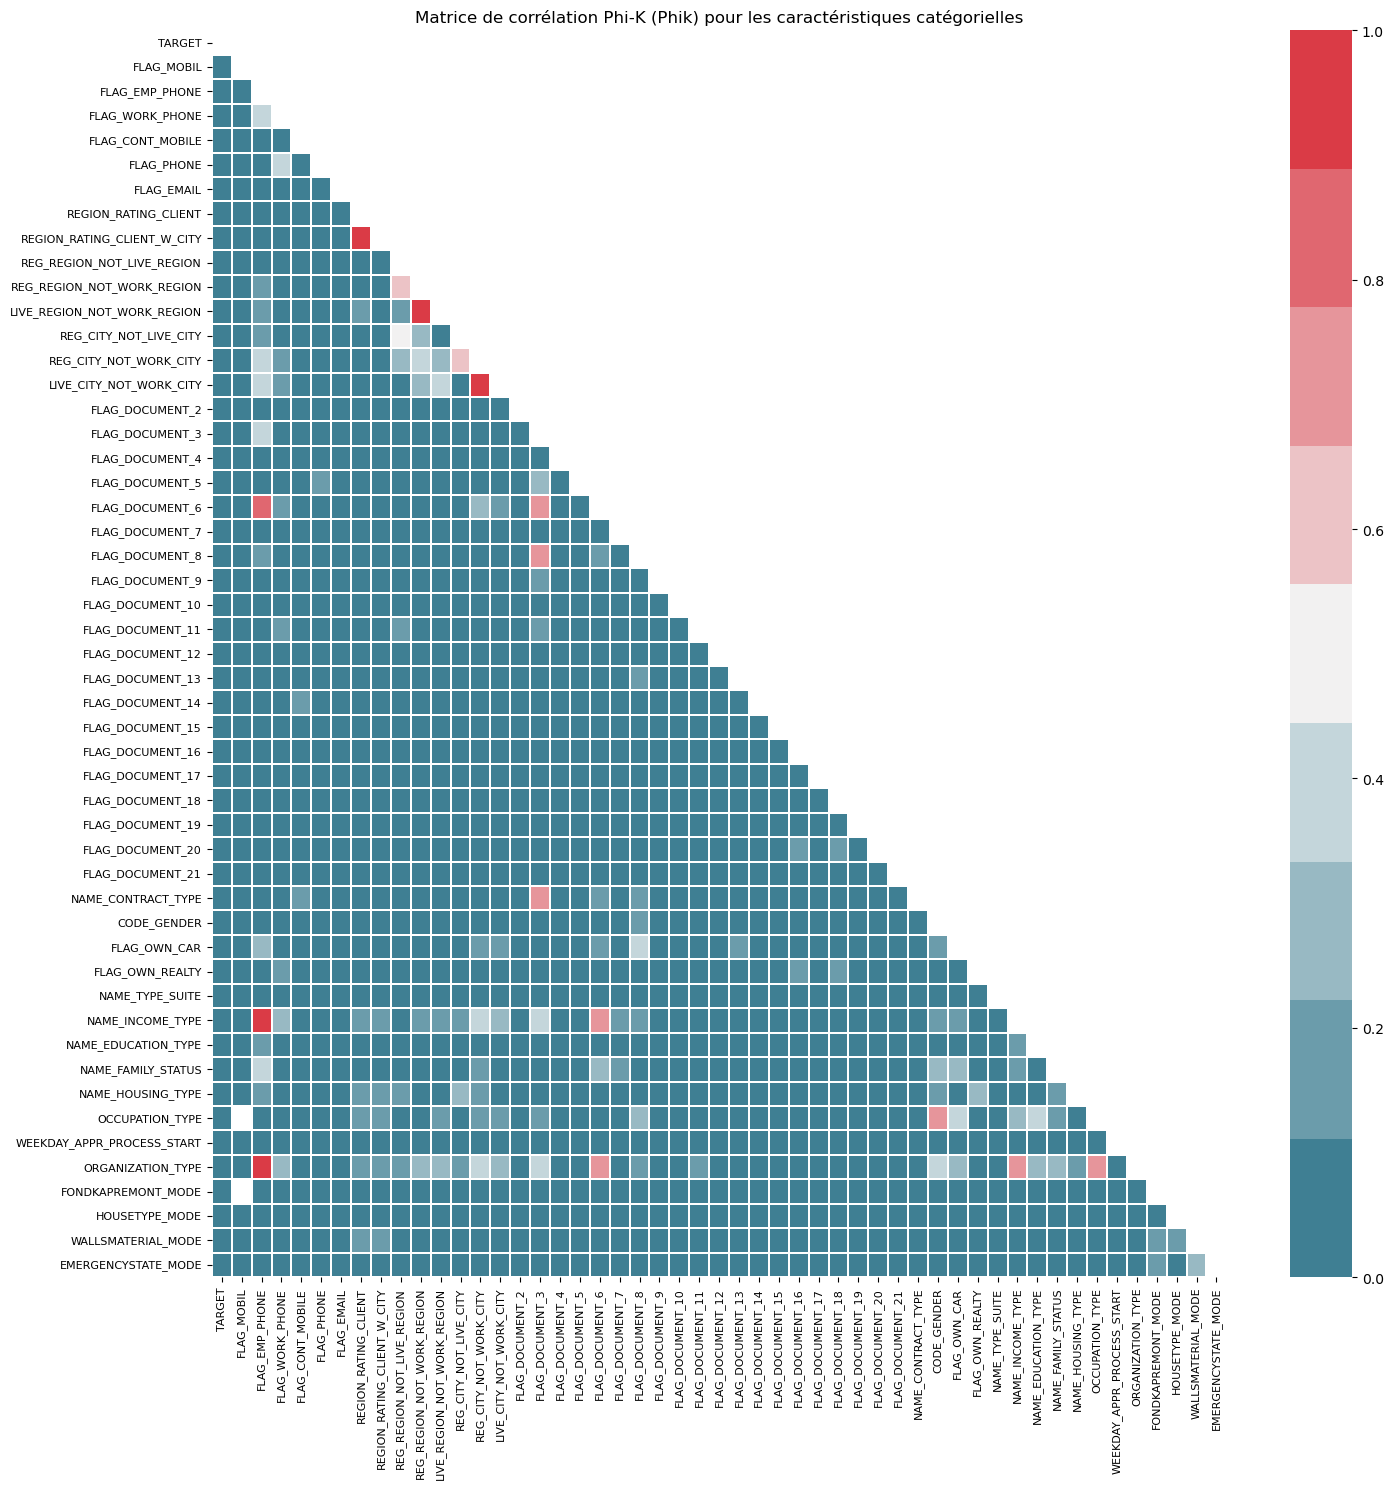

----------------------------------------------------------------------------------------------------
Catégories avec les valeurs les plus élevées de corrélation Phi-K (Phik) avec la variable cible :


,Column Name,Phik-Correlation
43,OCCUPATION_TYPE,0.10
45,ORGANIZATION_TYPE,0.09
39,NAME_INCOME_TYPE,0.08
12,REG_CITY_NOT_WORK_CITY,0.08
1,FLAG_EMP_PHONE,0.07
11,REG_CITY_NOT_LIVE_CITY,0.07
15,FLAG_DOCUMENT_3,0.07
41,NAME_FAMILY_STATUS,0.06
42,NAME_HOUSING_TYPE,0.05
13,LIVE_CITY_NOT_WORK_CITY,0.05


----------------------------------------------------------------------------------------------------
time: 3min 15s (started: 2023-09-19 03:26:32 +02:00)


In [20]:
categorical_columns = ['TARGET','FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
                                   'FLAG_PHONE', 'FLAG_EMAIL','REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY',
                                  'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
                                   'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 
                                'LIVE_CITY_NOT_WORK_CITY'] + ['FLAG_DOCUMENT_' + str(i) for i in range(2,22)] + application_train.dtypes[
                                    application_train.dtypes == 'object'].index.tolist()
plot_phik_matrix(application_train, categorical_columns, figsize = (15,15), fontsize = 8)

_**Observations :**_ Il n'ya pas de corrélation entre les variables catégorielles

#### <font color = "#4AA3A2"> _**Etude la corrélation entre les variables numériques**_

<font color = "b">L'objectif est d'identifier les colonnes numériques hautement corrélées entre elles et à la variables cible. La variable "SK_ID_CURR" n'est pas pertinente, je vais donc la laisser de côté

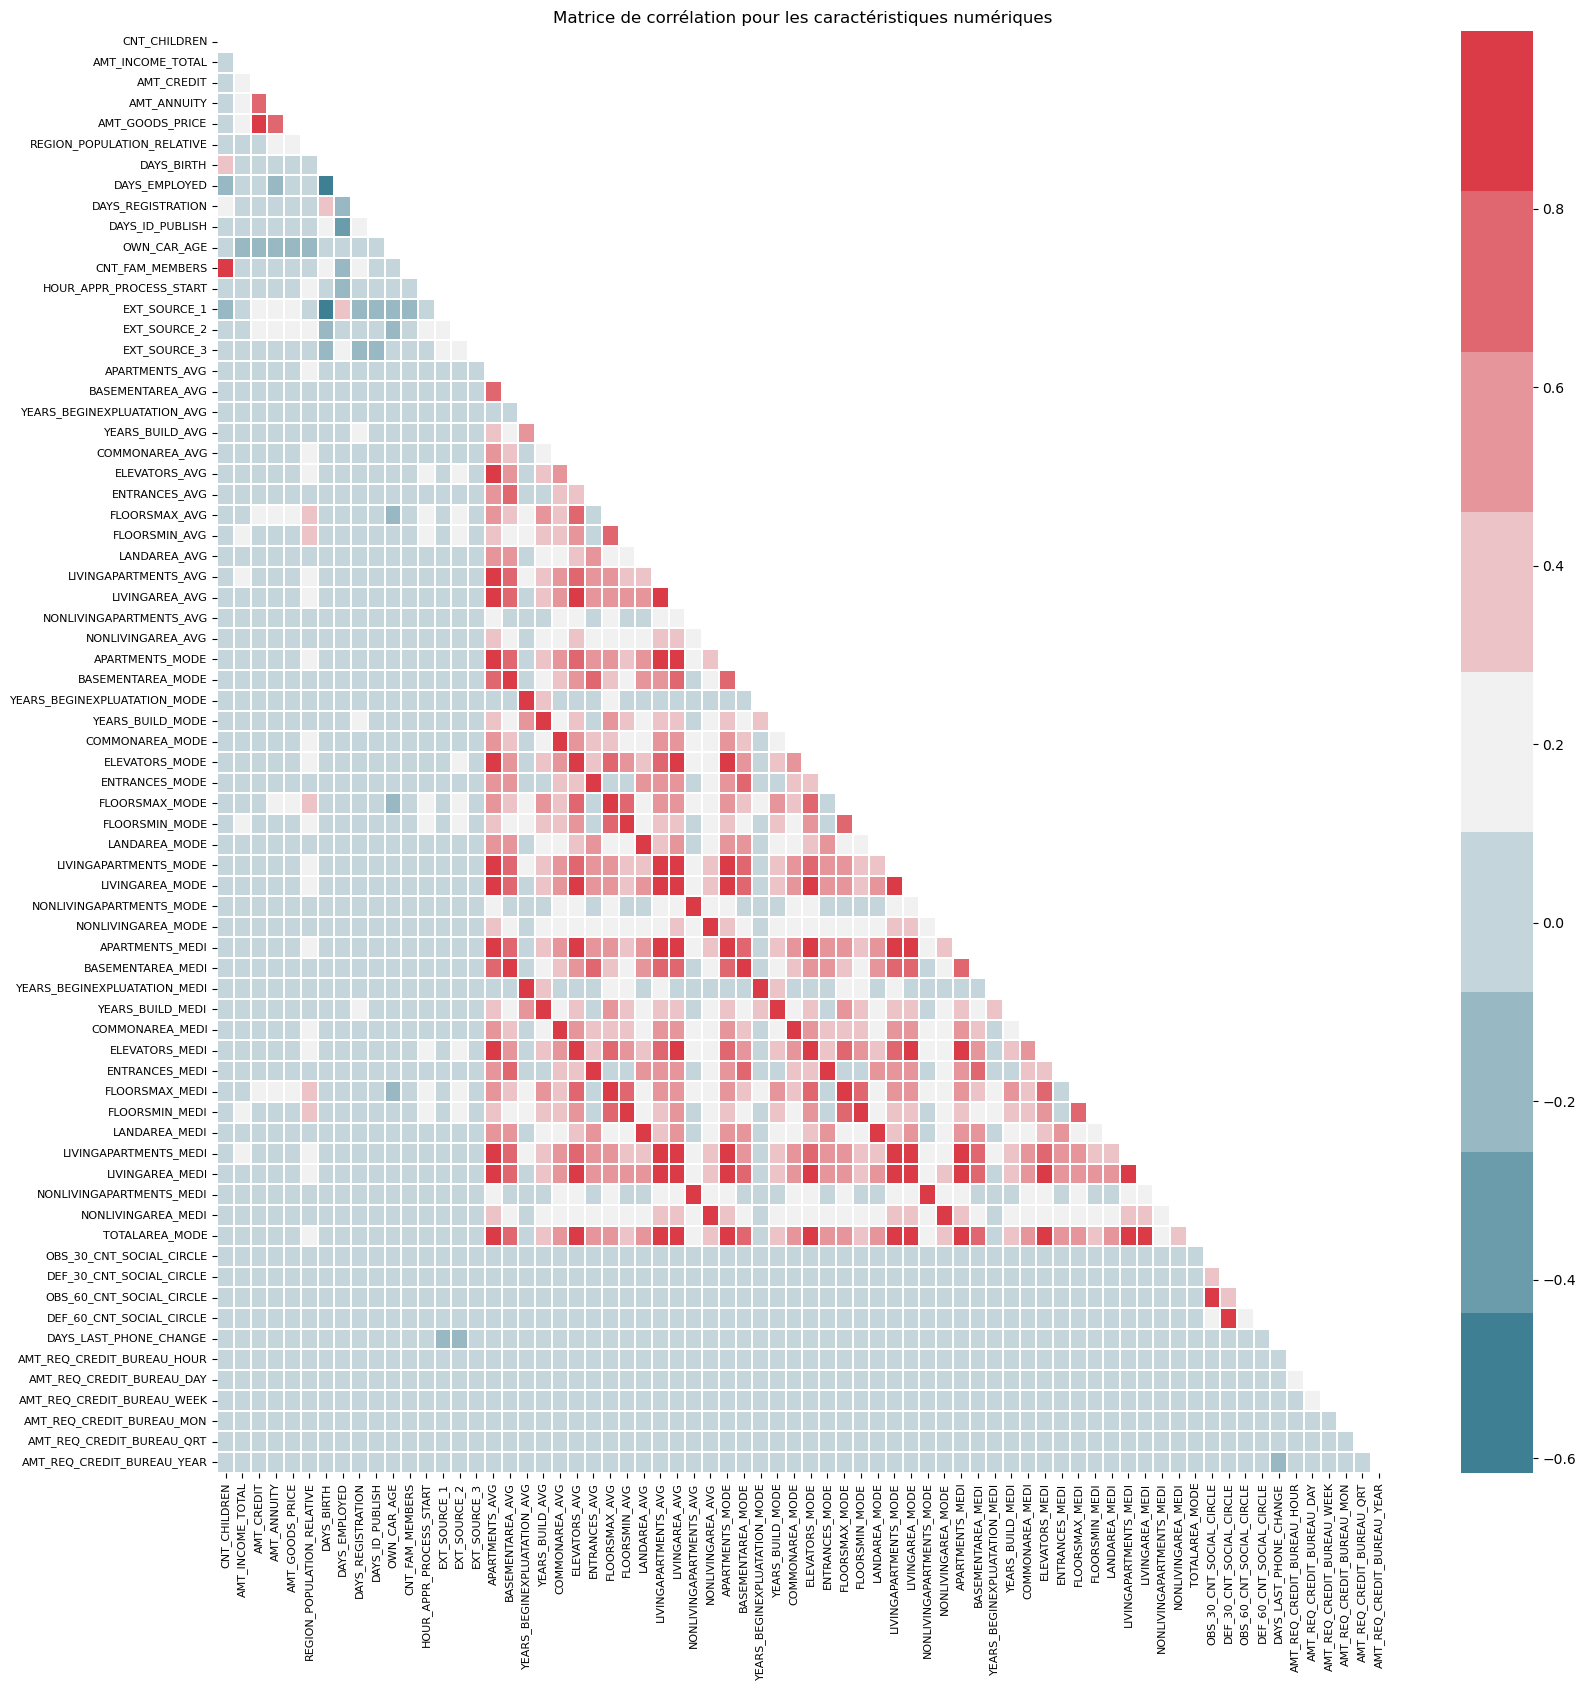

time: 29 s (started: 2023-09-19 03:29:47 +02:00)


In [21]:
columns_to_drop = ['SK_ID_CURR'] + list(set(categorical_columns) - set(['TARGET']))
corr_mat = CorrelationMatrix(application_train, columns_to_drop, figsize = (17,17), fontsize = 8,
                             cmap = palette)
corr_mat.plot_correlation_matrix()

_**Extraction des colonnes ayant les corrélations de Phik les plus élevées par rapport à la variable cible**_

In [22]:
# Calcul des colonnes avec les plus hautes valeurs de corrélation de Phik avec la variable cible
top_corr_target_df = corr_mat.target_top_corr()

# Affichage d'une ligne de séparation pour une meilleure lisibilité
print("-" * 100)

# Message descriptif pour indiquer ce que les résultats représentent
print("Columns with highest values of Phik-correlation with Target Variable are:")

# Affichage du DataFrame contenant les résultats
display(top_corr_target_df)

# Affichage d'une ligne de séparation pour marquer la fin des résultats
print("-" * 100)

interval columns not set, guessing: ['TARGET', 'CNT_CHILDREN']


interval columns not set, guessing: ['TARGET', 'AMT_INCOME_TOTAL']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT']
interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
interval columns not set, guessing: ['TARGET', 'AMT_GOODS_PRICE']
interval columns not set, guessing: ['TARGET', 'REGION_POPULATION_RELATIVE']
interval columns not set, guessing: ['TARGET', 'DAYS_BIRTH']
interval columns not set, guessing: ['TARGET', 'DAYS_EMPLOYED']
interval columns not set, guessing: ['TARGET', 'DAYS_REGISTRATION']
interval columns not set, guessing: ['TARGET', 'DAYS_ID_PUBLISH']
interval columns not set, guessing: ['TARGET', 'OWN_CAR_AGE']
interval columns not set, guessing: ['TARGET', 'CNT_FAM_MEMBERS']
interval columns not set, guessing: ['TARGET', 'HOUR_APPR_PROCESS_START']
interval columns not set, guessing: ['TARGET', 'EXT_SOURCE_1']
interval columns not set, guessing: ['TARGET', 'EXT_SOURCE_2']
interval columns not set, guessing: ['TARGET', 'EXT_SOURCE_3']
interval columns 

,Column Name,Phik-Correlation
15,EXT_SOURCE_3,0.25
13,EXT_SOURCE_1,0.22
14,EXT_SOURCE_2,0.21
6,DAYS_BIRTH,0.10
63,DAYS_LAST_PHONE_CHANGE,0.07
7,DAYS_EMPLOYED,0.07
9,DAYS_ID_PUBLISH,0.07
4,AMT_GOODS_PRICE,0.06
23,FLOORSMAX_AVG,0.06
51,FLOORSMAX_MEDI,0.06


----------------------------------------------------------------------------------------------------
time: 1min 3s (started: 2023-09-19 03:30:16 +02:00)


_**Observations :**_ 
* Il n'ya pas de corrélation importante entre les variables et la variable cible ;
* Il y a également peu de variables coréllées entre elles ;
* Néanmoins, quelques variables présentent de forte corrélation : Ces corrélations sont manifestées sur la carte thermique par des nuances contrastées au milieu de la carte thermique. Ce sont essentiellement les variables liées aux statistiques des appartements.

Les variables fortement inter-coréllées ne sont pas pertinentes pour ce projet, car elles augmentent la complexité temporelle du modèle sans lui ajouter beaucoup de valeur. Par conséquent, je supprimerais les variables inter-corrélées.

#### <font color = "#4AA3A2">_**Analyse de la distribution des variables catégorielles**_

<font color = "#26474E"> _**Distribution de la variable catégorielle NAME_CONTRACT_TYPE**_

In [23]:
# Quelles sont les valeurs de cette colonne ?
print_unique_categories(application_train, 'NAME_CONTRACT_TYPE')

----------------------------------------------------------------------------------------------------
Les catégories uniques de 'NAME_CONTRACT_TYPE' sont :
['Cash loans' 'Revolving loans']
----------------------------------------------------------------------------------------------------
time: 31 ms (started: 2023-09-19 03:31:20 +02:00)


In [24]:
# Tracer le diagramme en secteur pour cette colonne
plot_categorical_variables_pie(application_train, 'NAME_CONTRACT_TYPE', hole = 0.2)

time: 610 ms (started: 2023-09-19 03:31:20 +02:00)


_**Observations :**_
* Le premier camembert représente la répartition globale entre les différents types de prêts: On peut constater que la plupart des prêts contractés par les clients sont des prêts en espèces. Seulement 9,52 % de la population a contracté des prêts renouvelables.
* Le second camembert represente la répartition du pourcentage des clients défaillants : le nombre de personnes en défaut de paiement avec des prêts en espèces (8,35 %) est plus important que le nombre de personnes en défaut de paiement avec des prêts renouvelables (5,48 %).

<font color = "#26474E"> _**Distribution de la variable catégorielle CODE_GENDER**_

Cette variable renseigne les informations sur le sexe des emprunteurs : M pour homme et F pour femme.

In [25]:
# valeurs uniques de cette colonne ?
print_unique_categories(application_train, 'CODE_GENDER')

# Tracer le diagramme en secteur pour cette colonne
plot_categorical_variables_pie(application_train, 'CODE_GENDER', hole = 0.2)

----------------------------------------------------------------------------------------------------
Les catégories uniques de 'CODE_GENDER' sont :
['M' 'F' 'XNA']
----------------------------------------------------------------------------------------------------


time: 157 ms (started: 2023-09-19 03:31:20 +02:00)


_**Observations**_ 

* La première observation montre qu'il y a trois valeurs de sexe. En effet, 4 clients dans la table application_train sont du genre « XNA », ce qui n'a pas beaucoup de sens et pourrais sigifier qu'il s'agit d'une valeur manquante. Puisque ces clients ne sont que au nombre de 4 et appartiennent que à la catégorie des "clients à jour dans leur règlement", je procederais à la suppression de ces 4 lignes (clients).
* Le premier graphe montre les femmes empruntes plus que les hommes : 65,8% de femmes contre 34,2% d'hommes.
* Le deuxième graphe montre que les hommes ont plus du mal à rembourser leur prêt.

Ainsi, on peut dire que les femmes enpruntes plus que les hommes, mais les hommes remboursent plus difficilement leur crédit.

<font color = "#26474E"> _**Distribution de la variable catégorielle FLAG_EMP_PHONE**_

Cette variable est de type booléen. Elle indique si le client a fourni ou non son numéro de téléphone professionnel : ici, 1 signifie Oui et 0 signifie Non.

In [26]:
# valeurs uniques de cette colonne ?
print_unique_categories(application_train, 'FLAG_EMP_PHONE')

# Tracer le diagramme en secteur pour cette colonne
plot_categorical_variables_pie(application_train, 'FLAG_EMP_PHONE', hole = 0.2)

----------------------------------------------------------------------------------------------------
Les catégories uniques de 'FLAG_EMP_PHONE' sont :
[1 0]
----------------------------------------------------------------------------------------------------


time: 63 ms (started: 2023-09-19 03:31:21 +02:00)


_**Observations :**_

On peut constater que la plupart des candidats ne fournissent pas leur numéro de téléphone professionnel (82 %). Par ailleurs, ceux qui fournissent leur numéro de téléphone professionnel rembourse mieux leurs prêts.<br>
On pourrait penser que ceux qui ne fournissent par leur numéro professionnel craignent d'être dérangé sur leur lieu de travail par les services de recouvrement.

<font color = "#26474E"> _**Distribution de la variable catégorielle REGION_RATING_CLIENT_W_CITY**_

Cette variable renseigne la note attribué par _Home Credit_ à chaque client en fonction de sa région selon la qualité des clients. Cette notation prend en compte la Ville dans laquelle réside le client. Il contient des valeurs comprises entre 1 et 3.

In [27]:
# valeurs uniques de cette colonne ?
print_unique_categories(application_train, 'REGION_RATING_CLIENT_W_CITY')

# Tracer le diagramme en secteur pour cette colonne
plot_categorical_variables_pie(application_train, 'REGION_RATING_CLIENT_W_CITY', hole = 0.2)

----------------------------------------------------------------------------------------------------
Les catégories uniques de 'REGION_RATING_CLIENT_W_CITY' sont :
[2 1 3]
----------------------------------------------------------------------------------------------------


time: 94 ms (started: 2023-09-19 03:31:21 +02:00)


_**Observations**_ :

* Avec le premier graphe, on remarque que la plupart des clients (74,6 %) ont une note régionale de 2. Il s'agit de la valeur moyenne. Très peu de région ont une note de 1 (seulement 11,1 %) et certains ont une note de 3 (14,3 %).
* Parmi les défaillants, on constate que la plupart des défaillants ont une note régionale de 3 (11,4 %), ce qui est comparativement plus élevé que les deux autres notes.

La note 3 pourrait alors être un critère important pour l'octroie de crédit.

<font color = "#26474E"> _**Distribution de la variable catégorielle NAME_EDUCATION_TYPE**_

Cette variable décrit le niveau d'éducation des clients.

In [28]:
# valeurs uniques de cette colonne ?
print_unique_categories(application_train, 'NAME_EDUCATION_TYPE', show_counts=True)

# Tracer le diagramme en secteur pour cette colonne
plot_categorical_variables_pie(application_train, 'NAME_EDUCATION_TYPE', hole = 0.2)

----------------------------------------------------------------------------------------------------
Les catégories uniques de 'NAME_EDUCATION_TYPE' sont :
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
----------------------------------------------------------------------------------------------------
Les comptes de chaque catégorie sont :
NAME_EDUCATION_TYPE
Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------


time: 297 ms (started: 2023-09-19 03:31:21 +02:00)


_**Observations :**_

En analysant les graphiques ci-dessus, il en résulte :

 * Environ 71 % des personnes ont fait leurs études seulement jusqu'au secondaire/secondaire spécial, et 24,34 % des clients ont fait des études supérieures. Cela suggère que la plupart des clients/emprunteurs n'ont pas un niveau d'éducation élevé.
* À partir du deuxième graphique, nous voyons que les personnes qui ont fait leurs études jusqu'au secondaire inférieur seulement ont plus du mal avec leurs crédits, le secondaire et le supérieur incomplet ont des tendances similaires.
* Le groupe de personnes ayant fait des études supérieures ont moins du mal avec leurs crédits, ce qui semble logique. Ce pendant, c'est le groupe de clients le moins important en terme d'effectif.

<font color = "#26474E"> _**Distribution de la variable catégorielle OCCUPATION_TYPE**_

Cette variable indique la _**profession**_ du client. Il s'agit d'une information particulièrementutile, car le niveau de revenu d'un client est le premier permettant de prédire si un client sera défaillant ou pas vis à vis de son échéancier.

----------------------------------------------------------------------------------------------------
Les catégories uniques de 'OCCUPATION_TYPE' sont :
['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 'Realty agents' 'Secretaries'
 'IT staff' 'HR staff']
----------------------------------------------------------------------------------------------------
Nombre total de catégories uniques de OCCUPATION_TYPE = 19


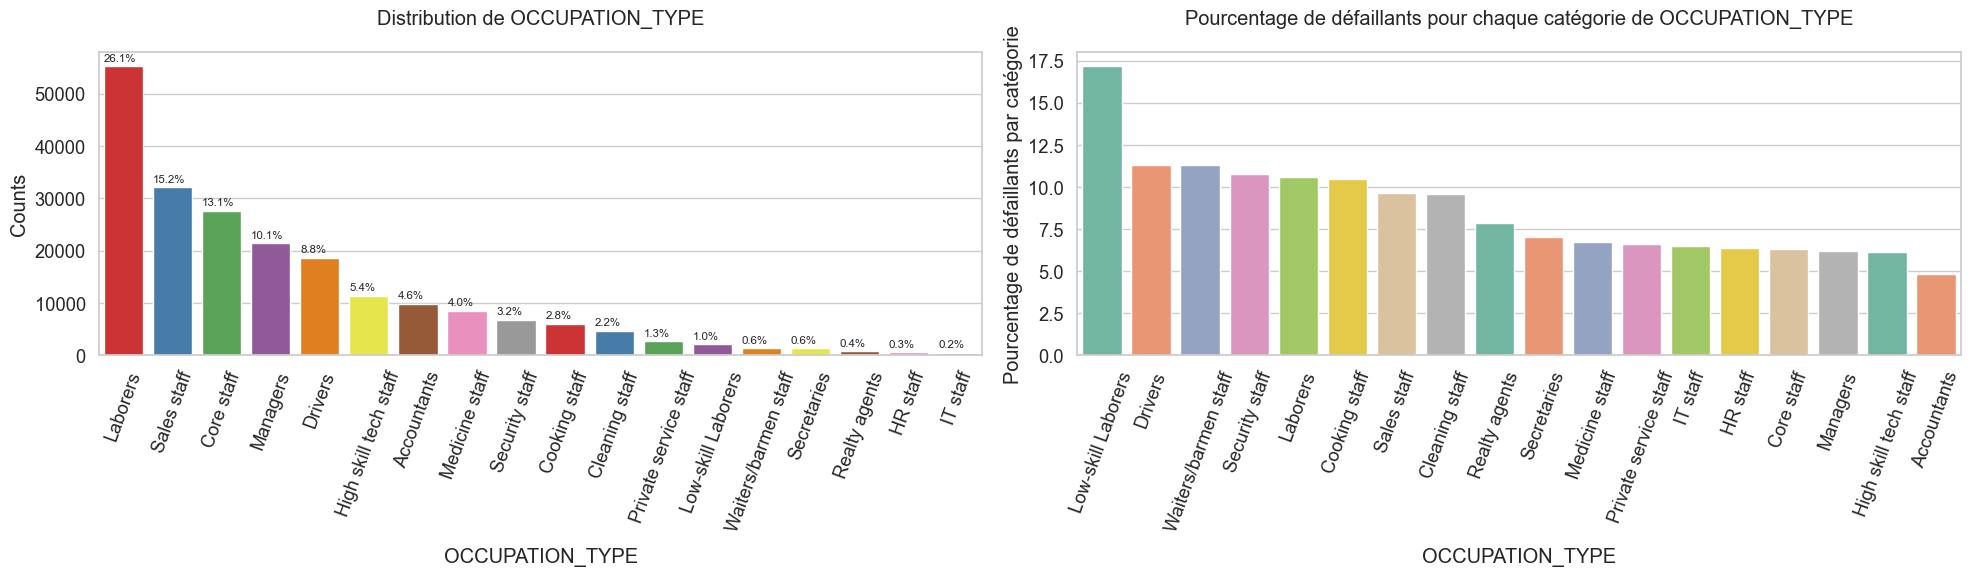

time: 1.28 s (started: 2023-09-19 03:35:10 +02:00)


In [31]:
# valeurs uniques de cette colonne ?
print_unique_categories(application_train, 'OCCUPATION_TYPE')

# Tracer le diagramme en secteur pour cette colonne
plot_categorical_variables_bar(application_train, column_name = 'OCCUPATION_TYPE', figsize = (20,6), rotation = 70)

<font color = "#26474E"> _**Distribution de la variable catégorielle ORGANIZATION_TYPE**_

Tout comme le type de profession, le type d'organisation auquel appartient le client pourrait également être un facteur important pour prédire le risque de non remboursement du crédit par le client. Visualisons les détails de cette variable.

Total Number of categories of ORGANIZATION_TYPE = 58


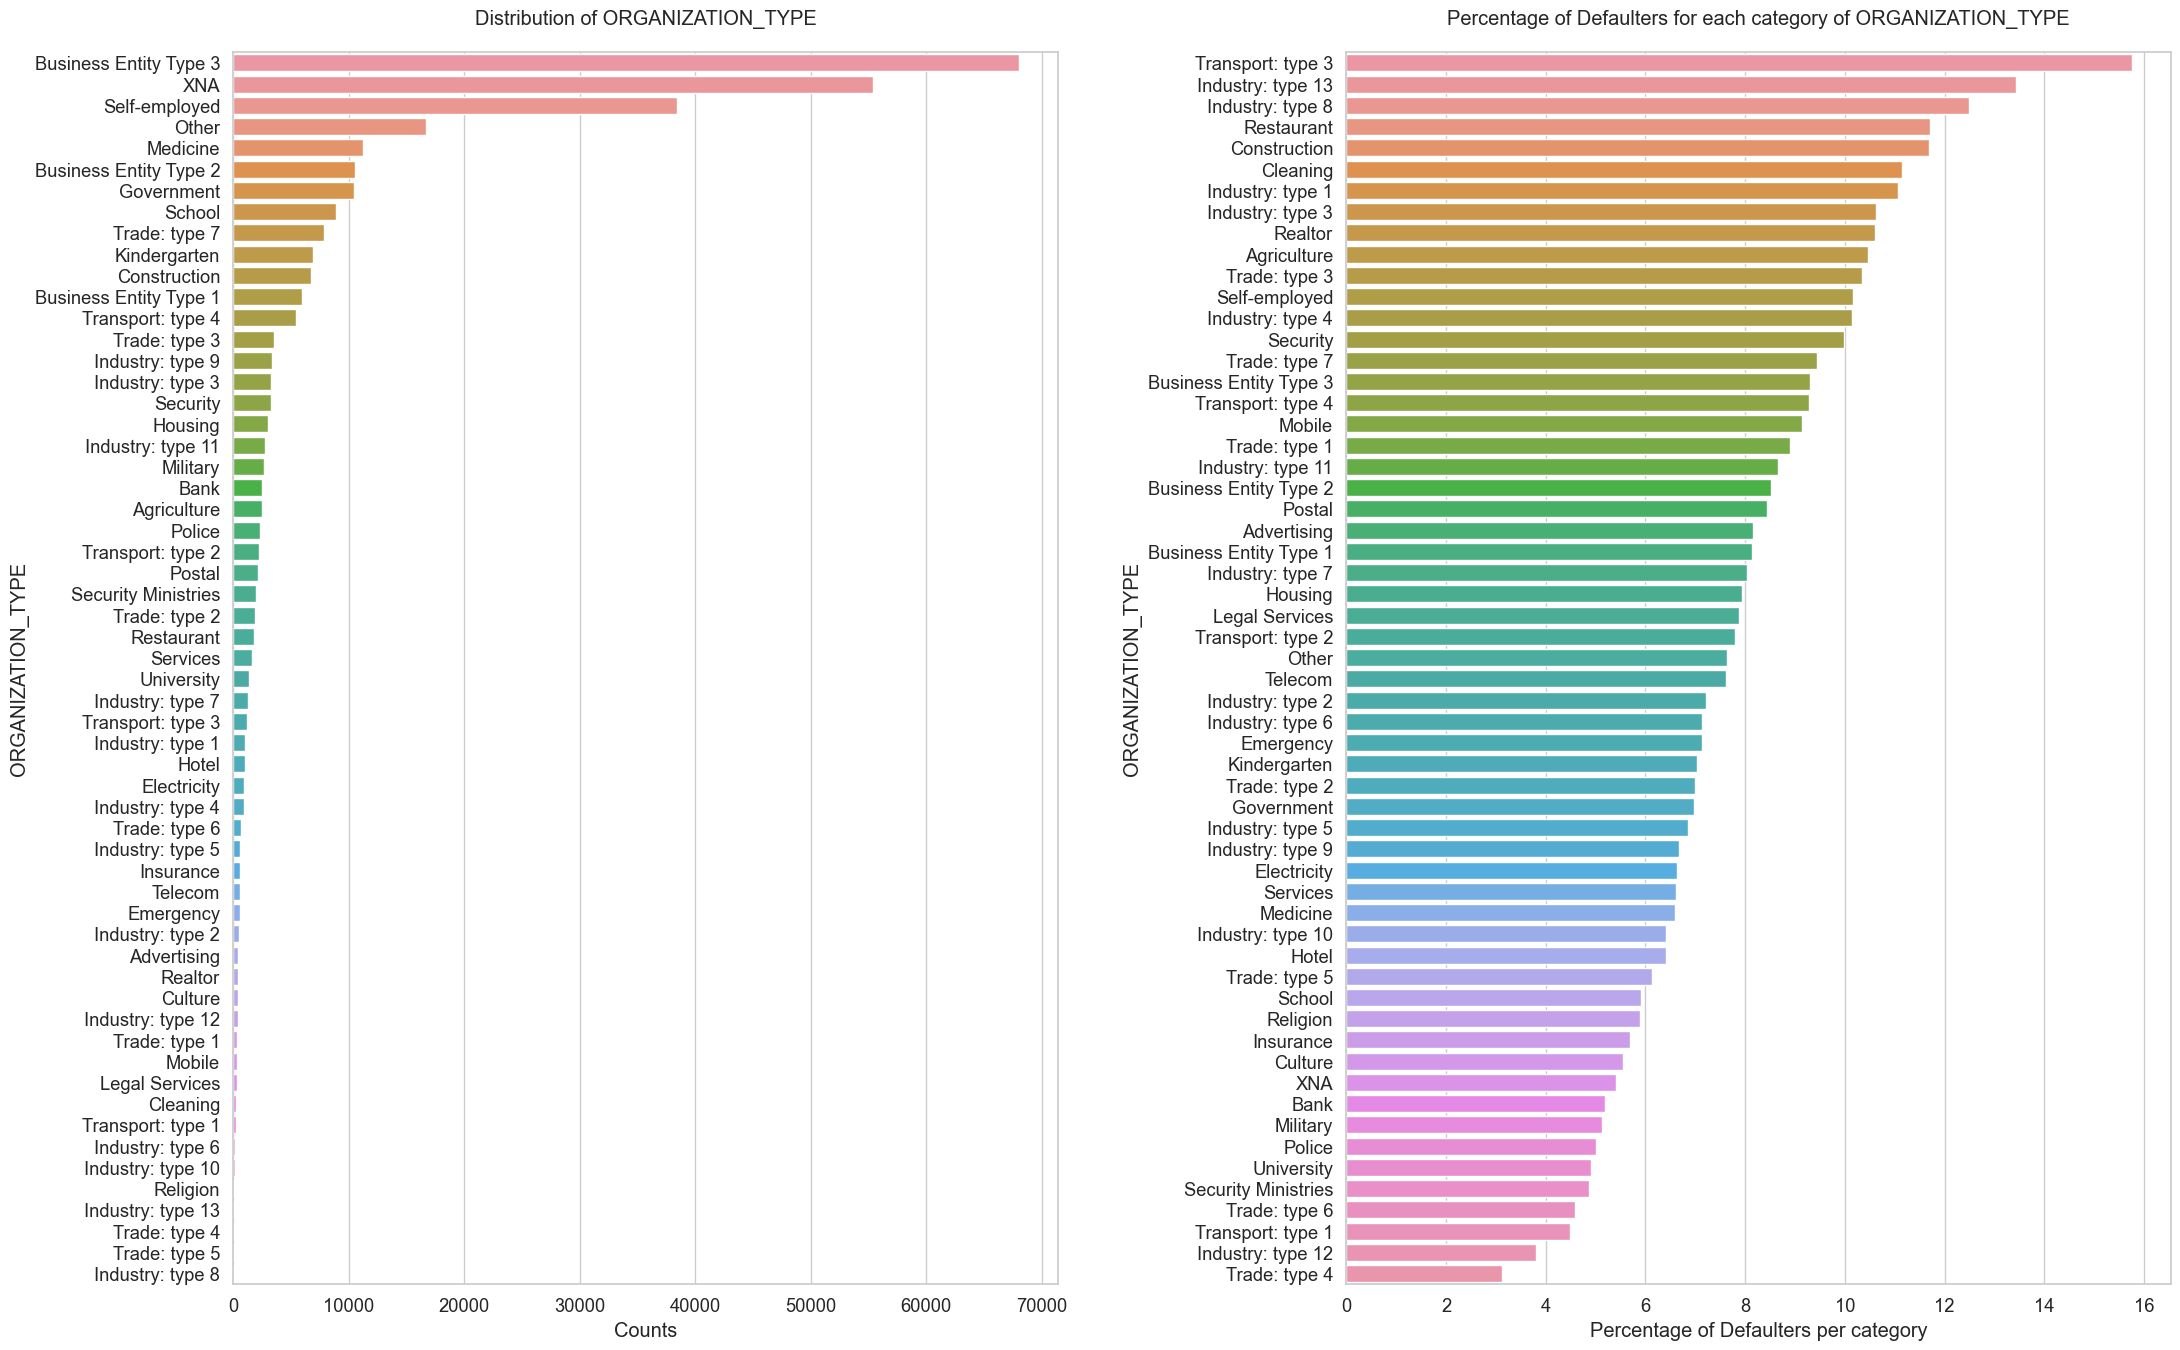

time: 2.02 s (started: 2023-09-19 03:35:22 +02:00)


In [32]:
# Affiche le nombre total de catégories uniques dans la colonne ORGANIZATION_TYPE
print(f"Total Number of categories of ORGANIZATION_TYPE = {len(application_train.ORGANIZATION_TYPE.unique())}")

# Crée une figure pour les graphiques avec une taille de 25x16 pouces
plt.figure(figsize=(25, 16))

# Configure le style du graphique et l'échelle de la police
sns.set(style='whitegrid', font_scale=1.2)

# Ajuste l'espacement entre les sous-graphiques
plt.subplots_adjust(wspace=0.35)

# Crée le premier sous-graphique dans une grille de 1 ligne et 2 colonnes (1,2,1)
plt.subplot(1, 2, 1)

# Compte le nombre d'occurrences de chaque catégorie ORGANIZATION_TYPE et les trie par ordre décroissant
count_organization = application_train.ORGANIZATION_TYPE.value_counts().sort_values(ascending=False)

# Crée un graphique à barres horizontales pour afficher la distribution des catégories ORGANIZATION_TYPE
sns.barplot(x=count_organization, y=count_organization.index)

# Ajoute un titre au graphique
plt.title('Distribution of ORGANIZATION_TYPE', pad=20)

# Ajoute des étiquettes aux axes x et y
plt.xlabel('Counts')
plt.ylabel('ORGANIZATION_TYPE')

# Crée le deuxième sous-graphique dans la même grille (1,2,2)
plt.subplot(1, 2, 2)

# Calcule le pourcentage de défaillants pour chaque catégorie ORGANIZATION_TYPE
percentage_default_per_organization = (application_train[application_train.TARGET == 1].ORGANIZATION_TYPE.value_counts() * 100 / count_organization)

# Supprime les catégories avec des valeurs NaN et les trie par ordre décroissant
percentage_default_per_organization = percentage_default_per_organization.dropna().sort_values(ascending=False)

# Crée un graphique à barres horizontales pour afficher les pourcentages de défaillants par catégorie ORGANIZATION_TYPE
sns.barplot(x=percentage_default_per_organization, y=percentage_default_per_organization.index)

# Ajoute un titre au graphique
plt.title('Percentage of Defaulters for each category of ORGANIZATION_TYPE', pad=20)

# Ajoute des étiquettes aux axes x et y
plt.xlabel('Percentage of Defaulters per category')
plt.ylabel('ORGANIZATION_TYPE')

# Affiche les graphiques
plt.show()

_**Observations :**_
* 58 type d'entreprises sont représentés ici ;
* Le premier graphique montre que la plupart des demandeurs de crédit travaillent dans des organisations de type "Entité commerciale de type 3", "XNA" ou "Travailleur indépendant". Le type d'organisation "XNA" désignerait probablement un type d'organisation non classifié ;
* Le deuxième graphique montre que les candidats appartenant à la catégorie "Transport : type 3" ont la plus forte tendance à la défaillance par rapport aux autres. Ils sont suivis par les organisations de type : "Industrie : type 13", "Industrie : type 8", "Restaurant", "Construction", etc.
* Les organisations qui affichent les taux de défaillance les plus bas sont : "Commerce : type 4", "Industrie : type 12", etc.

Ces numéros de type pourraient également en dire plus sur l'organisation, mais nous ne disposons d'aucune information à ce sujet et nous nous en tiendrons donc uniquement à la dénomination qui nous a été fournie.

<font color = "#26474E"> _**Distribution des variables catégorielles REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY**_

* REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY : ces colonnes indiquent si l'adresse permanente du client correspond ou non à son adresse de contact ou à son adresse professionnelle au niveau régional.
* LIVE_CITY_NOT_WORK_CITY : cette colonne indique si l'adresse permanente du client correspond ou non à son adresse de contact au niveau de la ville.

Ici, 1 indique des adresses différentes et 0 indique des adresses identiques.

----------------------------------------------------------------------------------------------------
Nombre total de catégories uniques de REG_CITY_NOT_LIVE_CITY = 2


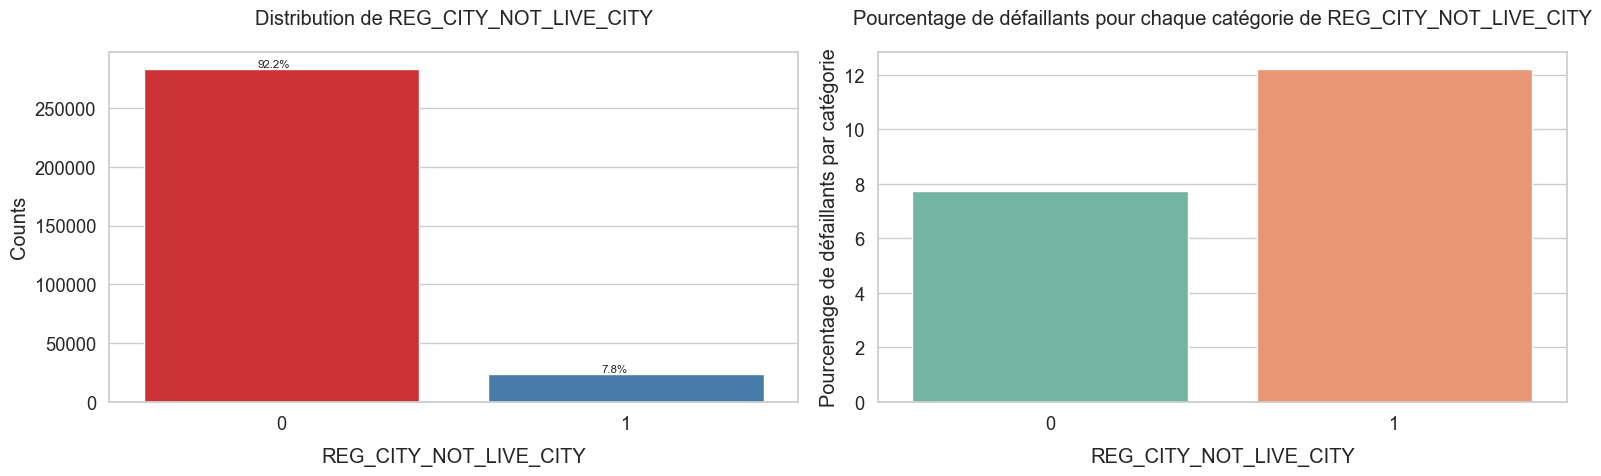

----------------------------------------------------------------------------------------------------
Nombre total de catégories uniques de REG_CITY_NOT_WORK_CITY = 2


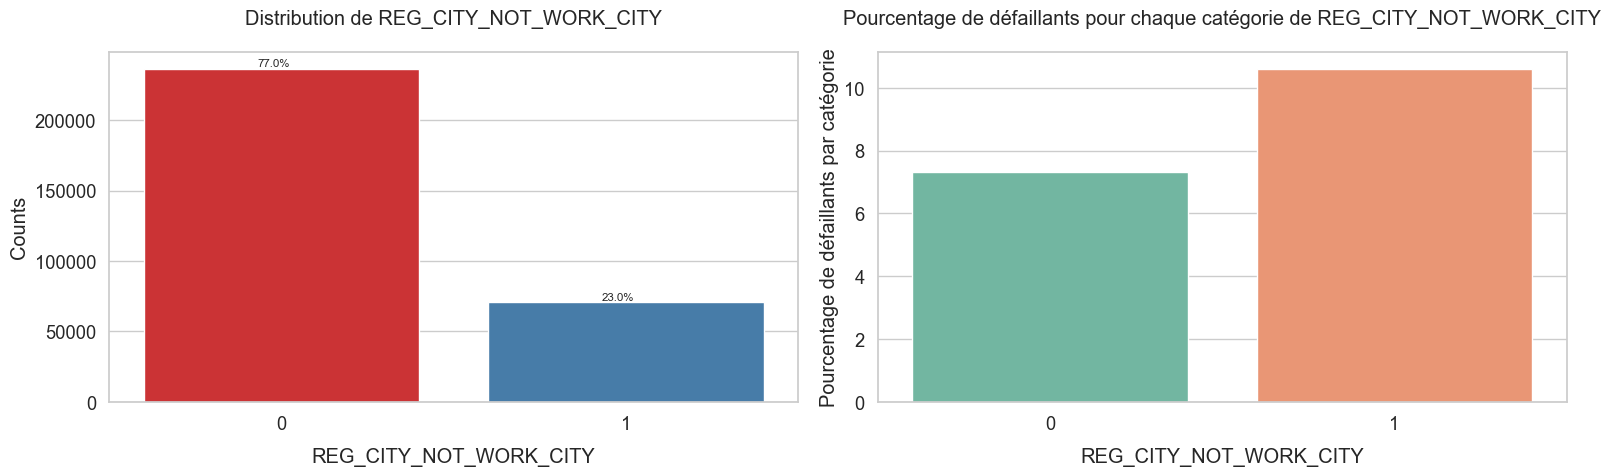

----------------------------------------------------------------------------------------------------
Nombre total de catégories uniques de LIVE_CITY_NOT_WORK_CITY = 2


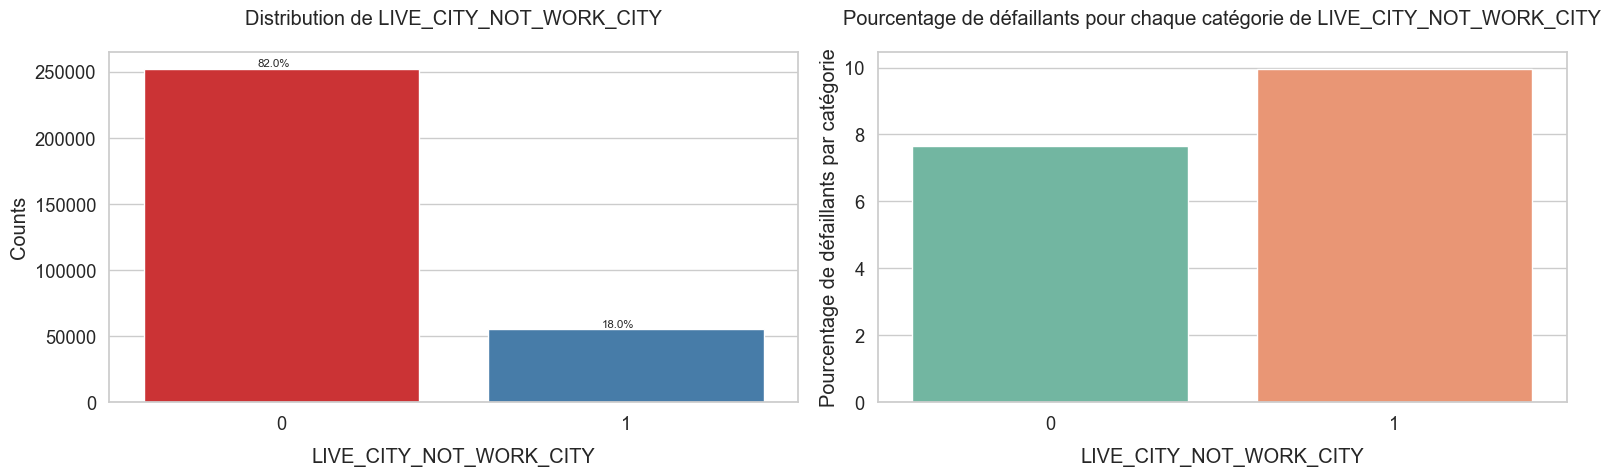

time: 1.48 s (started: 2023-09-19 03:35:24 +02:00)


In [33]:
# Affiche une ligne de séparation pour délimiter les étapes
print('-'*100)

# Appelle la fonction plot_categorical_variables_bar pour la colonne 'REG_CITY_NOT_LIVE_CITY'
plot_categorical_variables_bar(application_train, column_name='REG_CITY_NOT_LIVE_CITY', figsize=(16, 5), horizontal_adjust=0.33)

print('-'*100)

# Appelle la fonction plot_categorical_variables_bar pour la colonne 'REG_CITY_NOT_WORK_CITY'
plot_categorical_variables_bar(application_train, column_name='REG_CITY_NOT_WORK_CITY', figsize=(16, 5), horizontal_adjust=0.33)

print('-'*100)

# Appelle la fonction plot_categorical_variables_bar pour la colonne 'LIVE_CITY_NOT_WORK_CITY'
plot_categorical_variables_bar(application_train, column_name='LIVE_CITY_NOT_WORK_CITY', figsize=(16, 5), horizontal_adjust=0.33)

_**Observations :**_

Les trois graphiques ci-dessus permettent de tirer les conclusions suivantes :

* Sur l'ensemble des clients, il n'y a qu'une minorité de clients dont les adresses ne correspondent pas.
* Tout d'abord, seuls 7,52 % des clients ont une adresse permanente différente de leur adresse de contact au niveau régional.
* Ensuite, environ 23,05 % des bénéficiaires ont une adresse permanente différente de l'adresse de leur lieu de travail au niveau régional. Ce chiffre plus élevé s'explique par le fait qu'il est possible que ces bénéficiaires travaillent dans une région différente de celle de leur adresse permanente.
* Enfin, environ 17,96 % des bénéficiaires ont une adresse permanente différente de leur adresse de contact au niveau de la ville.
* Si nous examinons les caractéristiques de défaillance, nous constatons que la tendance à la défaillance est maximale chez les bénéficiaires dont l'adresse permanente et l'adresse de contact sont différentes au niveau de la région, suivie de l'adresse permanente et de l'adresse de travail différentes et enfin de l'adresse permanente et de l'adresse de contact différentes au niveau de la ville.

Dans tous les cas, on constate que la tendance à la défaillance des bénéficiaires ayant des adresses différentes est plus élevée que celle des bénéficiaires ayant la même adresse. Cela pourrait signifier que, quelque part, cette différence d'adresse peut suggérer un risque de défaillance.

<font color = "#26474E"> _**Distribution de la variable catégorielle FLAG_DOCUMENT_3**_

Cette colonne contient l'indicateur d'un document qui doit être soumis par le demandeur. Sa valeur est 0 si le client a fourni le document et 1 si ce n'est pas le cas.

Nombre total de catégories uniques de FLAG_DOCUMENT_3 = 2


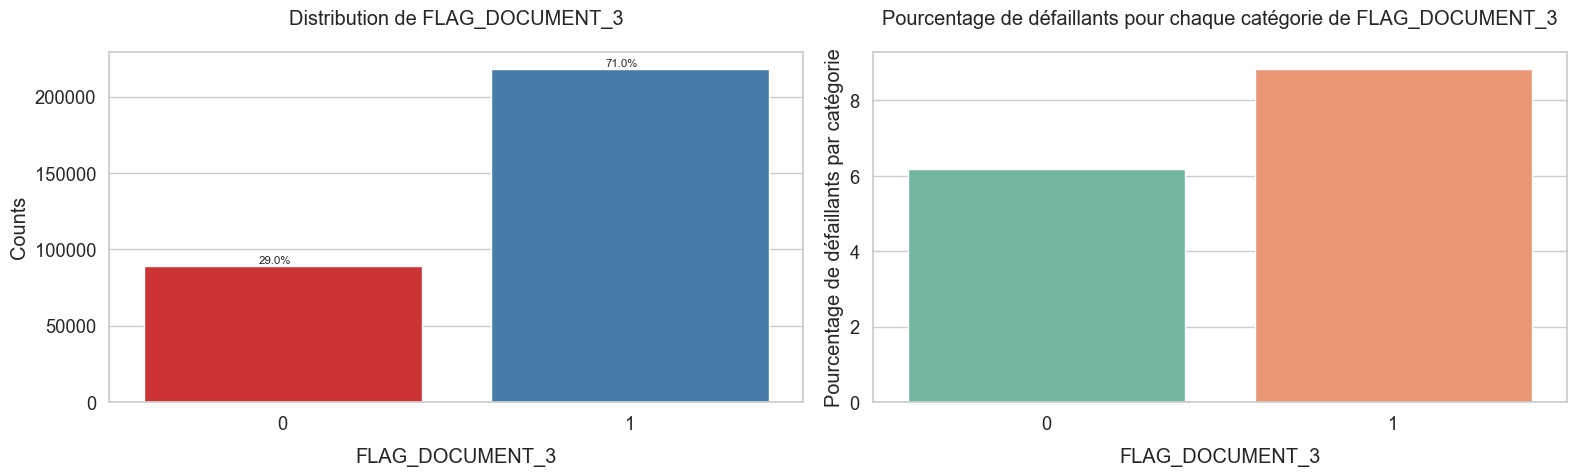

time: 437 ms (started: 2023-09-19 03:35:26 +02:00)


In [34]:
plot_categorical_variables_bar(application_train, column_name = 'FLAG_DOCUMENT_3', figsize = (16, 5), horizontal_adjust = 0.33)

_**Observations**_

Les graphiques ci-dessus montrent que :

* La plupart des clients n'ont pas fourni ce document (~71%) et que seuls 29% l'ont fait.
* Ceux qui l'ont fourni ont un taux de défaillance plus élevé que ceux qui ne l'ont pas fourni. Cela signifie que les candidats qui ont fourni le Document_3 ont tendance à être plus défaillants que ceux qui ne l'ont pas fourni.

S'agirirait-il du _"BPL certificate"_ (Below Poverty Line certificate") ? Un certificat délivré généralement par le gouvernement servant à identifier les personnes ou les familles qui se trouvent en dessous du seuil de pauvreté établi par le gouvernement. Comme le quotient familiale délivré par _CAF_ en France.

#### <font color = "#4AA3A2">_**Analyse de la distribution des variables numériques**_

<font color = "#AFA4CE"> _**Distribution de la variable continue "Âge du demandeur"**_<font color = "b">

Pour l'ensemble de données donné, l'âge est indiqué en jours, ce qui peut être plus difficile à interpréter. Créons une variable latente pour stocker les âges en années, ce qui sera plus facile à analyser et à interpréter.

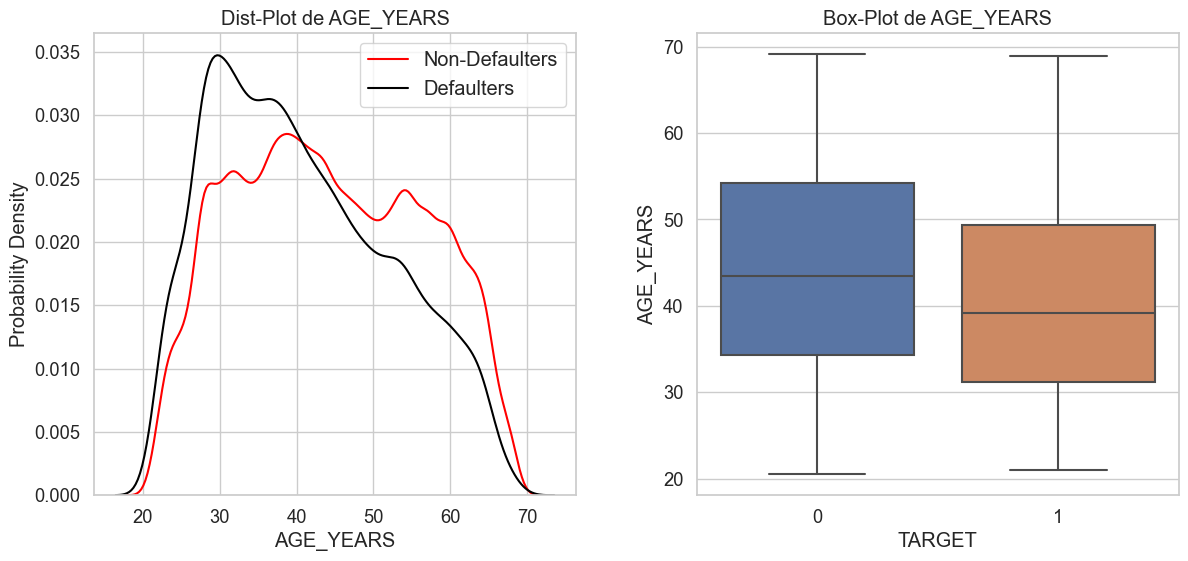

time: 2.47 s (started: 2023-09-19 03:35:26 +02:00)


In [35]:
# On crée une nouvelle colonne 'AGE_YEARS' dans le DataFrame 'application_train'.
# Cette colonne sera calculée en transformant les jours de naissance (DAYS_BIRTH) en années et en prenant la valeur absolue.
application_train['AGE_YEARS'] = application_train['DAYS_BIRTH'] * -1 / 365

# Ensuite, nous utilisons une fonction 'plot_continuous_variables' pour afficher des visualisations des données de la colonne 'AGE_YEARS'.
plot_continuous_variables(application_train, 'AGE_YEARS', plots=['distplot', 'box'], histogram=False)

# Une fois les visualisations affichées, nous utilisons '_' pour ignorer la valeur de retour,
# car cette ligne de code supprime la colonne 'AGE_YEARS' du DataFrame 'application_train'.
_ = application_train.pop('AGE_YEARS')

_**Observations :**_

_Remarque : la couleur rouge est l'équivalent du target "O" dans le tracé de la boîte à moustache_
* Le diagramme de distribution nous permet d'observer le pic d'âge des personnes en défaut de paiement qui sont proches de 30 ans. En outre, à ce stade, les personnes qui ne sont pas en défaut de paiement ont une densité de probabilité assez faible. Une autre chose à noter est que la courbe de l'âge des mauvais payeurs est légèrement plus étiré à gauche de celui des bons payeurs. Cela signifie que les mauvais payeurs sont généralement plus jeunes que les bons payeurs.
* La fonction de distribution cumulative montre également que la probabilité d'un défaut de paiement est plus élevée que celle d'un bon remboursement.
* Les boîtes à moustaches permettent de renforcer notre appréciation. L'âge des défaillants est généralement inférieur à celui des  clients en règle. Tous les quantiles de l'âge des défaillant sont inférieurs à ceux des non-défaillants. La valeur du 75e percentile des non-défaillants est d'environ 54 ans, tandis que celle des défaillants est proche de 49 ans.

Conclusion : Les personnes défaillantes sont généralement plus jeunes que les non-défaillantes.

<font color = "#AFA4CE"> _**Distribution de la variable continue DAYS_EMPLOYED**_<font color = "b">

Cette caractéristique indique le nombre de jours à partir du jour de la demande que le demandeur a été employé. Pour faciliter l’interprétation, je vais convertir les jours en années.

Création d'une nouvelle colonne 'YEARS_EMPLOYED' dans le DataFrame 'application_train'. Cette colonne sera calculée en transformant les jours d'emploi (DAYS_EMPLOYED) en années et en prenant la valeur absolue.

In [36]:
application_train['YEARS_EMPLOYED'] = application_train.DAYS_EMPLOYED * -1 / 365

time: 0 ns (started: 2023-09-19 03:35:28 +02:00)


----------------------------------------------------------------------------------------------------
La valeur du 0e percentile de 'DAYS_EMPLOYED' est -17912.0
La valeur du 25e percentile de 'DAYS_EMPLOYED' est -2760.0
La valeur du 50e percentile de 'DAYS_EMPLOYED' est -1213.0
La valeur du 75e percentile de 'DAYS_EMPLOYED' est -289.0
La valeur du 90e percentile de 'DAYS_EMPLOYED' est 365243.0
La valeur du 92e percentile de 'DAYS_EMPLOYED' est 365243.0
La valeur du 94e percentile de 'DAYS_EMPLOYED' est 365243.0
La valeur du 96e percentile de 'DAYS_EMPLOYED' est 365243.0
La valeur du 98e percentile de 'DAYS_EMPLOYED' est 365243.0
La valeur du 100e percentile de 'DAYS_EMPLOYED' est 365243.0
----------------------------------------------------------------------------------------------------


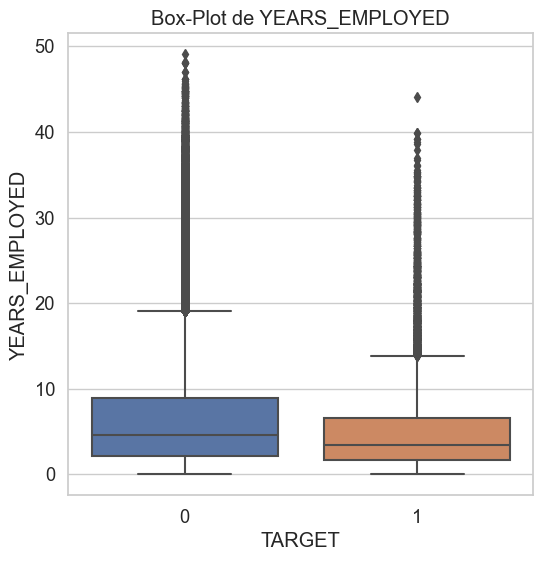

time: 906 ms (started: 2023-09-19 03:35:28 +02:00)


In [37]:
# Affichage des percentiles de la colonne 'DAYS_EMPLOYED' à l'aide de la fonction 'print_percentiles'.
print_percentiles(application_train, 'DAYS_EMPLOYED')

# Affichage des boîte à moustaches à l'aide de la fonction 'plot_continuous_variables'.
plot_continuous_variables(application_train, 'YEARS_EMPLOYED', plots=['box'], scale_limits=[0, 70], figsize=(6, 6))

# ignorer la valeur de retour
_ = application_train.pop('YEARS_EMPLOYED')

_**Observations :**_

* La colonne DAYS_EMPLOYED contient des points de données erronés avec des valeurs 365243 jours (1.000 ans). Il s'agit apparemment de valeurs erronées/non sensibles.
* Les défaillants ont un nombre d'années d'emploi inférieur à celui des non-défaillants. Tous les 25e, 50e et 75e quantiles des défaillants sont inférieurs à ceux des non-défaillants.

<font color = "#AFA4CE"> _**Distribution de la variable continue DAYS_ID_PUBLISH**_<font color = "b">

Cette colonne indique combien de jours depuis le jour de l'enregistrement le client a changé la pièce d'identité avec laquelle il a demandé le prêt.

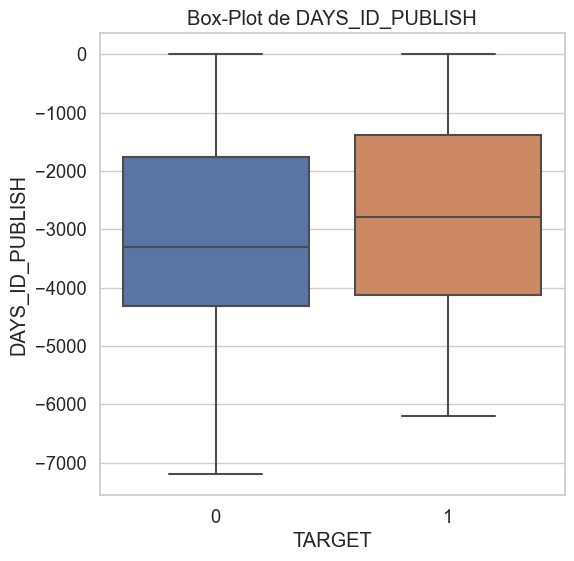

time: 671 ms (started: 2023-09-19 03:35:29 +02:00)


In [38]:
# Affichage des boîte à moustaches à l'aide de la fonction 'plot_continuous_variables'
plot_continuous_variables(application_train, 'DAYS_ID_PUBLISH', plots = ['box'], figsize = (6, 6))

<font color = "#AFA4CE"> _**Distribution de la variable continue EXT_SOURCES**_<font color = "b">

Il existe trois colonnes EXT_SOURCES, qui contiennent des valeurs comprises entre 0 et 1. Ce sont des scores normalisés provenant de différentes sources.

----------------------------------------------------------------------------------------------------


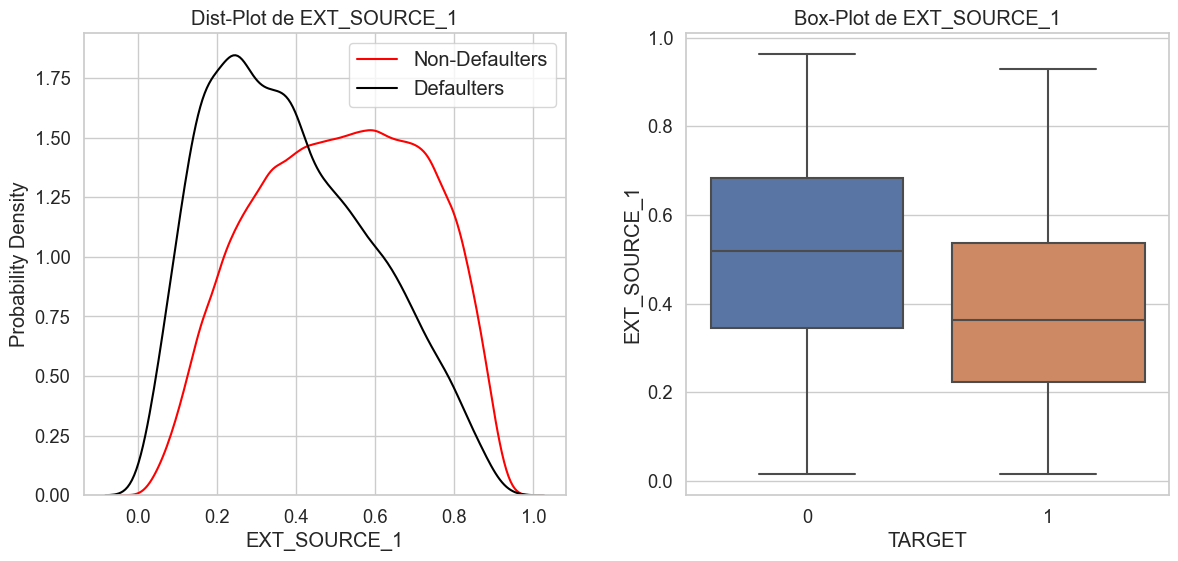

----------------------------------------------------------------------------------------------------


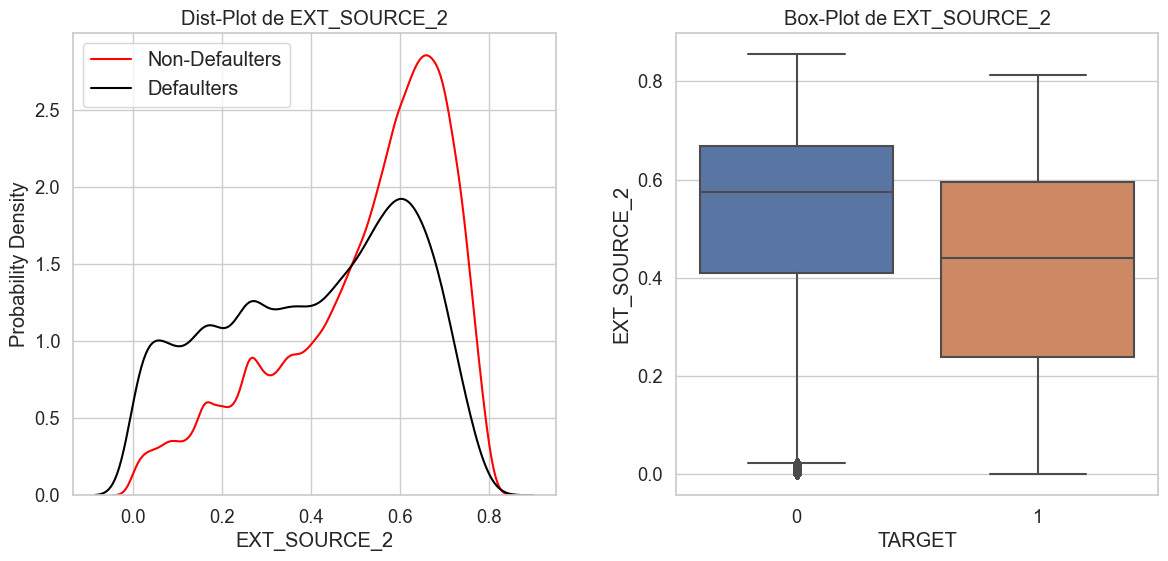

----------------------------------------------------------------------------------------------------


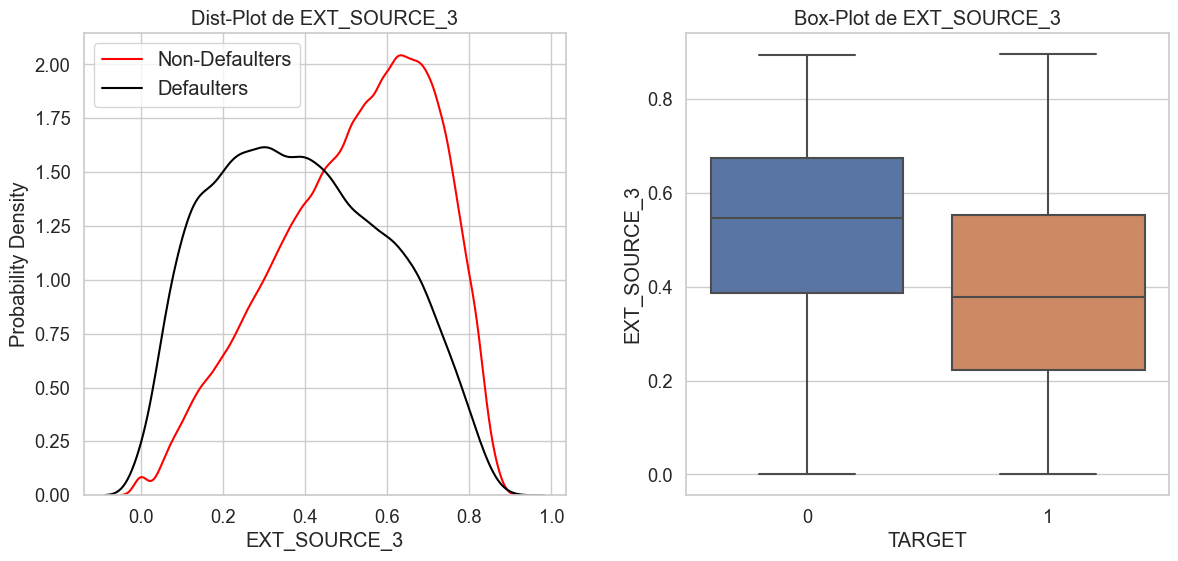

----------------------------------------------------------------------------------------------------
time: 11 s (started: 2023-09-19 03:35:30 +02:00)


In [39]:
print('-'*100)
plot_continuous_variables(application_train, 'EXT_SOURCE_1', plots = ['distplot', 'box'], histogram=False)
print('-'*100)
plot_continuous_variables(application_train, 'EXT_SOURCE_2', plots = ['distplot', 'box'], histogram=False)
print('-'*100)
plot_continuous_variables(application_train, 'EXT_SOURCE_3', plots = ['distplot', 'box'], histogram=False)
print('-'*100)

_**Observations :**_

* Si nous regardons les diagrammes en boîte, nous pouvons clairement voir une tendance similaire pour les trois colonnes EXT_SOURCE, à savoir que les défaillants ont tendance à avoir des valeurs considérablement inférieures.
* Cette tendance est également visible avec les courbes. Les non-défaillants affichent un pic plus élevé aux valeurs EXT_SOURCE élevées, et les densités de probabilité sont très faibles pour les valeurs faibles. Cela implique que les non-défaillants ont généralement des valeurs élevées de ces scores.
* Il est intéressant de noter que la valeur médiane des défaillants est presque égale ou inférieure aux valeurs du 25e percentile des non-défaillants.
* Les colonnes EXT_SOURCE_1 et EXT_SOURCE_3 ont tendance à montrer une meilleure séparabilité par rapport à EXT_SOURCE_2.<br>
Ces 3 fonctionnalités semblent être les meilleures pour séparer linéairement les défaillants et les non-défaillants parmi toutes les fonctionnalités jusqu'à présent.

<font color = "#AFA4CE"> _**Distribution des variables continue FLOORSMAX_AVG et FLOORSMIN_MODE**_<font color = "b">

Ces colonnes décrivent les scores normalisés de moyenne du nombre d'étages dans le bâtiment du client et le mode.

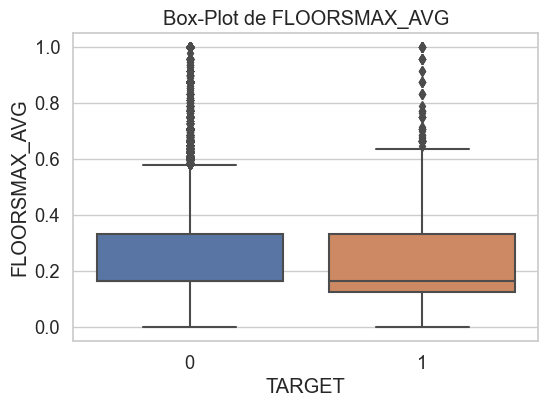

----------------------------------------------------------------------------------------------------


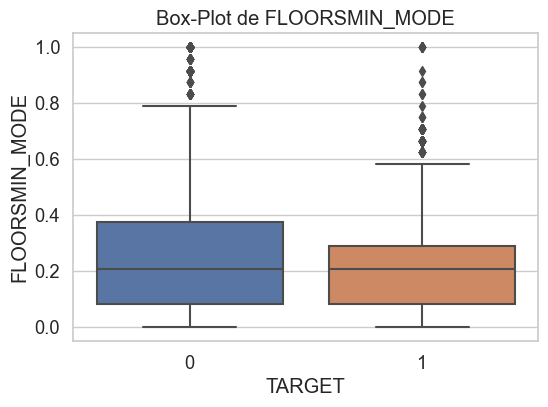

time: 2.94 s (started: 2023-09-19 03:35:41 +02:00)


In [40]:
# FLOORSMAX_AVG
plot_continuous_variables(application_train, 'FLOORSMAX_AVG', plots = ['box'], figsize = (6,4))
print('-'*100)
# FLOORSMIN_MODE
plot_continuous_variables(application_train, 'FLOORSMIN_MODE', plots = ['box'], figsize = (6,4))

_**Observations :**_

Des graphiques ci-dessus, nous pouvons tirer les enseignements suivants :
* Les défaillants ont une valeur médiane de la fonctionnalité FLOORSMAX_AVG inférieure à celle des non-défaillants. Les valeurs du 75e percentile des défaillants et des non-défaillants sont plus ou moins les mêmes, mais la valeur du 25e percentile des non-défaillants est presque supérieure à la médiane des défaillants, cela pourrait donc être une caractéristique importante.
* Les non-défaillants ont également tendance à afficher une valeur de FLLORSMIN_MODE plus élevée que les défaillants. La valeur du 75e centile des non-défaillants est nettement supérieure à la valeur du 75e centile des défaillants.

#### <font color = "#5784BA"> **2.3. Analyse du dataset bureau_balance** <font color = "b">

Ce tableau comprend l'historique mensuel pour chacun des crédits précédents que le client avait contracté auprès des institutions financières autres que Home Credit.

#### <font color = "#4AA3A2"> _**Description des données**_

In [41]:
print(f'Le tableau bureau_balance a pour dimension: {bureau_balance.shape}')
print('-'*100)
print(f'Nombre de valeurs manquantes dans le  bureau_balance: {bureau_balance.shape[0] - bureau_balance.duplicated().shape[0]}')
print('-'*100)

# Affichage des 5 premiéres lignes du tableau bureau_balance
display(bureau_balance.head(5))

Le tableau bureau_balance a pour dimension: (27299925, 3)
----------------------------------------------------------------------------------------------------


Nombre de valeurs manquantes dans le  bureau_balance: 0
----------------------------------------------------------------------------------------------------


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


time: 24.9 s (started: 2023-09-19 03:35:44 +02:00)


In [42]:
print("-"*100)
print(f'Le nombre de valeurs uniques SK_ID_BUREAU dans le tableau bureau_balance est: {len(bureau_balance.SK_ID_BUREAU.unique())}')
print('-'*100)
print(f'Le nombre de valeurs uniques pour le STATUS est: {len(bureau_balance.STATUS.unique())}')
print(f"Ces valeurs uniques sont :\n{bureau_balance.STATUS.unique()}")
print('-'*100)
print(f"Nombre maximum de mois en fonction du solde mensuel : {np.abs(bureau_balance.MONTHS_BALANCE.min())}")
print('-'*100)

----------------------------------------------------------------------------------------------------


Le nombre de valeurs uniques SK_ID_BUREAU dans le tableau bureau_balance est: 817395
----------------------------------------------------------------------------------------------------
Le nombre de valeurs uniques pour le STATUS est: 8
Ces valeurs uniques sont :
['C' '0' 'X' '1' '2' '3' '5' '4']
----------------------------------------------------------------------------------------------------
Nombre maximum de mois en fonction du solde mensuel : 96
----------------------------------------------------------------------------------------------------
time: 8.53 s (started: 2023-09-19 03:36:09 +02:00)


In [43]:
# Recherche des valeurs manquantes
plot_nan_percent(nan_df_create(bureau_balance), 'bureau_balance')

Le DataFrame bureau_balance ne contient pas de valeurs manquantes.
time: 2.78 s (started: 2023-09-19 03:36:18 +02:00)


_**Observations :**_
* La table bureau_balance.csv contient environ 27,29 millions de lignes et 3 colonnes.
* Ce tableau contient le statut mensuel de chacun des prêts précédents pour un demandeur particulier signalé par le département du bureau de crédit.
* Il existe 8 valeurs uniques pour le STATUS qui sont codées. Chacun d’eux a une signification particulière : 
    - C signifie fermé ;
    - X signifie statut inconnu ;
    - 0 signifie pas de DPD ;
    - 1 signifie maximum pendant le mois entre 1 et 30 ;
    - 2 signifie DPD 31-60,
    - 3 à 5 signifie respectivement DPD 120+, vendu, radié.
* Le solde du mois le plus ancien dont nous disposons est le statut remontant à 96 mois, c'est-à-dire que le statut a été fourni jusqu'à 8 ans d'historique pour les prêts pour lesquels ceux-ci existent.

#### <font color = "#5784BA"> **2.4. Analyse du dataset previous_application** <font color = "b">

Ce tableau contient les données statiques du prêt précédent que le client avait chez Home Credit.

#### <font color = "#4AA3A2"> _**Description des données**_

In [44]:
print(f'Dimension du tableau previous_application : {previous_application.shape}')
print('-'*100)
print(f'Le nombre de valeurs uniques dans le champ SK_ID_PREV dans previous_application est: {len(previous_application.SK_ID_PREV.unique())}')
print(f'Le nombre de valeurs uniques dans le champ SK_ID_CURR dans previous_application est: {len(previous_application.SK_ID_CURR.unique())}')
print('-'*100)
print(f"Nombre d'éléments SK_ID_CURR se chevauchant dans application_train and previous_application : {len(set(application_train.SK_ID_CURR.unique()).intersection(set(previous_application.SK_ID_CURR.unique())))}")
print(f"Nombre d'éléments SK_ID_CURR se chevauchant dans application_test and previous_application : {len(set(application_test.SK_ID_CURR.unique()).intersection(set(previous_application.SK_ID_CURR.unique())))}")
print('-'*100)
print(f'Nombre de doublons dans previous_application: {previous_application.shape[0] - previous_application.duplicated().shape[0]}')
print('-'*100)

# Affichage des 5 premiéres lignes du tableau previous_application
display(previous_application.head(5))

Dimension du tableau previous_application : (1670214, 37)
----------------------------------------------------------------------------------------------------


Le nombre de valeurs uniques dans le champ SK_ID_PREV dans previous_application est: 1670214
Le nombre de valeurs uniques dans le champ SK_ID_CURR dans previous_application est: 338857
----------------------------------------------------------------------------------------------------
Nombre d'éléments SK_ID_CURR se chevauchant dans application_train and previous_application : 291057
Nombre d'éléments SK_ID_CURR se chevauchant dans application_test and previous_application : 47800
----------------------------------------------------------------------------------------------------
Nombre de doublons dans previous_application: 0
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.43,17145.00,17145.00,0.00,17145.00,SATURDAY,15,Y,1,0.00,0.18,0.87,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.00,middle,POS mobile with interest,365243.00,-42.00,300.00,-42.00,-37.00,0.00
1,2802425,108129,Cash loans,25188.62,607500.00,679671.00,NaN,607500.00,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.00,low_action,Cash X-Sell: low,365243.00,-134.00,916.00,365243.00,365243.00,1.00
2,2523466,122040,Cash loans,15060.74,112500.00,136444.50,NaN,112500.00,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.00,high,Cash X-Sell: high,365243.00,-271.00,59.00,365243.00,365243.00,1.00
3,2819243,176158,Cash loans,47041.33,450000.00,470790.00,NaN,450000.00,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.00,middle,Cash X-Sell: middle,365243.00,-482.00,-152.00,-182.00,-177.00,1.00
4,1784265,202054,Cash loans,31924.40,337500.00,404055.00,NaN,337500.00,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.00,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


time: 11.8 s (started: 2023-09-19 03:36:21 +02:00)


_Recherche des valeurs manquantes :_<br>
Je vais créer un nouveau DataFrame "previous_application_nan" en utilisant la fonction "nan_df_create". Ce dataframe répertorira les valeurs manquantes dans "previous_application".

In [45]:
# Recherche des valeurs manquantes
previous_application_nan = nan_df_create(previous_application)

# Visualisation graphique des colonnes contenant des valeurs manquantes
plot_nan_percent(previous_application_nan, 'previous_application')

# Suppression du DataFrame 'previous_application_nan' de la mémoire
del previous_application_nan

time: 2.19 s (started: 2023-09-19 03:36:32 +02:00)


_**Observations :**_
* La table previous_application comprend 1,67 million de lignes au total. Chaque ligne correspond à chacun des prêts précédents que le client a contractés précédemment auprès de Home Credit Group. Il est possible pour qu'un ait plusieurs prêts antérieurs auprès de Home Credit Group.
* Il y a 37 colonnes dans previous_application, qui contiennent les détails du prêt précédent.
* Il y a 338.000 SK_ID_CURR uniques dans previous_application, dont 291.000 correspondent aux SK_ID_CURR de application_train et 47.8000 correspondent aux SK_ID_CURR de application_test.
* Il y a 16 colonnes sur les 37 colonnes qui contiennent des valeurs NaN.
* Deux de ces colonnes ont 99,64 % de valeurs manquantes, ce qui est très élevé, il faudra trouver un moyen intelligent de gérer ces valeurs NaN. Car, à ce stade il faudrait mieux ne négliger aucune fonctionnalité.
* Outre ces deux colonnes, le reste des colonnes contient également plus de 40 % de valeurs NaN, à l'exception de 5 colonnes.

#### <font color = "#4AA3A2"> _**Fusion de TARGET de la table application_train vers la table previous_application**_

In [46]:
print("-"*100)
print("Fusion de TARGET avec la table previous_application")
prev_merged = application_train.iloc[:,:2].merge(previous_application, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Fusion de TARGET avec la table previous_application
----------------------------------------------------------------------------------------------------
time: 8.41 s (started: 2023-09-19 03:36:35 +02:00)


_**Corrélation pour les données fusionnées**_

_Corrélation phik (entre variables catégorielles)_

----------------------------------------------------------------------------------------------------


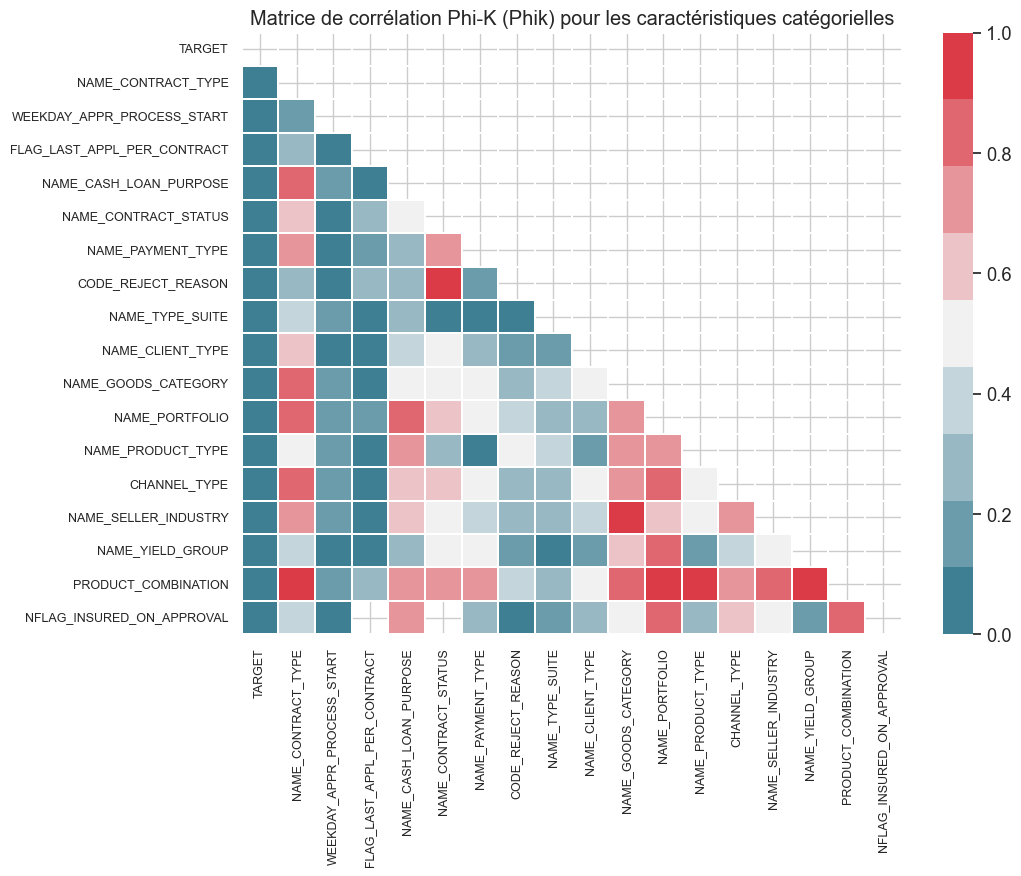

----------------------------------------------------------------------------------------------------
Catégories avec les valeurs les plus élevées de corrélation Phi-K (Phik) avec la variable cible :


,Column Name,Phik-Correlation
4,NAME_CONTRACT_STATUS,0.09
15,PRODUCT_COMBINATION,0.06
6,CODE_REJECT_REASON,0.06
0,NAME_CONTRACT_TYPE,0.05
12,CHANNEL_TYPE,0.05
9,NAME_GOODS_CATEGORY,0.04
3,NAME_CASH_LOAN_PURPOSE,0.04
5,NAME_PAYMENT_TYPE,0.04
13,NAME_SELLER_INDUSTRY,0.04
14,NAME_YIELD_GROUP,0.03


----------------------------------------------------------------------------------------------------
time: 2min 6s (started: 2023-09-19 03:36:43 +02:00)


In [47]:
# Sélection des colonnes à inclure dans l'analyse avec PHIK
cols_for_phik = ['TARGET'] + prev_merged.dtypes[prev_merged.dtypes == 'object'].index.tolist() + ['NFLAG_INSURED_ON_APPROVAL']

# Appel de la fonction 'plot_phik_matrix' pour générer une matrice de PHIK
plot_phik_matrix(prev_merged, cols_for_phik, cmap=palette, figsize=(11, 9), fontsize=9)

_**Observations :**_
* La variable PRODUCT_COMBINATION montre une association avec de nombreuses autres variables telles que NAME_CONTRACT_TYPE, NAME_PRODUCT_TYPE, NAME_PORTFOLIO, etc.
* La variable NAME_GOODS_CATEGORY est également fortement associée à NAME_SELLER_INDUSTRY.
* Les variables NAME_CONTRACT_STATUS, PRODUCT_COMBINATION, CODE_REJECT_REASON sont parmi les variables associées les plus élevées et nécessiteraient une analyse plus approfondie.

_Corrélation entre variables numériques_

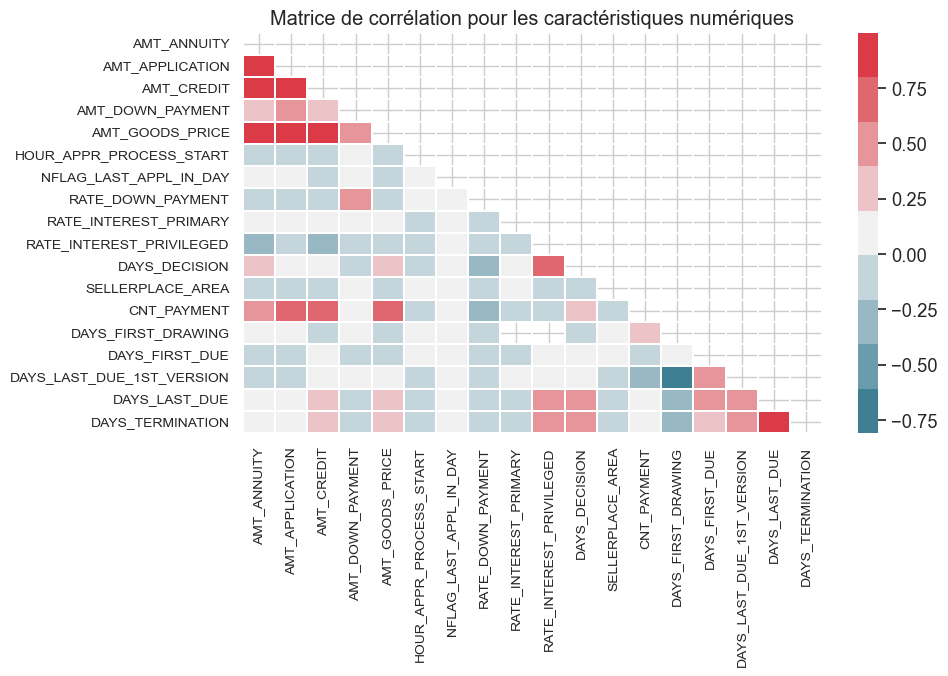

time: 11.4 s (started: 2023-09-19 03:38:50 +02:00)


In [48]:
corr_mat = CorrelationMatrix(prev_merged, ['SK_ID_CURR','SK_ID_PREV','NFLAG_INSURED_ON_APPROVAL'], cmap = palette, figsize = (10,7))
corr_mat.plot_correlation_matrix()

In [49]:
# Visualisation des colonnes avec la corrélation la plus élevée avec la variable cible de la table previous_applications
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Les colonnes les plus corrélées avec la variable cible sont:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']


interval columns not set, guessing: ['TARGET', 'AMT_APPLICATION']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT']
interval columns not set, guessing: ['TARGET', 'AMT_DOWN_PAYMENT']
interval columns not set, guessing: ['TARGET', 'AMT_GOODS_PRICE']
interval columns not set, guessing: ['TARGET', 'HOUR_APPR_PROCESS_START']
interval columns not set, guessing: ['TARGET', 'NFLAG_LAST_APPL_IN_DAY']
interval columns not set, guessing: ['TARGET', 'RATE_DOWN_PAYMENT']
interval columns not set, guessing: ['TARGET', 'RATE_INTEREST_PRIMARY']
interval columns not set, guessing: ['TARGET', 'RATE_INTEREST_PRIVILEGED']
interval columns not set, guessing: ['TARGET', 'DAYS_DECISION']
interval columns not set, guessing: ['TARGET', 'SELLERPLACE_AREA']
interval columns not set, guessing: ['TARGET', 'CNT_PAYMENT']
interval columns not set, guessing: ['TARGET', 'DAYS_FIRST_DRAWING']
interval columns not set, guessing: ['TARGET', 'DAYS_FIRST_DUE']
interval columns not set, guessing: ['TARGET', 'DAY

,Column Name,Phik-Correlation
12,CNT_PAYMENT,0.06
10,DAYS_DECISION,0.05
13,DAYS_FIRST_DRAWING,0.05
7,RATE_DOWN_PAYMENT,0.04
5,HOUR_APPR_PROCESS_START,0.04
9,RATE_INTEREST_PRIVILEGED,0.03
15,DAYS_LAST_DUE_1ST_VERSION,0.03
16,DAYS_LAST_DUE,0.03
17,DAYS_TERMINATION,0.03
0,AMT_ANNUITY,0.01


----------------------------------------------------------------------------------------------------
time: 1min 8s (started: 2023-09-19 03:39:02 +02:00)


_**Observations :**_
* À partir de la carte thermique, nous pouvons voir certaines variables hautement corrélées qui ont une couleur plus foncée.
* La forte corrélation est particulièrement observée pour les variables :
    - DAYS_TERMINATION et DAYS_LAST_DUE
    - AMT_CREDIT et AMT_APPLICATION
    - AMT_APPLICATION et AMT_GOODS_PRICE
    - AMT_CREDIT et AMT_ANNUITY
    - AMT_ANNUITY et AMT_CREDIT
    - AMT_CREDIT et AMT_GOODS_PRICE
* Nous pouvons également voir que les fonctionnalités ne montrent pas particulièrement une forte corrélation avec la variable cible. Cela implique qu'il n'y a pas beaucoup de relation linéaire directe entre la "Target" et les autres variables.

#### <font color = "#4AA3A2">_**Analyse de la distribution des variables catégorielles**_ <font color = "b">
_A présent, analysons quelques variables catégorielles de la table previous_application._

<font color = "#AFA4CE"> _**Distribution de la variable continue NAME_CONTRACT_TYPE**_<font color = "b">

Cette colonne décrit le type de Contrat du prêt précédent avec le Groupe Crédit Logement.

----------------------------------------------------------------------------------------------------
Les catégories uniques de 'NAME_CONTRACT_TYPE' sont :
['Consumer loans' 'Cash loans' 'Revolving loans' nan 'XNA']
----------------------------------------------------------------------------------------------------
Les comptes de chaque catégorie sont :
NAME_CONTRACT_TYPE
Cash loans         626764
Consumer loans     625256
Revolving loans    161368
XNA                   313
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
Nombre total de catégories uniques de NAME_CONTRACT_TYPE = 5


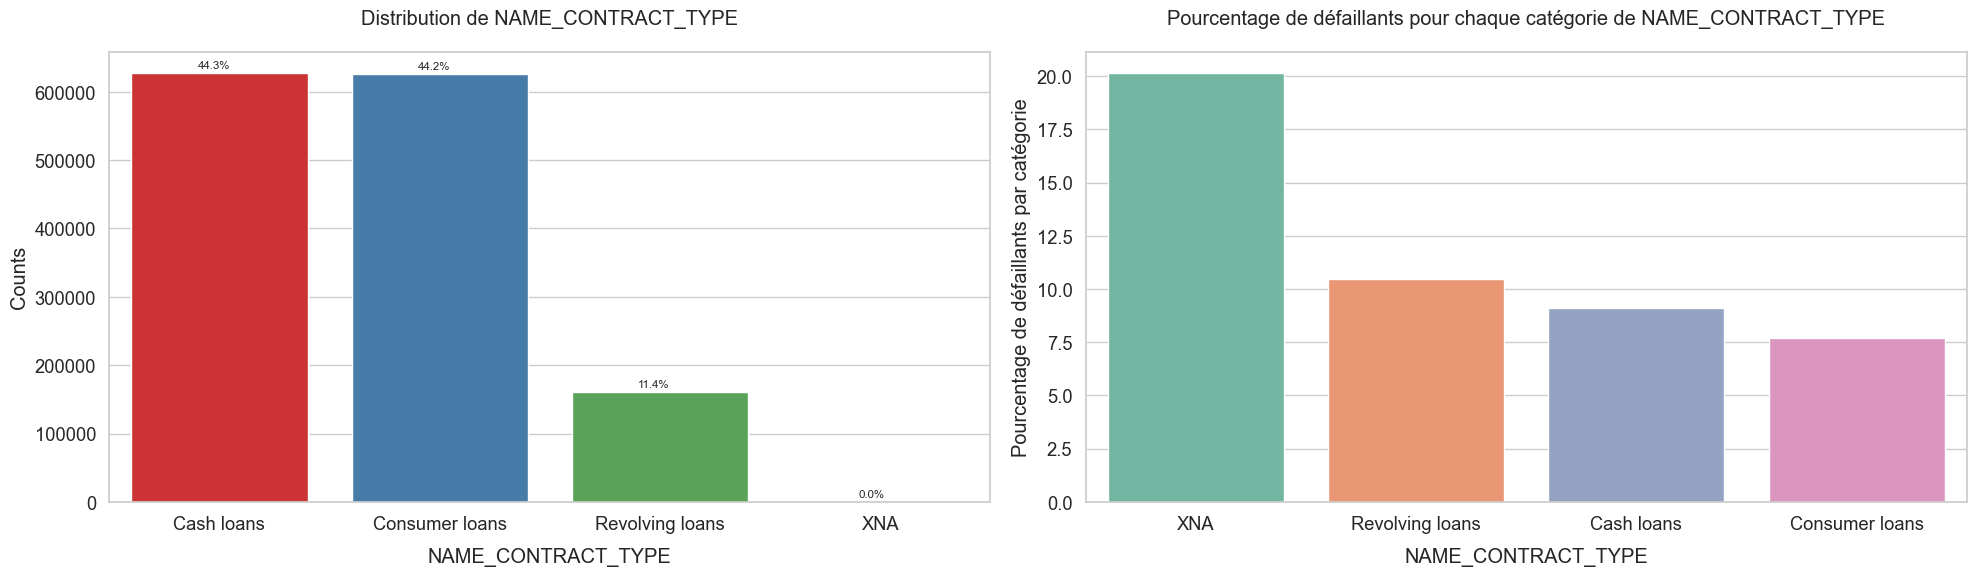

time: 3.59 s (started: 2023-09-19 03:40:10 +02:00)


In [50]:
# Affiche les catégories uniques dans la colonne 'NAME_CONTRACT_TYPE' de prev_merged
print_unique_categories(prev_merged, 'NAME_CONTRACT_TYPE', show_counts=True)

# Appelle la fonction plot_categorical_variables_bar pour la colonne 'NAME_CONTRACT_TYPE'
plot_categorical_variables_bar(prev_merged, 'NAME_CONTRACT_TYPE', horizontal_adjust=0.3, figsize=(20, 6))

_**Observations**_
* À partir du premier sous-graphique, nous voyons que la plupart des prêts précédents étaient soit des prêts de trésorerie, soit des prêts à la consommation, qui correspondent chacun à environ 44 % des prêts. Les 11,41 % restants correspondent à des prêts renouvelables, et il existe des prêts nommés XNA dont les types ne sont en réalité pas connus, mais ils sont très peu nombreux.
* En regardant le deuxième sous-graphique, nous voyons que le pourcentage de défaillants pour le type de prêt XNA est le plus élevé, avec un taux de défaut de 20 %. Le deuxième taux de défaut le plus élevé concerne les prêts renouvelables, qui est proche de 10,5 %.
* Les prêts de trésorerie ont des taux de défaut moindres, environ 9 %, tandis que les prêts à la consommation ont tendance à avoir le pourcentage de défauts de paiement le plus faible, proche de 7,5 %.

<font color = "#AFA4CE"> _**Distribution de la variable continue NAME_CONTRACT_STATUS**_<font color = "b">

Cette variable décrit le statut du contrat du prêt précédent avec Home Credit, c'est-à-dire s'il est actif ou clôturé, etc.

----------------------------------------------------------------------------------------------------
Les catégories uniques de 'NAME_CONTRACT_STATUS' sont :
['Approved' 'Canceled' 'Refused' nan 'Unused offer']
----------------------------------------------------------------------------------------------------
Nombre total de catégories uniques de NAME_CONTRACT_STATUS = 5

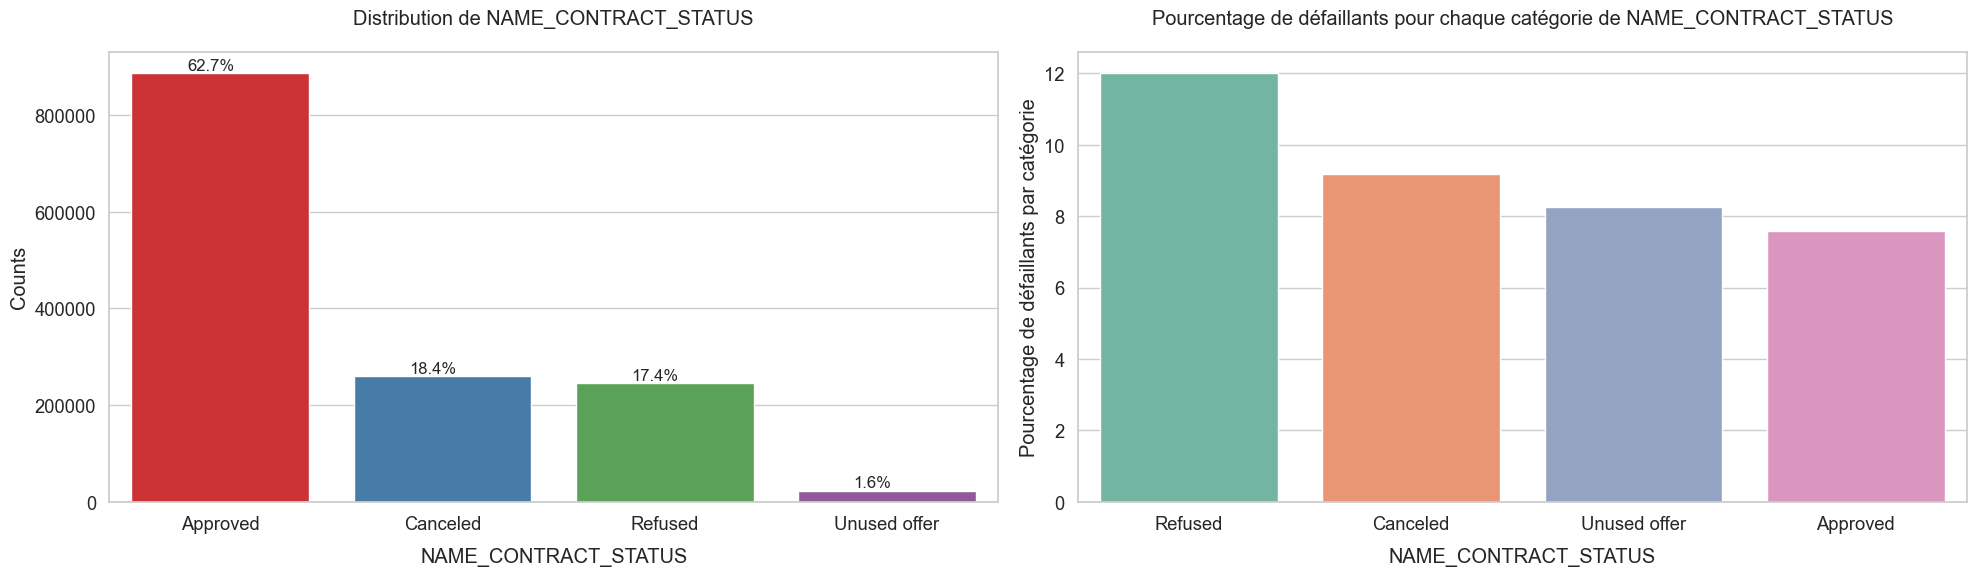

----------------------------------------------------------------------------------------------------
time: 2.89 s (started: 2023-09-19 03:40:14 +02:00)


In [51]:
# Affiche les catégories uniques dans la colonne 'NAME_CONTRACT_STATUS' de prev_merged
print_unique_categories(prev_merged, 'NAME_CONTRACT_STATUS')

# Appelle la fonction plot_categorical_variables_bar pour la colonne 'NAME_CONTRACT_STATUS'
plot_categorical_variables_bar(prev_merged, 'NAME_CONTRACT_STATUS', horizontal_adjust = 0.25, figsize = (20, 6), fontsize_percent = 'small')
print('-'*100)

_**Observations**_
* Le type de statut de contrat le plus courant est le statut approuvé. Environ 63 % des crédits précédents ont un statut approuvé. Les deux statuts courants suivants sont "Annulé" et "Refusé", qui correspondent chacun à environ 18 % des prêts. Cela implique que la plupart des prêts sont approuvés et znviron 36% d’entre eux ne le sont pas. Le type de statut de contrat le moins répandu est l'offre non utilisée qui correspond à seulement 1,61 % de l'ensemble des prêts.
* En examinant le deuxième sous-graphique pour le pourcentage de défaillants, nous constatons que les prêts qui avaient auparavant le statut de refus ont tendance à avoir les défauts de paiement les plus élevés parmi les prêts actuels. Ils correspondent à environ 12% des défaillants de cette catégorie. Viennent ensuite les statuts annulés qui correspondent à près de 9 % du taux de défaut. Ce comportement est tout à fait logiquement attendu, puisque ces personnes ont dû être refusées faute de profil adéquat. Le taux de défaut le plus faible est observé pour le statut du contrat Approuvé.

<font color = "#AFA4CE"> _**Distribution de la variable continue CODE_REJECT_REASON**_<font color = "b">

Cette variable décrit la raison du rejet du prêt précédemment demandé chez Home Credit Group.

----------------------------------------------------------------------------------------------------
Les catégories uniques de 'CODE_REJECT_REASON' sont :
['XAP' 'LIMIT' nan 'HC' 'SCO' 'SCOFR' 'VERIF' 'CLIENT' 'XNA' 'SYSTEM']
----------------------------------------------------------------------------------------------------


Nombre total de catégories uniques de CODE_REJECT_REASON = 10


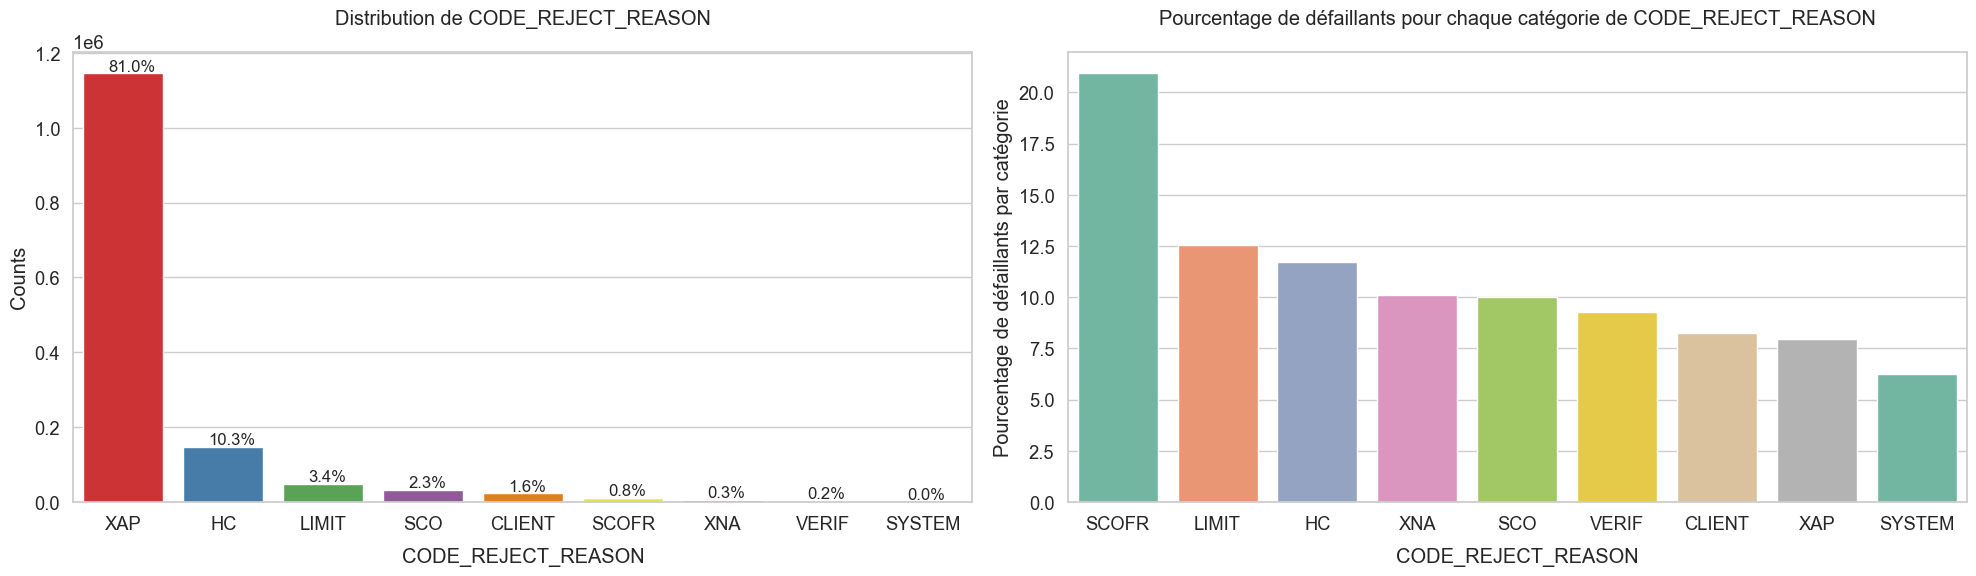

----------------------------------------------------------------------------------------------------
time: 3.66 s (started: 2023-09-19 03:40:17 +02:00)


In [52]:
# Affiche les catégories uniques dans la colonne 'CODE_REJECT_REASON' de prev_merged
print_unique_categories(prev_merged, 'CODE_REJECT_REASON')

# Appelle la fonction plot_categorical_variables_bar pour la colonne 'CODE_REJECT_REASON'
plot_categorical_variables_bar(prev_merged, 'CODE_REJECT_REASON', horizontal_adjust = 0.25, figsize = (20, 6), fontsize_percent = 'small')
print('-'*100)

_**Observations**_
* Le type de motif de rejet le plus courant est XAP, qui représente environ 81 %. Les autres motifs ne constituent qu’une petite partie des motifs de refus. HC est le deuxième motif de rejet le plus important avec seulement 10,33 % des occurrences.
* La répartition du pourcentage de défaillants pour chaque catégorie de CODE_REJECT_REASON est assez intéressante. Les candidats dont les candidatures précédentes ont été rejetées par le Code SCOFT ont le pourcentage le plus élevé de défaillants parmi eux (~ 21 %). Viennent ensuite LIMIT et HC qui comptent environ 12,5 % et 12 % de défaillants.
* Le motif de rejet le plus courant, XAP, correspond à seulement 7,5 % des défaillants et constitue le deuxième pourcentage le plus bas de défaillants après le code SYSTÈME.

<font color = "#AFA4CE"> _**Distribution de la variable continue CHANNEL_TYPE**_<font color = "b">

Cette colonne décrit le canal par lequel le client a été acquis pour le précédent prêt en Crédit Habitation.

----------------------------------------------------------------------------------------------------
Les catégories uniques de 'CHANNEL_TYPE' sont :
['Stone' 'Credit and cash offices' 'Country-wide' 'Regional / Local'
 'AP+ (Cash loan)' 'Contact center' nan 'Channel of corporate sales'
 'Car dealer']
----------------------------------------------------------------------------------------------------
Nombre total de catégories uniques de CHANNEL_TYPE = 9


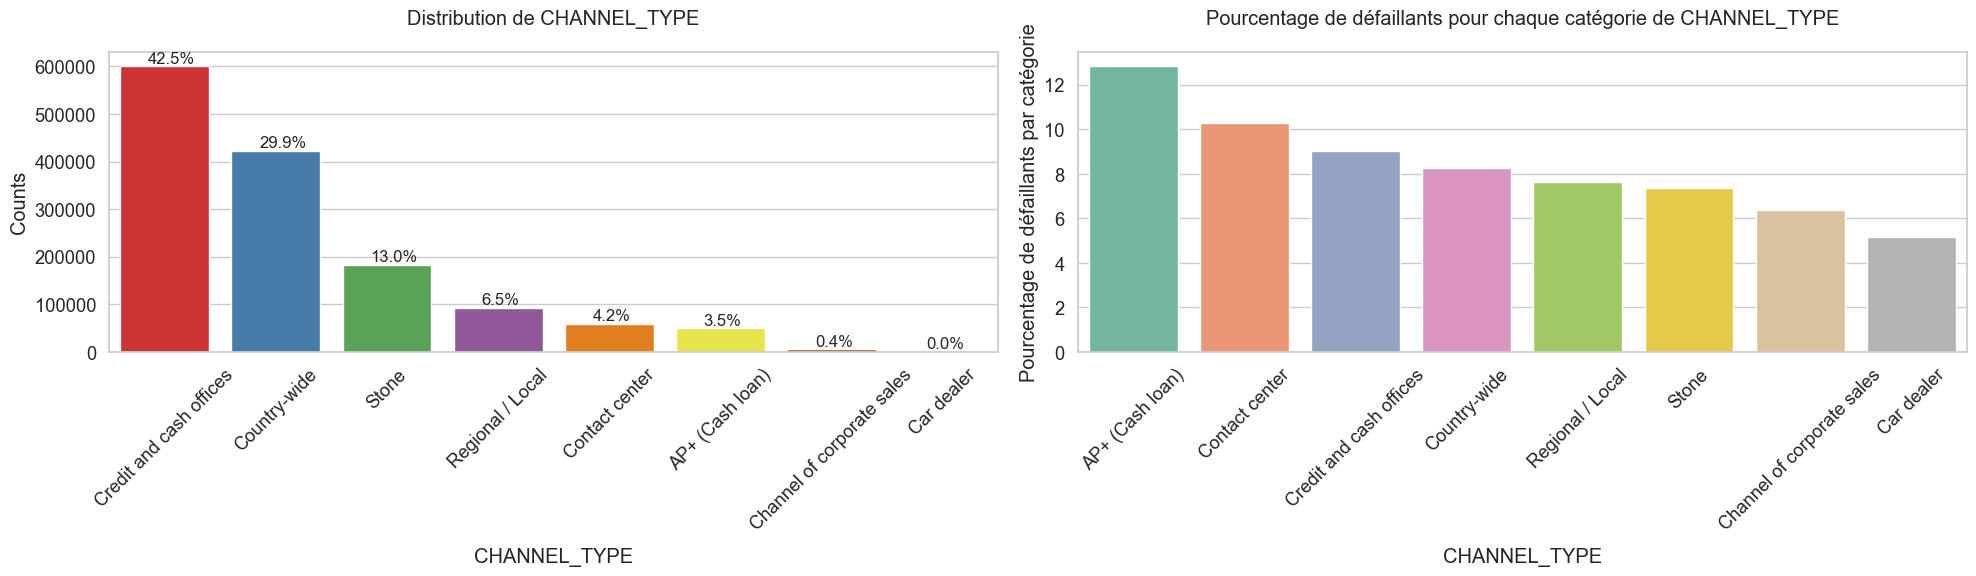

----------------------------------------------------------------------------------------------------
time: 2.98 s (started: 2023-09-19 03:40:20 +02:00)


In [53]:
# Affiche les catégories uniques dans la colonne 'CHANNEL_TYPE' de prev_merged
print_unique_categories(prev_merged, 'CHANNEL_TYPE')

# Appelle la fonction plot_categorical_variables_bar pour la colonne 'CHANNEL_TYPE'
plot_categorical_variables_bar(prev_merged, 'CHANNEL_TYPE', horizontal_adjust = 0.25, figsize = (20, 6), fontsize_percent = 'small', rotation=45)
print('-'*100)

_**Observations**_
* De la première sous-intrigue, nous voyons que la plupart des demandes ont été acquises par l'intermédiaire des caisses et des caisses, soit environ 42,47 % des demandes, suivies par le canal national correspondant à 29,93 % des demandes. Les autres types de canaux ne correspondaient qu’à un nombre restreint d’applications.
* Le pourcentage de défaut de paiement le plus élevé a été observé parmi les candidatures qui disposaient d'un type de canal AP+ (prêt en espèces), ce qui correspondait à environ 13 % de défauts de paiement dans cette catégorie. Les autres chaînes avaient des pourcentages de défaut inférieurs à celui-ci. La chaîne Concessionnaire automobile a affiché le pourcentage de défaillants le plus faible dans cette catégorie (seulement 5 %).

<font color = "#AFA4CE"> _**Distribution de la variable continue PRODUCT_COMBINATION**_<font color = "b">

Cette colonne donne des détails sur la combinaison de produits des applications précédentes.

----------------------------------------------------------------------------------------------------
Les catégories uniques de 'PRODUCT_COMBINATION' sont :
['POS other with interest' 'Cash X-Sell: low' 'POS industry with interest'
 'POS household with interest' 'POS mobile without interest' 'Card Street'
 'Card X-Sell' 'Cash X-Sell: high' 'Cash' 'Cash Street: high'
 'Cash X-Sell: middle' 'POS mobile with interest'
 'POS household without interest' 'POS industry without interest'
 'Cash Street: low' nan 'Cash Street: middle'
 'POS others without interest']
----------------------------------------------------------------------------------------------------
Nombre total de catégories uniques de PRODUCT_COMBINATION = 18


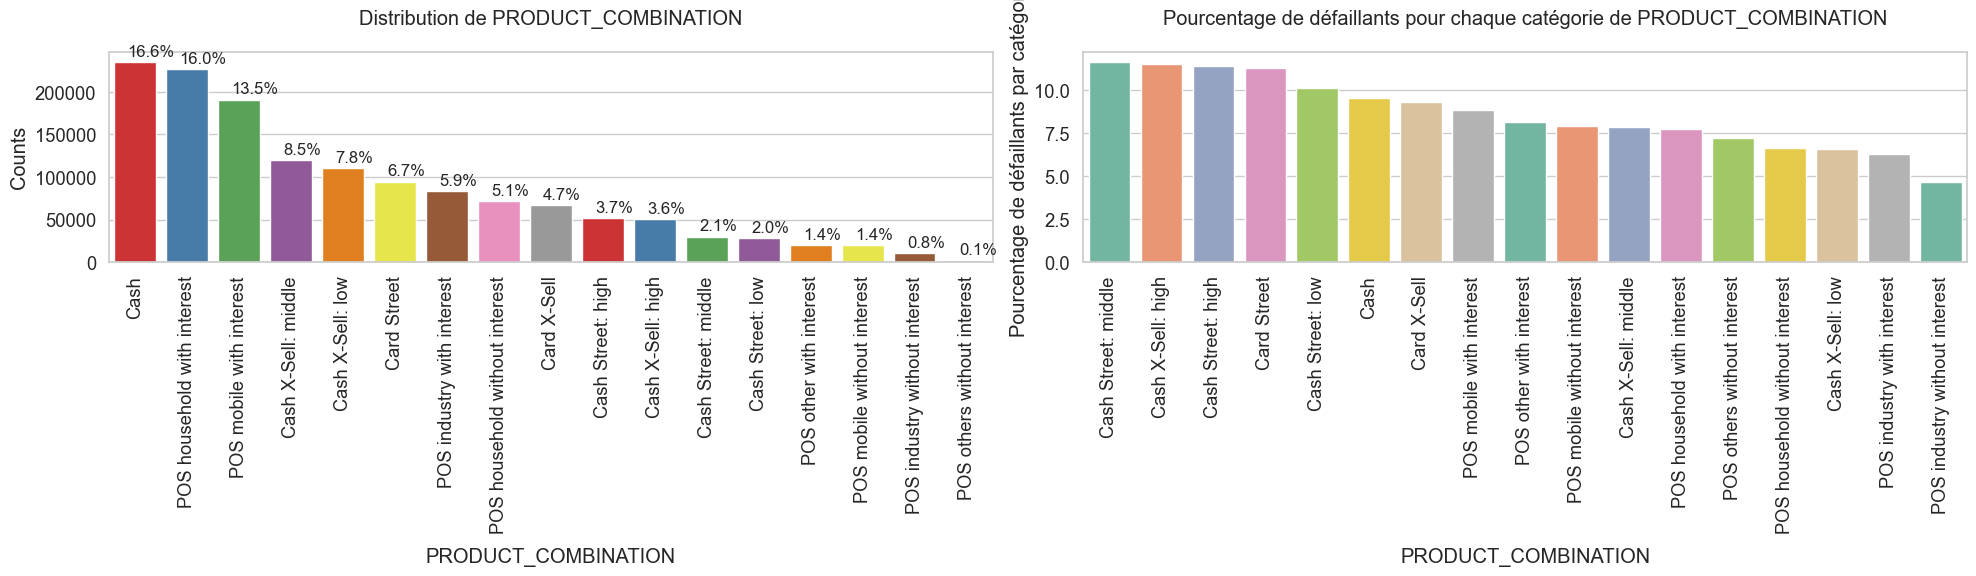

----------------------------------------------------------------------------------------------------
time: 4.11 s (started: 2023-09-19 03:40:23 +02:00)


In [54]:
# Affiche les catégories uniques dans la colonne 'PRODUCT_COMBINATION' de prev_merged
print_unique_categories(prev_merged, 'PRODUCT_COMBINATION')

# Appelle la fonction plot_categorical_variables_bar pour la colonne 'PRODUCT_COMBINATION'
plot_categorical_variables_bar(prev_merged, 'PRODUCT_COMBINATION', horizontal_adjust = 0.25, figsize = (20, 6), fontsize_percent = 'small', rotation=90)
print('-'*100)

_**Observations**_
* Les 3 types de combinaisons de produits les plus courants sont les espèces, les points de vente domestiques avec intérêts et les points de vente mobiles avec intérêts. Elles correspondent à environ 50 % de l'ensemble des candidatures.
* En regardant le graphique du pourcentage de défaillants par catégorie, nous constatons une tendance aux défauts de paiement la plus élevée parmi Cash Street : catégorie mobile, Cash X-sell : élevé, Cash Street : élevé et Card Street qui sont tous proches d'environ 11 à 11,5 % de défaillants par catégorie. Le pourcentage le plus faible de défaillants se trouve dans la catégorie de l'industrie des points de vente sans intérêt, qui correspond à environ 4,5 % de défaillants.

#### <font color = "#4AA3A2">_**Analyse de la distribution des variables numériques**_

<font color = "#AFA4CE"> _**Distribution de la variable continue DAYS_DECISION**_<font color = "b">

Cette colonne indique le nombre de jours par rapport à la demande actuelle pendant lesquels la décision a été prise concernant la demande précédente.

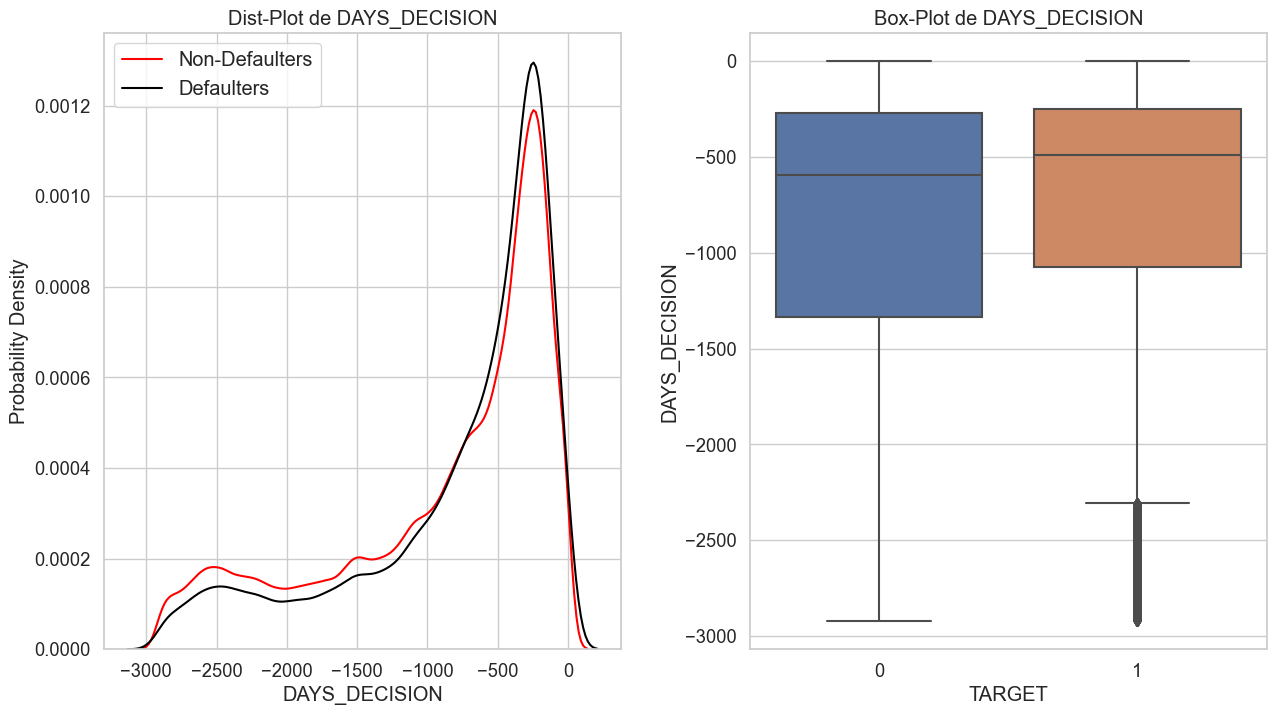

time: 20.2 s (started: 2023-09-19 03:40:27 +02:00)


In [55]:
plot_continuous_variables(prev_merged, 'DAYS_DECISION', plots = ['distplot', 'box'], figsize = (15,8), histogram = False)

_**Observations**_

D'après le graphique ci-dessus, nous remarquons que pour les défaillants, le nombre de jours en arrière lorsque la décision a été prise est un peu inférieur à celui des non-défaillants. Cela implique que les défaillants ont généralement vu la décision sur leurs demandes précédentes prise plus récemment que les non-défaillants.

<font color = "#AFA4CE"> _**Distribution de la variable continue DAYS_FIRST_DRAWING**_<font color = "b">

Cette colonne indique le nombre de jours depuis la demande actuelle depuis lequel le premier décaissement de la demande précédente a été effectué.

----------------------------------------------------------------------------------------------------
La valeur du 0e percentile de 'DAYS_FIRST_DRAWING' est -2922.0
La valeur du 1e percentile de 'DAYS_FIRST_DRAWING' est -2451.0
La valeur du 2e percentile de 'DAYS_FIRST_DRAWING' est -1179.0
La valeur du 3e percentile de 'DAYS_FIRST_DRAWING' est -674.0
La valeur du 4e percentile de 'DAYS_FIRST_DRAWING' est -406.0


La valeur du 5e percentile de 'DAYS_FIRST_DRAWING' est -262.0
La valeur du 6e percentile de 'DAYS_FIRST_DRAWING' est -156.0
La valeur du 7e percentile de 'DAYS_FIRST_DRAWING' est 365243.0
La valeur du 8e percentile de 'DAYS_FIRST_DRAWING' est 365243.0
La valeur du 9e percentile de 'DAYS_FIRST_DRAWING' est 365243.0
La valeur du 10e percentile de 'DAYS_FIRST_DRAWING' est 365243.0
La valeur du 20e percentile de 'DAYS_FIRST_DRAWING' est 365243.0
La valeur du 40e percentile de 'DAYS_FIRST_DRAWING' est 365243.0
La valeur du 60e percentile de 'DAYS_FIRST_DRAWING' est 365243.0
La valeur du 80e percentile de 'DAYS_FIRST_DRAWING' est 365243.0
La valeur du 100e percentile de 'DAYS_FIRST_DRAWING' est 365243.0
----------------------------------------------------------------------------------------------------


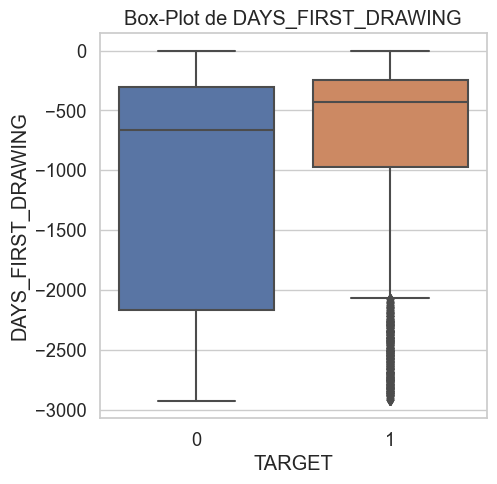

----------------------------------------------------------------------------------------------------
time: 2.88 s (started: 2023-09-19 03:40:48 +02:00)


In [56]:
print_percentiles(prev_merged, 'DAYS_FIRST_DRAWING', percentiles = list(range(0,11)) + list(range(20,101,20)))
plot_continuous_variables(prev_merged, 'DAYS_FIRST_DRAWING', plots = ['box'], figsize = (5,5), scale_limits = [-3000,0])
print('-'*100)

_**Observations**_

En regardant les valeurs centiles de DAYS_FIRST_DRAWING, il semble que la plupart des valeurs soient erronées, à commencer par les valeurs du 7e centile lui-même. Ces valeurs erronées devront être supprimées.
Si nous essayons d'analyser la répartition de cette colonne en supprimant les points erronés, nous constatons que la plupart des défaillants ont eu leur premier tirage sur le crédit précédent plus récemment que les non-défaillants. La valeur du 75e percentile pour les défaillants est également nettement inférieure à celle des non-défaillants.

<font color = "#AFA4CE"> _**Distributions des variables continues DAYS_FIRST_DUE, DAYS_LAST_DUE_1ST_VERSION, DAYS_LAST_DUE et DAYS_TERMINATION**_<font color = "b">

Ces colonnes décrivent également le nombre de jours depuis l'application actuelle pendant lesquels certaines activités se sont produites.

In [57]:
print('-'*100)
print("Percentile Values for DAYS_FIRST_DUE")
print_percentiles(prev_merged, 'DAYS_FIRST_DUE', percentiles = list(range(0,11,2)) + [20,40,60,80,100])
print("Percentile Values for DAYS_LAST_DUE_1ST_VERSION")
print_percentiles(prev_merged, 'DAYS_LAST_DUE_1ST_VERSION', percentiles = list(range(0,11,2)) + [20,40,60,80,100])
print("Percentile Values for DAYS_LAST_DUE")
print_percentiles(prev_merged, 'DAYS_LAST_DUE', percentiles = list(range(0,11,2)) + [20,40,60,80,100])
print("Percentile Values for DAYS_TERMINATION")
print_percentiles(prev_merged, 'DAYS_TERMINATION', percentiles = list(range(0,11,2)) + [20,40,60,80,100])

----------------------------------------------------------------------------------------------------
Percentile Values for DAYS_FIRST_DUE
----------------------------------------------------------------------------------------------------
La valeur du 0e percentile de 'DAYS_FIRST_DUE' est -2892.0
La valeur du 2e percentile de 'DAYS_FIRST_DUE' est -2759.0
La valeur du 4e percentile de 'DAYS_FIRST_DUE' est -2648.0
La valeur du 6e percentile de 'DAYS_FIRST_DUE' est -2555.0
La valeur du 8e percentile de 'DAYS_FIRST_DUE' est -2471.0
La valeur du 10e percentile de 'DAYS_FIRST_DUE' est -2388.0
La valeur du 20e percentile de 'DAYS_FIRST_DUE' est -1882.0
La valeur du 40e percentile de 'DAYS_FIRST_DUE' est -1070.0
La valeur du 60e percentile de 'DAYS_FIRST_DUE' est -647.0
La valeur du 80e percentile de 'DAYS_FIRST_DUE' est -329.0
La valeur du 100e percentile de 'DAYS_FIRST_DUE' est 365243.0
----------------------------------------------------------------------------------------------------
Perce

_**Observations**_

À partir de toutes les valeurs centiles ci-dessus, nous réalisons que toutes les colonnes Jours ont ces valeurs erronées quelque part. Ces valeurs doivent donc être remplacées afin que notre modèle n'en soit pas affecté.

#### <font color = "#5784BA"> **2.5. Analyse du dataset installments_payments** <font color = "b">

Ce tableau répertorie l'historique de remboursement de chacun des prêts que le demandeur avait auprès de Home Credit Group. Le tableau contient des fonctionnalités telles que le montant du versement, combien le client a payé pour chaque versement, etc.

#### <font color = "#4AA3A2"> _**Description des données**_

In [58]:
print(f'Dimensions du tableau installments_payments : {installments_payments.shape}')
print('-'*100)
print(f'Nombre de valeurs unique de SK_ID_PREV dans installments_payments : {len(installments_payments.SK_ID_PREV.unique())}')
print(f'Nombre de valeurs unique de SK_ID_CURR dans installments_payments : {len(installments_payments.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Nombre d\'éléments SK_ID_CURR se chevauchant avec application_train et installments_payments : {len(set(application_train.SK_ID_CURR.unique()).intersection(set(installments_payments.SK_ID_CURR.unique())))}')
print(f'Nombre d\'éléments SK_ID_CURR se chevauchant avec application_test et installments_payments : {len(set(application_test.SK_ID_CURR.unique()).intersection(set(installments_payments.SK_ID_CURR.unique())))}')
print('-'*100)
print(f'Nombre de valeurs en double dans installments_payments : {installments_payments.shape[0] - installments_payments.duplicated().shape[0]}')
print('-'*100)
display(installments_payments.head(5))

Dimensions du tableau installments_payments : (13605401, 8)
----------------------------------------------------------------------------------------------------


Nombre de valeurs unique de SK_ID_PREV dans installments_payments : 997752
Nombre de valeurs unique de SK_ID_CURR dans installments_payments : 339587
----------------------------------------------------------------------------------------------------
Nombre d'éléments SK_ID_CURR se chevauchant avec application_train et installments_payments : 291643
Nombre d'éléments SK_ID_CURR se chevauchant avec application_test et installments_payments : 47944
----------------------------------------------------------------------------------------------------
Nombre de valeurs en double dans installments_payments : 0
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.00,6,-1180.00,-1187.00,6948.36,6948.36
1,1330831,151639,0.00,34,-2156.00,-2156.00,1716.53,1716.53
2,2085231,193053,2.00,1,-63.00,-63.00,25425.00,25425.00
3,2452527,199697,1.00,3,-2418.00,-2426.00,24350.13,24350.13
4,2714724,167756,1.00,2,-1383.00,-1366.00,2165.04,2160.59


time: 50 s (started: 2023-09-19 03:40:54 +02:00)


In [59]:
print('-'*100)
print("Colonnes avec des valeurs NaN et leurs pourcentages :")
installments_payments_nan = nan_df_create(installments_payments)
display(installments_payments_nan[installments_payments_nan.percent != 0])
print('-'*100)
del installments_payments_nan

----------------------------------------------------------------------------------------------------
Colonnes avec des valeurs NaN et leurs pourcentages :


,column,percent
5,DAYS_ENTRY_PAYMENT,0.02
7,AMT_PAYMENT,0.02


----------------------------------------------------------------------------------------------------
time: 2.69 s (started: 2023-09-19 03:41:44 +02:00)


_**Observations :**_
* Il y a environ 13,6 millions de points de données dans la table installments_payments.csv. Chaque ligne représente chaque historique de versement lié à un prêt particulier que le client avait précédemment contracté auprès de Home Credit Group.
* Il y a 997 000 prêts antérieurs uniques dans les versements_paiements. Ceux-ci appartiennent à 339 000 SK_ID_CURR uniques, qui sont les identifiants des demandeurs de prêt en cours.
* Sur ces 339 000 SK_ID_CURR, 291 000 appartiennent à l’ensemble de données d’entraînement et 47,9 000 appartiennent à l’ensemble de données de test. Cela implique que presque sur 307 000 SK_ID_CURR uniques dans application_train, 291 000 avaient auparavant bénéficié d'une forme de prêt avec Home Credit. De même, pour 48,7 000 personnes dans l’ensemble de données de test, 47,9 000 avaient déjà obtenu un prêt avec Home Credit.
* Le tableau comporte 8 caractéristiques uniques, dont 6 décrivent les statistiques de chaque versement du prêt précédent.
* Il n'y a que 2 colonnes contenant les valeurs NaN des 8 colonnes de installments_payments.
Ces colonnes contiennent également une proportion très minime de valeurs NaN, c'est-à-dire seulement 0,02 %, ce qui n'est donc pas très préoccupant.

#### <font color = "#4AA3A2"> _**Fusion de TARGET de la table application_train vers la table installments_payments.**_

In [60]:
print("-"*100)
print("Fusion de TARGET avec la table installments_payments")
installments_merged = application_train.iloc[:,:2].merge(installments_payments, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Fusion de TARGET avec la table installments_payments


----------------------------------------------------------------------------------------------------
time: 20.5 s (started: 2023-09-19 03:41:47 +02:00)


_**Corrélation pour les données fusionnées**_

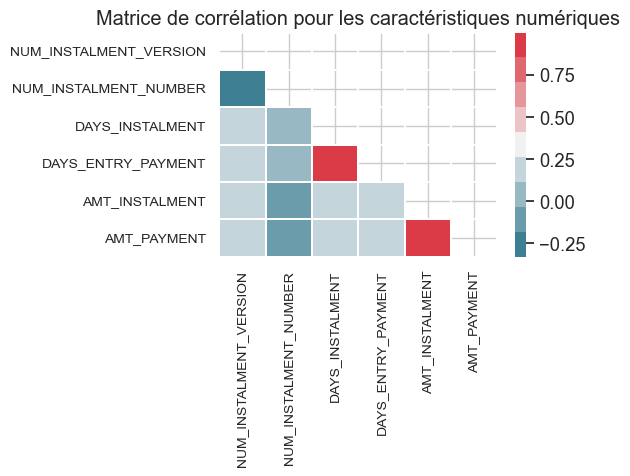

time: 13.8 s (started: 2023-09-19 03:42:08 +02:00)


In [61]:
corr_mat = CorrelationMatrix(installments_merged, ['SK_ID_CURR','SK_ID_PREV'], figsize = (6,5), cmap = palette)
corr_mat.plot_correlation_matrix()

In [62]:
#Seeing the top columns with highest phik-correlation with the target variable in installments_payments table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Les colonnes avec les valeurs de corrélation Phik les plus élevées avec la variable cible sont:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'NUM_INSTALMENT_VERSION']
interval columns not set, guessing: ['TARGET', 'NUM_INSTALMENT_NUMBER']
interval columns not set, guessing: ['TARGET', 'DAYS_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'DAYS_ENTRY_PAYMENT']
interval columns not set, guessing: ['TARGET', 'AMT_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT']
----------------------------------------------------------------------------------------------------
Les colonnes avec les valeurs de corrélation Phik les plus élevées avec la variable cible sont:


,Column Name,Phik-Correlation
2,DAYS_INSTALMENT,0.05
3,DAYS_ENTRY_PAYMENT,0.03
1,NUM_INSTALMENT_NUMBER,0.02
4,AMT_INSTALMENT,0.00
5,AMT_PAYMENT,0.00
0,NUM_INSTALMENT_VERSION,0.00


----------------------------------------------------------------------------------------------------
time: 2min 47s (started: 2023-09-19 03:42:22 +02:00)


_**Observations :**_
* La carte thermique ci-dessus montre la corrélation entre chaque fonctionnalité du tableau installments_payments avec le reste des variables.
* À partir de la carte thermique de la matrice de corrélation, nous voyons quelques caractéristiques hautement corrélées. Ceux-ci sont:
    - AMT_INSTALMENT et AMT_PAYMENT
    - DAYS_INSTALMENT et DAYS_ENTRY_PAYMENT
* Ces deux ensembles de caractéristiques corrélées sont compréhensibles, car il s’agit en fait de caractéristiques indiquant le moment où l’acompte devait être payé par rapport au moment où il a été payé, ainsi que le montant dû par rapport au montant payé.
* Ces variables seront utiles pour créer de nouveaux ensembles de variables totalement décorrélées.
La corrélation des variables avec Target n'est pas perceptible, cela montre l'absence de relation linéaire entre la fonctionnalité et la variable cible.

##### <font color = "#AFA4CE"> _**Distributions des variables continues**_<font color = "b">

Tout d'abord, nous allons regrouper par champ « SK_ID_PREV » et agréger avec la moyenne, afin d'obtenir une ligne moyenne pour chacun des prêts précédents du client.

In [63]:
installments_merged = installments_merged.groupby('SK_ID_PREV').mean()

time: 4.72 s (started: 2023-09-19 03:45:09 +02:00)


<font color = "#AFA4CE"> _**Distribution de la variable continue DAYS_INSTALMENT**_<font color = "b">

Cette colonne répertorie les jours où l'échéance du crédit précédent devait être payée.

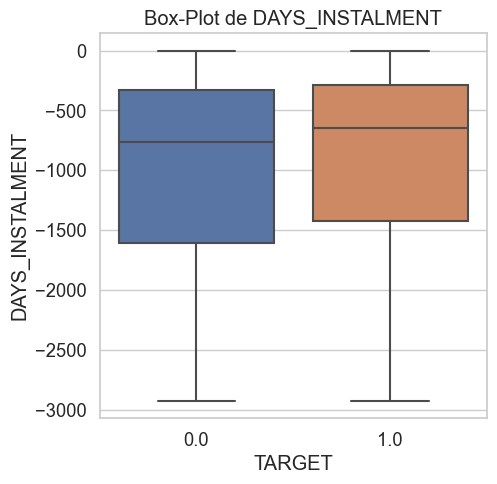

time: 2.84 s (started: 2023-09-19 03:45:14 +02:00)


In [64]:
# Appel de la fonction pour la visualisation des boîtes à moustaches
plot_continuous_variables(installments_merged, 'DAYS_INSTALMENT', plots = ['box'], figsize = (5,5))

<font color = "#AFA4CE"> _**Distribution de la variable continue ENTRY_PAYMENT**_<font color = "b">

Cette colonne répertorie les jours où l'acompte du crédit précédent a été effectivement payé.

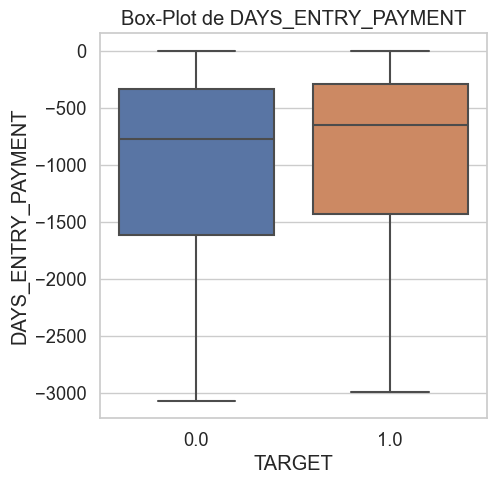

time: 954 ms (started: 2023-09-19 03:45:17 +02:00)


In [65]:
# Tracer du graphique boxplot pour visualiser la distribution de la colonne 'DAYS_ENTRY_PAYMENT' de installments_merged
plot_continuous_variables(installments_merged, 'DAYS_ENTRY_PAYMENT', plots=['box'], figsize=(5, 5))

# Suppression de la variable installments_merged pour libérer de la mémoire
del installments_merged

_**Observations :**_
En général, les défaillants ont effectué leur dernier paiement plus récemment que les non-défaillants. De plus, tous les quantiles de défaillants ont des jours depuis le dernier paiement plus récents que tous les quantiles de non-défaillants. Cela signifie que les non-défaillants ont une plus grande variabilité dans le temps entre leurs paiements que les défaillants.

#### <font color = "#5784BA"> **2.6. POS_CASH_balance** <font color = "b">

Ce tableau contient les relevés de solde mensuels des précédents prêts sur le lieu de vente et des prêts au comptant que le demandeur a eus avec le Groupe Home Credit.

#### <font color = "#4AA3A2"> _**Description des données**_

In [66]:
print(f'Dimensions du tableau POS_CASH_balance : {POS_CASH_balance.shape}')
print('-'*100)
print(f'Nombre de valeurs unique de SK_ID_PREV dans POS_CASH_balance : {len(POS_CASH_balance.SK_ID_PREV.unique())}')
print(f'Nombre de valeurs unique de SK_ID_CURR dans POS_CASH_balance : {len(POS_CASH_balance.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Nombre d\'éléments SK_ID_CURR se chevauchant avec application_train et and POS_CASH_balance : {len(set(application_train.SK_ID_CURR.unique()).intersection(set(POS_CASH_balance.SK_ID_CURR.unique())))}')
print(f'Nombre d\'éléments SK_ID_CURR se chevauchant avec application_test POS_CASH_balance : {len(set(application_test.SK_ID_CURR.unique()).intersection(set(POS_CASH_balance.SK_ID_CURR.unique())))}')
print('-'*100)
print(f'Nombre de valeurs en double dans POS_CASH_balance: {POS_CASH_balance.shape[0] - POS_CASH_balance.duplicated().shape[0]}')
print('-'*100)
display(POS_CASH_balance.head())

Dimensions du tableau POS_CASH_balance : (10001358, 8)
----------------------------------------------------------------------------------------------------


Nombre de valeurs unique de SK_ID_PREV dans POS_CASH_balance : 936325
Nombre de valeurs unique de SK_ID_CURR dans POS_CASH_balance : 337252
----------------------------------------------------------------------------------------------------
Nombre d'éléments SK_ID_CURR se chevauchant avec application_train et and POS_CASH_balance : 289444
Nombre d'éléments SK_ID_CURR se chevauchant avec application_test POS_CASH_balance : 47808
----------------------------------------------------------------------------------------------------
Nombre de valeurs en double dans POS_CASH_balance: 0
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.00,45.00,Active,0,0
1,1715348,367990,-33,36.00,35.00,Active,0,0
2,1784872,397406,-32,12.00,9.00,Active,0,0
3,1903291,269225,-35,48.00,42.00,Active,0,0
4,2341044,334279,-35,36.00,35.00,Active,0,0


time: 22.1 s (started: 2023-09-19 03:45:18 +02:00)


In [67]:
print('-'*100)
print("Columns with NaN values and their percentages:")
POS_CASH_nan = nan_df_create(POS_CASH_balance)
display(POS_CASH_nan[POS_CASH_nan.percent != 0])
print('-'*100)
del POS_CASH_nan

----------------------------------------------------------------------------------------------------
Columns with NaN values and their percentages:


,column,percent
4,CNT_INSTALMENT_FUTURE,0.26
3,CNT_INSTALMENT,0.26


----------------------------------------------------------------------------------------------------
time: 1.38 s (started: 2023-09-19 03:45:40 +02:00)


_**Observations :**_
* Cette table contient environ 10 millions de lignes. Elle se compose de 8 colonnes, dont deux sont SK_ID_CURR et SK_ID_PREV.
* La table contient 936 000 identifiants uniques de prêts antérieurs, qui correspondent à 337 000 demandeurs actuels uniques (SK_ID_CURR).
* Sur ces 337k SK_ID_CURR, 289k appartiennent à l'ensemble d'apprentissage et 47,8k à l'ensemble de test.
* Il n'y a que 2 colonnes qui contiennent des valeurs NaN. Ces colonnes sont le nombre de versements restants et la durée du prêt. La proportion de ces valeurs manquantes est faible, seulement 0,26 %, ce qui n'est donc pas très préoccupant.

#### <font color = "#4AA3A2"> _**Fusion de TARGET de la table application_train vers la table POS_CASH_balance.**_

In [68]:
print("-"*100)
print("Merging TARGET with POS_CASH_balance Table")
pos_cash_merged = application_train.iloc[:,:2].merge(POS_CASH_balance, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with POS_CASH_balance Table


----------------------------------------------------------------------------------------------------
time: 12 s (started: 2023-09-19 03:45:42 +02:00)


_**Corrélation pour les données fusionnées "pos_cash_merged"**_

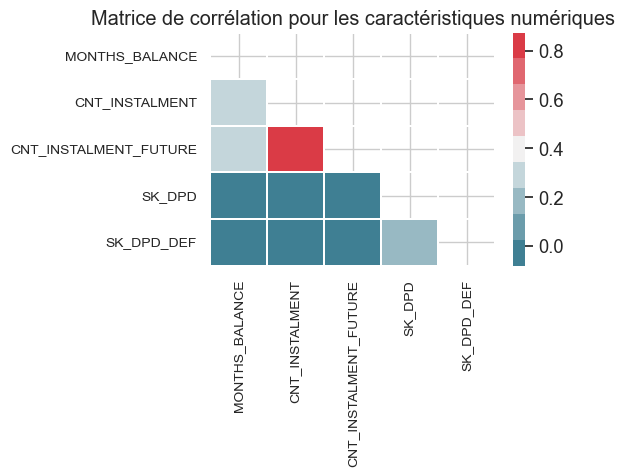

time: 6.28 s (started: 2023-09-19 03:45:54 +02:00)


In [69]:
corr_mat = CorrelationMatrix(pos_cash_merged, ['SK_ID_CURR','SK_ID_PREV'], figsize = (6,5))
corr_mat.plot_correlation_matrix()

_**Observations :**_<br>
Nous avons deux de variables fortement corrélées, qui sont : CNT_INSTALMENT et CNT_INSTALMENT_FUTURE. La corrélation des variables avec Target est très faible, cela montre l'absence de relation linéaire entre la fonctionnalité et la variable cible.

##### <font color = "#AFA4CE"> _**Distributions des variables continues**_<font color = "b">

Regroupons les données en fonction du champ "SK_ID_PREV" et aggrégeons les avec la moyenne, afin d'obtenir une ligne moyenne pour chacun des prêts antérieurs du client.

In [70]:
# Exclusion de la variable non-numériques "NAME_CONTRACT_STATUS"
pos_cash_filtred = pos_cash_merged.drop(['NAME_CONTRACT_STATUS'], axis=1)
pos_cash_filtred = pos_cash_filtred.groupby('SK_ID_PREV').mean()

time: 3.95 s (started: 2023-09-19 03:46:00 +02:00)


<font color = "#AFA4CE"> _**Distribution de la variable continue CNT_INSTALMENT_FUTURE**_<font color = "b">

Cette variable décrit le nombre de mensualités restant à payer sur le crédit précédent.

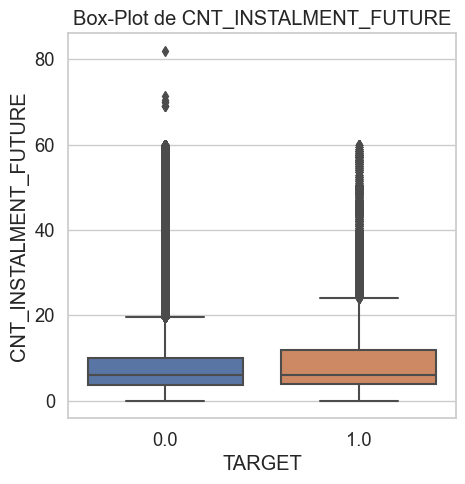

time: 1.33 s (started: 2023-09-19 03:46:04 +02:00)


In [71]:
plot_continuous_variables(pos_cash_filtred, 'CNT_INSTALMENT_FUTURE', plots = ['box'], figsize = (5,5))
del pos_cash_merged
del pos_cash_filtred

_**Observations :**_<br>
En analysant le graphique, on constate que les valeurs des mauvais payeurs sont plus élevées que celles des non mauvais payeurs pour tous les percentiles supérieurs à 50 %. La limite supérieure des mauvais payeurs est également plus élevée que celle des non mauvais payeurs. Cela suggère que les mauvais payeurs ont généralement plus de mensualités restantes sur leurs crédits précédents que les non mauvais payeurs.

#### <font color = "#5784BA"> **2.7. credit_card_balance** <font color = "b">

Ce tableau comprend les données mensuelles liées à une ou plusieurs cartes de crédit que le demandeur détenait auprès du Home Credit Group. Le tableau contient des champs comme le solde, la limite de crédit, le montant des tirages, etc. pour chaque mois de la carte de crédit.

#### <font color = "#4AA3A2"> _**Description des données**_

In [72]:
print(f'Dimensions du tableau credit_card_balance : {credit_card_balance.shape}')
print('-'*100)
print(f'Nombre de valeurs unique de SK_ID_PREV dans credit_card_balance: {len(credit_card_balance.SK_ID_PREV.unique())}')
print(f'Nombre de valeurs unique de SK_ID_CURR dans credit_card_balance : {len(credit_card_balance.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Nombre d\'éléments SK_ID_CURR se chevauchant avec application_train et credit_card_balance : {len(set(application_train.SK_ID_CURR.unique()).intersection(set(credit_card_balance.SK_ID_CURR.unique())))}')
print(f'Nombre d\'éléments SK_ID_CURR se chevauchant avec application_test et credit_card_balance.csv: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(credit_card_balance.SK_ID_CURR.unique())))}')
print('-'*100)

print(f'Nombre de valeurs en double dans credit_card_balance : {credit_card_balance.shape[0] - credit_card_balance.duplicated().shape[0]}')
print('-'*100)
display(credit_card_balance.head(5))

Dimensions du tableau credit_card_balance : (3840312, 23)
----------------------------------------------------------------------------------------------------


Nombre de valeurs unique de SK_ID_PREV dans credit_card_balance: 104307
Nombre de valeurs unique de SK_ID_CURR dans credit_card_balance : 103558
----------------------------------------------------------------------------------------------------
Nombre d'éléments SK_ID_CURR se chevauchant avec application_train et credit_card_balance : 86905
Nombre d'éléments SK_ID_CURR se chevauchant avec application_test et credit_card_balance.csv: 16653
----------------------------------------------------------------------------------------------------
Nombre de valeurs en double dans credit_card_balance : 0
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.97,135000,0.00,877.50,0.00,877.50,1700.33,1800.00,1800.00,0.00,0.00,0.00,0.00,1,0.00,1.00,35.00,Active,0,0
1,2582071,363914,-1,63975.56,45000,2250.00,2250.00,0.00,0.00,2250.00,2250.00,2250.00,60175.08,64875.56,64875.56,1.00,1,0.00,0.00,69.00,Active,0,0
2,1740877,371185,-7,31815.22,450000,0.00,0.00,0.00,0.00,2250.00,2250.00,2250.00,26926.42,31460.08,31460.08,0.00,0,0.00,0.00,30.00,Active,0,0
3,1389973,337855,-4,236572.11,225000,2250.00,2250.00,0.00,0.00,11795.76,11925.00,11925.00,224949.29,233048.97,233048.97,1.00,1,0.00,0.00,10.00,Active,0,0
4,1891521,126868,-1,453919.46,450000,0.00,11547.00,0.00,11547.00,22924.89,27000.00,27000.00,443044.40,453919.46,453919.46,0.00,1,0.00,1.00,101.00,Active,0,0


time: 18.4 s (started: 2023-09-19 03:46:05 +02:00)


In [73]:
cc_balance_nan = nan_df_create(credit_card_balance)
print('-'*100)
plot_nan_percent(cc_balance_nan, 'credit_card_balance',  rotation = 90)
print('-'*100)
del cc_balance_nan

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
time: 954 ms (started: 2023-09-19 03:46:24 +02:00)


_**Observations :**_<br>
* Il y a environ 3.840.312 de lignes dans le tableau credit_card_balance, chacune correspondant au statut mensuel de la carte de crédit que le demandeur avait auprès de Home Credit Group. Ce tableau contient 23 colonnes qui contiennent des statistiques sur le statut de la carte de crédit de chaque mois, telles que le montant du solde, le montant des tirages, le nombre de tirages, le statut, etc.
* Il existe 104.307 cartes de crédit uniques dont les détails figurent dans ce tableau.
* Sur ces 104.307, il y a 103.500 SK_ID_CURR uniques. Cela signifie que la plupart des candidats n'avaient qu'une seule carte de crédit avec eux, et seulement quelques-uns d'entre eux en avaient plus d'une. Ces SK_ID_CURR sont les identifiants des candidats qui ont actuellement demandé un prêt.
* Sur les 103.500 SK_ID_CURR uniques, 86.905 de ces candidats appartiennent au jeu d'entraînement et 16.653 appartiennent à l’ensemble de test.
* Sur les 23 variables, 9 contiennent des valeurs NaN.
* Si on regarde les pourcentages de valeurs NaN, ils sont considérablement inférieurs au reste des tableaux que nous avons vus jusqu'à présent.
7 de ces variables ont des valeurs NaN proches de 20 %. Ces variables sont principalement liées aux quantités de tirages et au nombre de tirages Deux autres variables sont liées aux statistiques de versements.

#### <font color = "#4AA3A2"> _**Fusion de TARGET de la table application_train avec la table redit_card_balance.**_

In [74]:
print("-"*100)
print("Merging TARGET with credit_card_balance Table")
cc_balance_merged = application_train.iloc[:,:2].merge(credit_card_balance, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with credit_card_balance Table


----------------------------------------------------------------------------------------------------
time: 13.7 s (started: 2023-09-19 03:46:25 +02:00)


_**Corrélation pour les données fusionnées "cc_balance_merged"**_

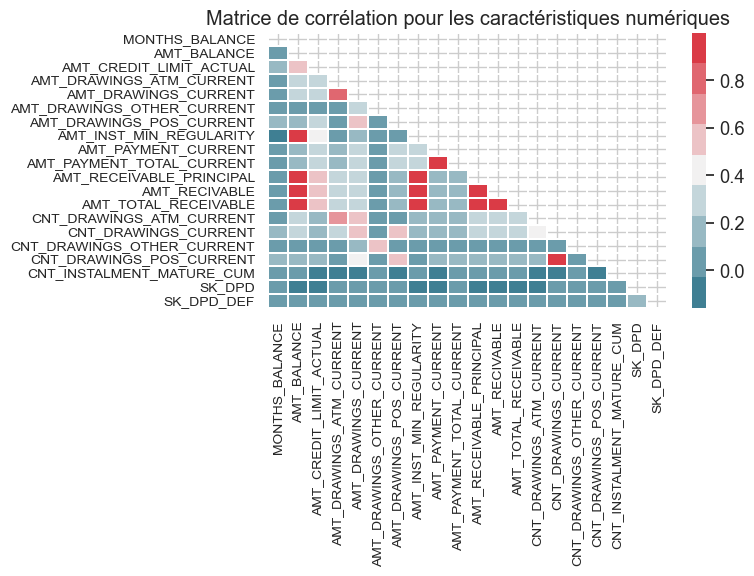

time: 21.4 s (started: 2023-09-19 03:46:39 +02:00)


In [75]:
corr_mat = CorrelationMatrix(cc_balance_merged, ['SK_ID_CURR','SK_ID_PREV'], figsize = (8,6), cmap = palette)
corr_mat.plot_correlation_matrix()

In [76]:
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-" * 100)

interval columns not set, guessing: ['TARGET', 'MONTHS_BALANCE']


interval columns not set, guessing: ['TARGET', 'AMT_BALANCE']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_LIMIT_ACTUAL']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_ATM_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_OTHER_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_POS_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_INST_MIN_REGULARITY']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT_TOTAL_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_RECEIVABLE_PRINCIPAL']
interval columns not set, guessing: ['TARGET', 'AMT_RECIVABLE']
interval columns not set, guessing: ['TARGET', 'AMT_TOTAL_RECEIVABLE']
interval columns not set, guessing: ['TARGET', 'CNT_DRAWINGS_ATM_CURRENT']
interval columns not set, guessing: ['TARGET', 'CNT_DRAWINGS_

,Column Name,Phik-Correlation
1,AMT_BALANCE,0.06
11,AMT_RECIVABLE,0.06
12,AMT_TOTAL_RECEIVABLE,0.06
10,AMT_RECEIVABLE_PRINCIPAL,0.06
0,MONTHS_BALANCE,0.05
7,AMT_INST_MIN_REGULARITY,0.04
17,CNT_INSTALMENT_MATURE_CUM,0.04
13,CNT_DRAWINGS_ATM_CURRENT,0.03
2,AMT_CREDIT_LIMIT_ACTUAL,0.03
14,CNT_DRAWINGS_CURRENT,0.03


----------------------------------------------------------------------------------------------------
time: 2min 5s (started: 2023-09-19 03:47:00 +02:00)


_**Observations :**_<br>
La carte thermique ci-dessus montre visuellement la corrélation entre les variables de la table credit_card_balance :
* Quelques couples de variables sont fortement corrélées. Il s'agit de : AMT_RECEIVABLE_PRINCIPLE, AMT_RECIVABLE, AMT_TOTAL_RECEIVABLE et AMT_BALANCE.
* Nous observons également une forte corrélation entre ces 3 colonnes AMT_RECEIVABLE, AMT_PAYMENT_TOTAL_CURRENT et AMT_PAYMENT_CURRENT
* Ces variables corrélées renseignent plus ou moins les mêmes informations.
* La corrélation des variables avec la variable cible n'est pas perceptible, ce qui montre l'absence de relation linéaire entre la caractéristique et la variable cible.

##### <font color = "#AFA4CE"> _**Distributions des variables continues**_<font color = "b">

Commençons par regrouper les données via le champ « SK_ID_PREV » puis agrégeons les par la moyenne, afin d'obtenir une ligne moyenne pour chacun des prêts précédents du client.

In [77]:
# Exclusion de la variable catégorielle
cc_balance_filtred = cc_balance_merged.select_dtypes(exclude=['object'])
cc_balance_filtred = cc_balance_filtred.groupby('SK_ID_PREV').mean()

time: 2.42 s (started: 2023-09-19 03:49:05 +02:00)


<font color = "#AFA4CE"> _**Distribution de la variable continue AMT_BALANCE**_<font color = "b">

Cette colonne indique le montant moyen du solde qu'une personne avait habituellement sur son compte de prêt de carte de crédit pour un prêt précédent.

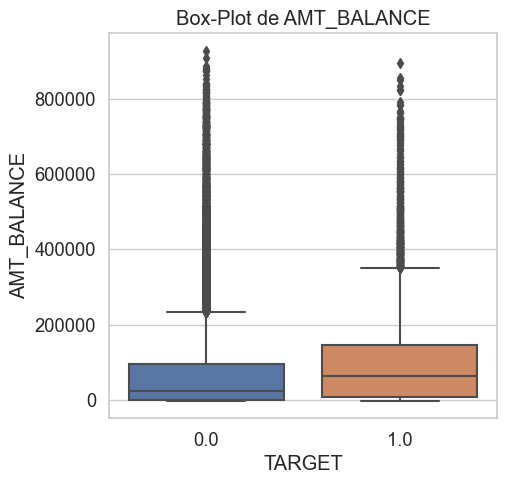

time: 594 ms (started: 2023-09-19 03:49:08 +02:00)


In [78]:
plot_continuous_variables(cc_balance_filtred, 'AMT_BALANCE', plots = ['box'], figsize = (5,5))

_**Observations :**_<br>
* La boîte à moustache ci-dessus, on peut voir que les défaillants ont une valeur AMT_BALANCE plus élevée que les non-défaillants. Ils montrent des valeurs plus élevées pour tous les quantiles. Cela pourrait signifier que le montant du crédit pour les défaillants serait aussi relativement plus élevé que celui des non-défaillants.
* Nous constatons que les défaillants semblent également avoir un versement minimum mensuel plus élevé que les non-défaillants. Cela renseigne généralement sur les habitudes de dépenses et d’emprunt des gens. Les défaillants présentent des habitudes de dépenses et d’emprunt plus élevées que les non-défaillants.

<font color = "#AFA4CE"> _**Distribution de la variable continue AMT_TOTAL_RECEIVABLE**_<font color = "b">

Cette colonne décrit la moyenne du montant total à recevoir sur le crédit précédent.

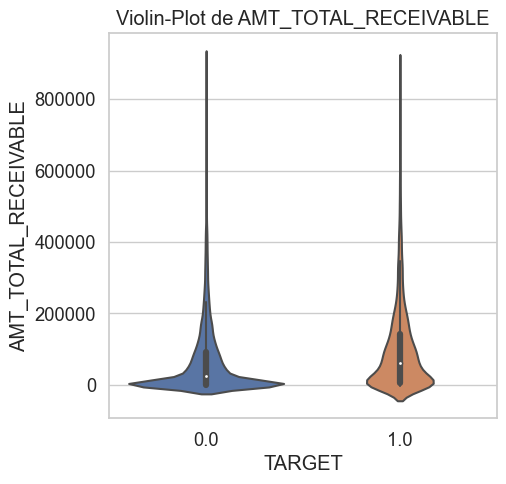

time: 1.03 s (started: 2023-09-19 03:49:08 +02:00)


In [79]:
plot_continuous_variables(cc_balance_filtred, 'AMT_TOTAL_RECEIVABLE', plots = ['violin'], figsize = (5,5))

_**Observations :**_<br>
La boîte à moustache de la colonne "AMT_TOTAL_RECEIVABLE" montre que les défaillants ont généralement un montant à recevoir plus élevé que les non-défaillants. Cela suggère qu'ils ont pu contracter des prêts plus importants. Le graphe montre également un pic plus élevé à des montants inférieurs pour les non-défaillants, ce qui signifie qu'il y a plus de non-défaillants avec des montants à recevoir inférieurs.

<font color = "#AFA4CE"> _**Distribution de la variable continue CNT_INSTALMENT_MATURE_CUM**_<font color = "b">

La colonne décrit le nombre moyen de versements payés sur les crédits précédents.

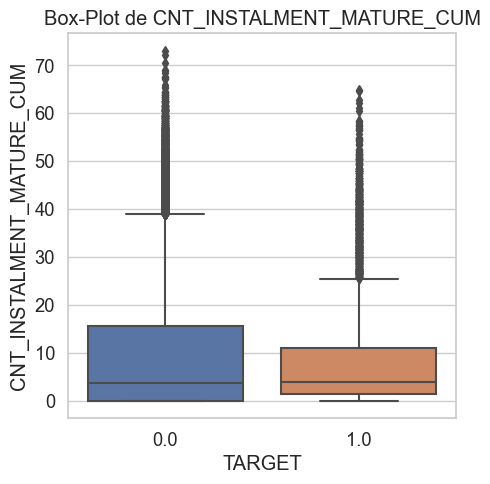

time: 797 ms (started: 2023-09-19 03:49:09 +02:00)


In [80]:
plot_continuous_variables(cc_balance_filtred, 'CNT_INSTALMENT_MATURE_CUM', plots = ['box'], figsize = (5,5))

_**Observations :**_<br>
Le graphique ci-dessus montre que les non-défaillants ont généralement une fourchette de valeurs plus large pour le nombre de versements payés que les défaillants. Cela suggère que les défaillants ont tendance à payer moins de versements sur leur crédit précédent.

## <font color = "#ef4155"> **Conclusions de l'EDA (Analyse Exploratoire des données)**¶<font color = "b">

À partir de l'Analyse Exploratoire Exhaustive que nous avons réalisée, voici les conclusions que l'on peut tirer :
* Tout d'abord, l'ensemble du jeu de données devra être fusionné d'une manière ingénieuse pour ne pas perdre des informations et introduire des biais ;
* Il y a quelques variables numériques continues qui contiennent des valeurs éronnées, nous devrons traiter ces points.
* Nous avons également remarqué certaines variables corrélées, qui ne feraient qu'augmenter la dimensionnalité des données sans ajouter beaucoup de valeur. Nous supprimerons ces variables ;
* Dans l'ensemble, le jeu de données est déséquilibré, et nous devrons trouver des techniques pour gérer ce déséquilibre à fin d'éviter de créer un modèle biaisé ;
* Pour la prédiction du risque de défaut, les défaillants ont généralement un comportement anormal, et donc, nous ne pouvons pas supprimer les valeurs aberrantes ou les points éloignés, car ils pourraient indiquer une tendance importante ;

Avec toutes ces informations, nous passerons à la tâche de Nettoyage des Données et d'Ingénierie des variables."

#### <font color = "#ef4155"> **3. Feature engineering** <font color = "b">

**Les idées clés suivantes ont été utilisées :**

* Diviser ou soustraire des caractéristiques importantes pour obtenir des taux (comme l'annuité et le revenu).
* Dans les données du bureau : créer des caractéristiques spécifiques pour les crédits actifs et les crédits fermés.
* Dans les demandes précédentes : créer des caractéristiques spécifiques pour les demandes approuvées et refusées.
* Encodage unique pour les caractéristiques catégorielles
    
Toutes les tables sont jointes en utilisant la clé **SK_ID_CURR**(ID du client)

#### <font color = "blue"> **3.1. Définition des fonctions**

Nous allons définir un ensemble de fonctions pour préparer les données  dans le but de réaliser la modélisation.

_**Définition des fonctions pour l'encodage des variables catégorielles :**_

* La première fonction, _"label_encoder"_, sera utilisée pour encoder les variables catégorielles binaires en utilisant l'encodage de type label. 
* La deuxième fonction, _"one_hot_encoder"_, effectuera l'encodage one-hot des autres variables catégorielles.

In [81]:
def label_encoder(df):
    """
    Encode les variables catégorielles binaires dans un DataFrame en utilisant l'encodage de type label.

    Args:
        df (DataFrame): Le DataFrame contenant les données.

    Returns:
        DataFrame: Le DataFrame avec les variables catégorielles binaires encodées.
    """
    # Sélectionne toutes les colonnes catégorielles dans le DataFrame
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    
    # Initialise une liste pour stocker les colonnes catégorielles binaires
    binary_categorical_columns = []
    
    # Parcourt les colonnes catégorielles pour identifier celles avec seulement deux valeurs uniques
    for column in categorical_columns:
        if len(df[column].unique()) == 2:
            binary_categorical_columns.append(column)
    
    # Applique l'encodage de type label aux colonnes catégorielles binaires
    for bin_feature in binary_categorical_columns:
        df[bin_feature], uniques = pd.factorize(df[bin_feature], sort=True)
    
    return df

time: 0 ns (started: 2023-09-19 03:49:10 +02:00)


In [82]:
def one_hot_encoder(df, nan_as_category=True):
    """
    Effectue l'encodage one-hot des variables catégorielles dans un DataFrame.

    Args:
        df (DataFrame): Le DataFrame contenant les données.
        nan_as_category (bool): Indique si les valeurs NaN doivent être traitées comme une catégorie. Par défaut, True.

    Returns:
        DataFrame: Le DataFrame avec les variables catégorielles encodées en one-hot.
        list: Une liste des nouvelles colonnes créées lors de l'encodage one-hot.
    """
    # Stocke les noms des colonnes d'origine
    original_columns = list(df.columns)
    
    # Sélectionne toutes les colonnes catégorielles dans le DataFrame
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    
    # Effectue l'encodage one-hot des colonnes catégorielles
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    
    # Identifie les nouvelles colonnes créées lors de l'encodage one-hot
    new_columns = [c for c in df.columns if c not in original_columns]
    
    return df, new_columns

time: 0 ns (started: 2023-09-19 03:49:10 +02:00)


_**Définition des fonctions pour le prétraitement des fichiers :**_ _agrégation, suppression de certains valeurs, création de nouvelles variables..._

In [83]:
def application_train(num_rows=None, nan_as_category=False):
    """
    Charge les données du fichier 'application_train.csv', effectue des transformations et renvoie un DataFrame.

    Args:
        num_rows (int, optional): Le nombre de lignes à charger. Par défaut, None.
        nan_as_category (bool, optional): Indique si les valeurs NaN doivent être traitées comme une catégorie. Par défaut, False.

    Returns:
        DataFrame: Le DataFrame transformé.
    """
    # Charge les données du fichier 'application_train.csv'
    df = pd.read_csv("application_train.csv")
    
    # Supprime les lignes avec 'CODE_GENDER' égal à 'XNA'
    df = df[df['CODE_GENDER'] != 'XNA']

    # Applique l'encodage de type label aux variables catégorielles binaires
    df = label_encoder(df)
    
    # Effectue l'encodage one-hot des autres variables catégorielles
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # Remplace les valeurs 365243 dans 'DAYS_EMPLOYED' par NaN
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    
    # Ajoute de nouvelles caractéristiques
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    # Définit l'index du DataFrame
    df = df.set_index('SK_ID_CURR')
    
    # Libère la mémoire
    gc.collect()
    
    return df

time: 16 ms (started: 2023-09-19 03:49:10 +02:00)


In [84]:
def bureau_balance(num_rows=None, nan_as_category=True):
    # Lecture du fichier bureau.csv
    bureau = pd.read_csv("bureau.csv")
   
    # Lecture du fichier bureau_balance.csv
    bb = pd.read_csv("bureau_balance.csv")
    
    # Encodage one-hot des colonnes catégorielles dans bb (bureau_balance)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    
    # Encodage one-hot des colonnes catégorielles dans bureau
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Agrégation des données dans bb (bureau_balance)
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    
    # Renommage des colonnes agrégées
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    
    # Jointure des données agrégées de bb avec bureau
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    
    # Libération de la mémoire en supprimant les DataFrames inutiles
    del bb, bb_agg
    gc.collect()
    
    # Agrégation des données numériques dans bureau
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }

    # Agrégation des données catégorielles
    cat_aggregations = {}
    for cat in bureau_cat:
        cat_aggregations[cat] = ['mean']
    for cat in bb_cat:
        cat_aggregations[cat + "_MEAN"] = ['mean']
    
    # Agrégation finale des données dans bureau par SK_ID_CURR
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    
    # Renommage des colonnes agrégées
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # Sélection des données pour les crédits actifs
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    
    # Renommage des colonnes agrégées pour les crédits actifs
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    
    # Jointure des données agrégées pour les crédits actifs avec bureau_agg
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    
    # Libération de la mémoire en supprimant les DataFrames inutiles
    del active, active_agg
    gc.collect()
    
    # Sélection des données pour les crédits clos
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    
    # Renommage des colonnes agrégées pour les crédits clos
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    
    # Jointure des données agrégées pour les crédits clos avec bureau_agg
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    
    # Libération de la mémoire en supprimant les DataFrames inutiles
    del closed, closed_agg, bureau
    gc.collect()
    
    return bureau_agg

time: 0 ns (started: 2023-09-19 03:49:10 +02:00)


In [85]:
def POS_CASH_balance(num_rows=None, nan_as_category=True):
    """
    Agrège les données du fichier POS_CASH_balance.csv pour chaque emprunteur (SK_ID_CURR).

    Args:
        num_rows (int, optional): Nombre de lignes à charger (utilisé pour des tests rapides). Par défaut, None.
        nan_as_category (bool, optional): Si True, traite les valeurs manquantes comme une catégorie. Par défaut, True.

    Returns:
        pandas.DataFrame: Un DataFrame avec les données agrégées pour chaque emprunteur, y compris les statistiques numériques et le nombre d'entrées.
    """
    # Lecture du fichier POS_CASH_balance
    pos = pd.read_csv("POS_CASH_balance.csv")
    
    # Encodage one-hot des colonnes catégorielles dans pos
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    
    # Définition des agrégations pour les colonnes numériques
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    
    # Ajout des agrégations pour les colonnes catégorielles
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    # Agrégation des données dans pos par SK_ID_CURR
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    
    # Renommage des colonnes agrégées
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    # Ajout d'une colonne avec le compte des entrées pour chaque SK_ID_CURR
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    
    # Libération de la mémoire en supprimant le DataFrame pos
    del pos
    gc.collect()
    
    return pos_agg

time: 16 ms (started: 2023-09-19 03:49:10 +02:00)


In [86]:
def installments_payments(num_rows=None, nan_as_category=True):
    """
    Agrège les données du fichier installments_payments.csv pour chaque emprunteur (SK_ID_CURR).

    Args:
        num_rows (int, optional): Nombre de lignes à charger (utilisé pour des tests rapides). Par défaut, None.
        nan_as_category (bool, optional): Si True, traite les valeurs manquantes comme une catégorie. Par défaut, True.

    Returns:
        pandas.DataFrame: Un DataFrame avec les données agrégées pour chaque emprunteur, y compris les statistiques numériques et le nombre d'entrées.
    """
    # Lecture du fichier installments_payments.csv
    ins = pd.read_csv("installments_payments.csv")
    
    # Encodage one-hot des colonnes catégorielles dans ins
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
    
    # Calcul de nouvelles caractéristiques
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
   
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

    
    # Définition des agrégations pour les colonnes numériques
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    
    # Ajout des agrégations pour les colonnes catégorielles
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    # Agrégation des données dans ins par SK_ID_CURR
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    
    # Renommage des colonnes agrégées
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    
    # Ajout d'une colonne avec le compte des entrées pour chaque SK_ID_CURR
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    
    # Libération de la mémoire en supprimant le DataFrame ins
    del ins
    gc.collect()
    
    return ins_agg

time: 16 ms (started: 2023-09-19 03:49:10 +02:00)


In [87]:
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv("credit_card_balance.csv")
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

time: 0 ns (started: 2023-09-19 03:49:11 +02:00)


_chargement et traitement des différentes sources de données_

In [88]:
# Appel des fonctions, stockage des transformation dans de nouveaux dataframe et vérification des dimensions
data_application_train = application_train()
print("Dimension du jeu de données appli train : ", data_application_train.shape)

data_bureau_balance = bureau_balance()
print("Dimension du jeu de données bureau balance : ", data_bureau_balance.shape)

data_pos_cash = POS_CASH_balance()
print("Dimension du jeu de données pos cash : ", data_pos_cash.shape)

data_installments_payments = installments_payments()
print("Dimension du jeu de données installments : ", data_installments_payments.shape)

data_credit_card_balance = credit_card_balance()
print("Dimension du jeu de données credit card balance : ", data_credit_card_balance.shape)

Dimension du jeu de données appli train :  (307507, 245)
Dimension du jeu de données bureau balance :  (305811, 116)
Dimension du jeu de données pos cash :  (337252, 18)
Dimension du jeu de données installments :  (339587, 26)
Dimension du jeu de données credit card balance :  (103558, 141)
time: 2min 21s (started: 2023-09-19 03:49:11 +02:00)


_Après la fusion des données, on devra avoir un jeu de données avec 307507 lignes._

In [89]:
# Fusion des nouveaux dataframe pour créer un unique tableau de travail
data = data_application_train \
.join(data_bureau_balance, how='left', on='SK_ID_CURR') \
.join(data_pos_cash, how='left', on='SK_ID_CURR') \
.join(data_installments_payments, how='left', on='SK_ID_CURR') \
.join(data_credit_card_balance, how='left', on='SK_ID_CURR') \
.reset_index()

time: 22.5 s (started: 2023-09-19 03:51:32 +02:00)


_Bref résumé du jeu de données final_

In [90]:
# Dimension
print("Dimension du jeu de données : ", data.shape)

Dimension du jeu de données :  (307507, 547)
time: 31 ms (started: 2023-09-19 03:51:55 +02:00)


In [91]:
# Recherche de doublons dans les données
print("Le jeu de données contient :", data.duplicated().sum(), "doublon")

Le jeu de données contient : 0 doublon
time: 12.6 s (started: 2023-09-19 03:51:55 +02:00)


In [92]:
# Poids du jeu de données
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307507 entries, 0 to 307506
Columns: 547 entries, SK_ID_CURR to CC_COUNT
dtypes: bool(131), float64(356), int64(44), object(16)
memory usage: 1.1 GB
time: 3.19 s (started: 2023-09-19 03:52:08 +02:00)


On constate que le jeu de données est plutôt volumineux (plus d'un giga). Cela peut créer des problèmes lors de l'exécution de calculs lourds, je vais donc utiliser ci-dessous une fonction permettant de réduire la taille des données chargées. Cette fonction parcourt essentiellement tous les types de données dans un fichier et remplace les données par le format le plus léger possible.
Mais avant, je vais éliminer les valeurs manquantes.

In [93]:
def drop_columns_too_many_Nan(df):
    """
    Cette fonction supprime les colonnes d'un DataFrame contenant un pourcentage élevé de valeurs manquantes (NaN).
    
    Args:
        df (DataFrame): Le DataFrame d'entrée.

    Returns:
        DataFrame: Le DataFrame nettoyé sans les colonnes contenant trop de NaN.
    """
    # Calcul du pourcentage de valeurs NaN pour chaque colonne
    total_nan_percentage = df.isnull().sum() / df.shape[0]
    
    # Sélection des colonnes ayant un pourcentage de NaN inférieur à 50%
    features_below_threshold = total_nan_percentage[total_nan_percentage < 0.50]
    
    # Récupération des noms des colonnes sélectionnées
    selected_column_names = list(features_below_threshold.index)
    
    # Création d'un nouveau DataFrame contenant uniquement les colonnes sélectionnées
    df_clean = df[selected_column_names]
    
    # Remplacement des valeurs infinies (inf, -inf) par NaN
    df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    return df_clean

time: 16 ms (started: 2023-09-19 03:52:11 +02:00)


In [94]:
# Appelle de la fonction pour supprimer les colonnes qui contiennent trop de Nan
data = drop_columns_too_many_Nan(data)

time: 1.83 s (started: 2023-09-19 03:52:11 +02:00)


In [95]:
# Vérification des nouvelles dimensions de la matrice de données
print("Dimension du jeu de données : ", data.shape)

Dimension du jeu de données :  (307507, 341)
time: 0 ns (started: 2023-09-19 03:52:13 +02:00)


_**Réduction de la mémoire :**_<br>
Je vais me servir du code proposé par [Guillaume Martin](https://www.kaggle.com/gemartin) et disponible [ici](https://www.kaggle.com/code/gemartin/load-data-reduce-memory-usage/notebook)

In [96]:
def reduce_mem_usage(df):
    """
    Réduit l'utilisation de la mémoire d'un DataFrame en modifiant les types de données des colonnes.

    Args:
        df (DataFrame): DataFrame dont on souhaite réduire l'utilisation de la mémoire.

    Returns:
        DataFrame: Le DataFrame avec une utilisation de mémoire réduite.
    """
    
    # Calcul de l'utilisation initiale de la mémoire
    start_mem = df.memory_usage().sum() / 1024**2
    print('Poids initial du jeu de données {:.2f} MB'.format(start_mem))
    
    # Parcours de toutes les colonnes du DataFrame
    for col in df.columns:
        col_type = df[col].dtype
        
        # Vérifie le type de la colonne
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            # Si la colonne est de type entier
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                # Si la colonne est de type flottant
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            # Si la colonne est de type objet, la convertit en catégorie (category)
            df[col] = df[col].astype('category')

    # Calcul de l'utilisation de la mémoire après la réduction
    end_mem = df.memory_usage().sum() / 1024**2
    print("Poids du jeu de données après réduction de la mémoire: {:.2f} MB".format(end_mem))
    print('Pourcentage de réduction de la mémoire {:.2f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

time: 15 ms (started: 2023-09-19 03:52:13 +02:00)


In [97]:
data = reduce_mem_usage(data)

Poids initial du jeu de données 531.10 MB


Poids du jeu de données après réduction de la mémoire: 218.48 MB
Pourcentage de réduction de la mémoire 58.86%
time: 1.7 s (started: 2023-09-19 03:52:13 +02:00)


In [98]:
# Sauvegarde du jeu de données
data.to_csv('data_Home_credit.csv', index=False)

time: 1min 19s (started: 2023-09-19 03:52:15 +02:00)


A présent que les données ont été néttoyées et encodées, je vais procéder à la modélisation.